In [39]:
# System
import os
from collections import defaultdict
import csv
import re
import progressbar

# Data Analysis
import pandas
import tabulate
import seaborn
import numpy
import matplotlib.pyplot as plt
import matplotlib as mpl

# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Short hack for display of images in jupyter notebook

from IPython.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

In [40]:
FIGS_DIR = "figs"
def save_figure(fig, ext=".png"):
    """Stores @p fig at `figs/fig.@ext`"""
    tgt_dir = os.path.join(DATA_SOURCE, FIGS_DIR)
    tgt = os.path.join(tgt_dir, fig + ext)    
    if not os.path.exists(tgt_dir):
        os.makedirs(tgt_dir)
    print(f"Saving to {tgt}")
    if ext == ".png":
        plt.savefig(tgt, backend="cairo", bbox_inches="tight", pad_inches=0.2)
    else:
        plt.savefig(tgt, bbox_inches="tight", pad_inches=0.2)

In [41]:
DATA_DIR = "./data/"
for experiment_dir in os.listdir(DATA_DIR):
    full_path = os.path.join(DATA_DIR, experiment_dir)
    if os.path.isdir(full_path):
        print(f'DATA_SOURCE = "{full_path}"')

DATA_SOURCE = "./data/experiments-09-18"
DATA_SOURCE = "./data/experiments-09-19"
DATA_SOURCE = "./data/experiments-09-21"
DATA_SOURCE = "./data/experiments-09-23"
DATA_SOURCE = "./data/experiments-09-25-concat"
DATA_SOURCE = "./data/experiments-09-26-partial-testing"
DATA_SOURCE = "./data/experiments-09-27"
DATA_SOURCE = "./data/experiments-09-29-new-mata"
DATA_SOURCE = "./data/experiments-09-30-parsing"
DATA_SOURCE = "./data/experiments-10-01-mata-union"
DATA_SOURCE = "./data/experiments-10-02"
DATA_SOURCE = "./data/experiments-10-02-parsing"


In [42]:
DATA_SOURCE = "./data/experiments-10-02-parsing"

## Creating DataFrame

In [43]:
ERR = -1
TIMEOUT = -1

def to_operation(src, lang):
    op = src.split('-')[-1]
    if 'runtime' in op:
        return 'runtime'
    elif 'deter' in op:
        return 'determization'
    elif 'minterm' in op:
        return 'minterm'
    elif 'inter' in op:
        return 'intersection'
    elif 'union' in op or 'uni' in op:
        return 'union'
    elif ('construction' in op and lang != 'c++') or 'parsing' in op:
        return 'parsing'
    elif ('construction' in op and lang == 'c++') or 'conversion' in op:
        return 'transform'
    elif 'concat' in op:
        return 'concatenation'
    elif 'result' in op:
        return 'result'
    elif 'inclusion_check' == op or 'inclusion' == op:
        return 'inclusion'
    elif 'emptiness_check' == op or 'emptiness' == op:
        return 'emptiness'
    elif 'compl' == op or 'complementation' == op or 'complement' == op:
        return 'complement'
    elif 'trim' in op:
        return 'trim'
    print(f"{src} unhandled")
    assert False

def to_tool_and_lang(tool):
    if 'mata-bin' in tool:
        return None, None
    if 'mata-old' in tool:
        return "mata-old", "c++"
    elif 'awali' in tool:
        return 'awali', 'c++'
    elif 'mona' in tool:
        return 'mona', 'c++'
    elif 'vata' in tool:
        return 'vata', 'c++'
    elif 'java-brics' in tool:
        return 'brics', 'java'
    elif 'java-automata' in tool:
        return '(j)alib', 'java'
    elif 'pyfado' in tool:
        return 'fado', 'python'
    elif 'pyautomata-lib' in tool:
        return '(py)alib', 'python'
    elif 'pymata' in tool:
        return '(py)mata', 'python'
    elif 'automata' in tool:
        return 'automata', 'c#'
    elif 'mata' in tool:
        return 'mata', 'c++'
    print(f"{tool} unhandled")
    assert False

def to_bench(bench, src):
    print(src)
    if 'automata_inclusion' in bench:
        return 'aut_inclusion'
    elif 'cox/diff' in bench:
        return 'bc_cox_diff' if 'union' not in src else 'bc_cox_union'
    elif 'cox/inter' in bench:
        return 'bc_cox_inter' if 'union' not in src else 'bc_cox_union'
    elif 'intersect' in bench:
        return 'bc_intersect' if 'union' not in src else 'bc_intersect_union'
    elif 'email_filter' in bench:
        return 'email_filter'
    elif 'z3-noodler' in bench:
        return 'z3_noodler'
    elif 'presburger' in bench:
        return 'presburger'
    print(f"{bench} unhandled")
    assert False

def to_value(val):
    val = val.strip()
    try:
        return float(val)
    except ValueError:
        pass
    if val in ['EMPTY', "NOT EMPTY"]:
        return val
    elif val in ('false', 'False'):
        return 'false'
    elif val in ('true', 'True'):
        return 'true'
    elif val == 'ERR':
        return 'ERR'
    elif val == 'MISSING':
        return numpy.NAN
    elif val == 'TIMEOUT' or val == 'TO':
        return TIMEOUT if TIMEOUT < 0 else -TIMEOUT
    print(f"{val} unhandled")
    assert False

In [44]:
HEADERS = ["bench", "input", "tool", "lang", "op", "time"]
TIMEOUT = -60
TIMEOUT_REGEX = re.compile("timeout-(\d+)")
processed = defaultdict(set)
op_map = defaultdict(list)
def to_pandas(src_dir):
    global TIMEOUT
    data = []
    for csv_source in progressbar.progressbar(os.listdir(src_dir)):
        if csv_source.endswith('.csv'):
            if timeout := TIMEOUT_REGEX.search(csv_source):
                TIMEOUT = int(timeout.group(1))
            with open(os.path.join(src_dir, csv_source), 'r', newline='') as csvfile:
                try:
                    csv_reader = csv.reader(csvfile, delimiter=';')
                    head = next(csv_reader)
                    for row in csv_reader:
                        bench = to_bench(row[0], csv_source) # bench
                        inputs = row[0] # inputs
                        for i, val in enumerate(row[1:], 1):
                            tool, lang = to_tool_and_lang(head[i]) # tool, lang
                            if not tool:
                                continue
                            op = to_operation(head[i], lang) # op
                            op_map[op].append(head[i])
                            val = to_value(val)
                            data.append([bench, inputs, tool, lang, op, val])
                except StopIteration:
                    pass
    return pandas.DataFrame(data, columns=HEADERS)
df = to_pandas(DATA_SOURCE)
print(df)

 39% (9 of 23) |#########                | Elapsed Time: 0:00:00 ETA:  00:00:00

tacas-24-automata-inclusion-bench-double-automata-inclusion-2023-10-02-12-42-04-timeout-60-jobs-4-m-mata;mata-old.twelfth-experiments-parsing-only.csv
tacas-24-automata-inclusion-bench-double-automata-inclusion-2023-10-02-12-42-04-timeout-60-jobs-4-m-mata;mata-old.twelfth-experiments-parsing-only.csv
tacas-24-automata-inclusion-bench-double-automata-inclusion-2023-10-02-12-42-04-timeout-60-jobs-4-m-mata;mata-old.twelfth-experiments-parsing-only.csv
tacas-24-automata-inclusion-bench-double-automata-inclusion-2023-10-02-12-42-04-timeout-60-jobs-4-m-mata;mata-old.twelfth-experiments-parsing-only.csv
tacas-24-automata-inclusion-bench-double-automata-inclusion-2023-10-02-12-42-04-timeout-60-jobs-4-m-mata;mata-old.twelfth-experiments-parsing-only.csv
tacas-24-automata-inclusion-bench-double-automata-inclusion-2023-10-02-12-42-04-timeout-60-jobs-4-m-mata;mata-old.twelfth-experiments-parsing-only.csv
tacas-24-automata-inclusion-bench-double-automata-inclusion-2023-10-02-12-42-04-timeout-60-job

100% (23 of 23) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


tacas-24-email-filter-bench-quintuple-email-filter-2023-10-02-12-43-12-timeout-60-jobs-4-m-mata;mata-old.twelfth-experiments-parsing-only.csv
tacas-24-email-filter-bench-quintuple-email-filter-2023-10-02-12-43-12-timeout-60-jobs-4-m-mata;mata-old.twelfth-experiments-parsing-only.csv
tacas-24-email-filter-bench-quintuple-email-filter-2023-10-02-12-43-12-timeout-60-jobs-4-m-mata;mata-old.twelfth-experiments-parsing-only.csv
tacas-24-email-filter-bench-quintuple-email-filter-2023-10-02-12-43-12-timeout-60-jobs-4-m-mata;mata-old.twelfth-experiments-parsing-only.csv
tacas-24-email-filter-bench-quintuple-email-filter-2023-10-02-12-43-12-timeout-60-jobs-4-m-mata;mata-old.twelfth-experiments-parsing-only.csv
tacas-24-email-filter-bench-quintuple-email-filter-2023-10-02-12-43-12-timeout-60-jobs-4-m-mata;mata-old.twelfth-experiments-parsing-only.csv
tacas-24-email-filter-bench-quintuple-email-filter-2023-10-02-12-43-12-timeout-60-jobs-4-m-mata;mata-old.twelfth-experiments-parsing-only.csv
tacas-

In [45]:
for op, mapped in op_map.items():
    print(f"{op} -> {set(mapped)}")

runtime -> {'mata-runtime', 'mata-old-runtime'}
parsing -> {'mata-mataparsing', 'mata-old-mataparsing'}
minterm -> {'mata-old-mataminterm', 'mata-mataminterm'}
inclusion -> {'mata-inclusion_check', 'mata-old-inclusion_check'}
result -> {'mata-inclusion_check_result', 'mata-old-emptiness_check_result', 'mata-emptiness_check_result', 'mata-old-inclusion_check_result'}
intersection -> {'mata-old-intersection', 'mata-intersection'}
trim -> {'mata-trim', 'mata-old-trim'}
emptiness -> {'mata-old-emptiness_check', 'mata-emptiness_check'}
union -> {'mata-uni', 'mata-old-uni'}
complement -> {'mata-old-compl', 'mata-compl'}
concatenation -> {'mata-old-concat', 'mata-concat'}


In [46]:
def to_table(df, rows, aggregation, trim_rows=False, trimsize=5):
    tools = ['mata', 'mata-old', 'awali', 'mona', 'vata',  'automata', 'brics', '(j)alib', 'fado', '(py)alib', '(py)mata']
    tools = [t for t in tools if t in set(df['tool'])]
    data = {
        grp: [grp[:trimsize] if trim_rows else grp] + ['-' for i in range(len(tools))] for grp in set(df[rows]) if grp != 'result' and 'result' not in grp
    }
    for grp, series in df.groupby([rows, 'tool'] if not isinstance(rows, list) else rows + tools):
        if grp[0] == 'result' or 'result' in grp[0]:
            continue
        vals = aggregation(series['time'])
        data[grp[0]][tools.index(grp[1]) + 1] = ", ".join(vals)
    return tabulate.tabulate(
        sorted(data.values()), headers=[rows] + tools
    )

def to_printable_table(table, title):
    table_len = len(table.split('\n')[1])
    printable = title.center(table_len) + "\n"
    printable += "-" * table_len + "\n"
    printable += table
    return printable

def print_table(table, title):
    printable = to_printable_table(table, title)
    print(printable)

def save_table(table, title, filename):
    tgt_dir = os.path.join(DATA_SOURCE, FIGS_DIR)
    tgt = os.path.join(tgt_dir, filename)    
    printable = to_printable_table(table, title)
    if not os.path.exists(tgt_dir):
        os.makedirs(tgt_dir)
    with open(tgt, 'w') as table_h:
        table_h.write(printable)
    print(f"Saved to {tgt}")
    

In [47]:
## Mean, Median Mean with timeouts/errors
def mean_med_overall(series):
    times = [t for t in series if  (isinstance(t, float) or isinstance(t, int)) and t >= 0]
    times_with_timeout = [t if (isinstance(t, float) or isinstance(t, int)) and t >= 0 else TIMEOUT for t in series]
    mean = round(numpy.mean(times or [-1]), 1)
    mean_with_timeouts = round(numpy.mean(times_with_timeout or [-1]), 1)
    median = round(numpy.median(times or [-1]), 1)
    return (
        f"{mean:0.01f}" if mean != -1 else f"{'-':<4}", 
        f"{median:0.1f}" if median != -1 else f"{'-':<5}", 
        f"{mean_with_timeouts:0.1f}" if mean != -1 else f"{'-':<4}"
    )
table = to_table(df, 'op', mean_med_overall, trim_rows=True)
print_table(table, "Average / Median / Average with Timeouts")
print()
save_table(table, "Average / Median / Average with Timeouts", "avg-med-avgt.txt")

Average / Median / Average with Timeouts
-------------------------------------
op     mata            mata-old
-----  --------------  --------------
compl  0.0, 0.0, 0.5   0.0, 0.0, 0.5
conca  0.1, 0.0, 0.1   0.1, 0.0, 0.1
empti  0.0, 0.0, 5.2   0.0, 0.0, 5.2
inclu  0.1, 0.0, 0.1   0.1, 0.0, 0.1
inter  2.3, 0.0, 10.9  2.3, 0.0, 10.6
minte  0.1, 0.0, 7.6   0.1, 0.0, 7.9
parsi  0.1, 0.0, 3.9   0.1, 0.0, 4.0
runti  0.3, 0.0, 5.8   0.3, 0.0, 5.8
trim   0.2, 0.0, 3.3   0.2, 0.0, 3.2
union  0.0, 0.0, 0.0   0.0, 0.0, 0.0

Saved to ./data/experiments-10-02-parsing/figs/avg-med-avgt.txt


In [48]:
## Finished, Errors and Timeouts
def fin_err_tim(series):
    timeouts = [a for a in series if (isinstance(a, float) or isinstance(a, int)) and a < 0 and not numpy.isnan(a) and a != 'ERR']
    errors = [a for a in series if a == 'ERR']
    times = [t for t in series if  (isinstance(t, float) or isinstance(t, int)) and t >= 0]
    return (
        f"{len(times):}",
        f"{len(errors):}",
        f"{len(timeouts):}"
    )
table = to_table(df[df['op'] == 'runtime'], 'bench', fin_err_tim)
print_table(table, "Finished / Errors / Timeouts")
print()
save_table(table, "Finished / Errors / Timeouts", "fin-err-to.txt")

        Finished / Errors / Timeouts        
--------------------------------------------
bench               mata         mata-old
------------------  -----------  -----------
aut_inclusion       136, 0, 0    136, 0, 0
bc_cox_diff         40, 13, 27   40, 16, 24
bc_cox_inter        40, 29, 11   40, 36, 4
bc_cox_union        80, 0, 0     80, 0, 0
bc_intersect        31, 114, 42  31, 110, 46
bc_intersect_union  187, 0, 0    187, 0, 0
email_filter        500, 0, 0    500, 0, 0
presburger          174, 0, 0    174, 0, 0
z3_noodler          1189, 8, 0   1189, 8, 0

Saved to ./data/experiments-10-02-parsing/figs/fin-err-to.txt


In [49]:
## First, Second, Third Quartiles
def quartiles(series):
    times = [t if (isinstance(t, float) or isinstance(t, int)) and t >= 0 else TIMEOUT for t in series]
    first = numpy.quantile(times, 0.25)
    second = numpy.quantile(times, 0.5)
    third = numpy.quantile(times, 0.75)
    iqr = third - first
    return (
        f"{first:0.0f}" if first < TIMEOUT else f"{TIMEOUT}", 
        f"{second:0.0f}" if second < TIMEOUT else f"{TIMEOUT}", 
        f"{third:0.0f}" if third < TIMEOUT else f"{TIMEOUT}"
    )
table = to_table(df, 'bench', quartiles, trim_rows=True)
print_table(table, "1st Quartile / Median / 3rd Quartile")
print()
save_table(table, "1st Quartile / Median / 3rd Quartile", "quartiles.txt")

1st Quartile / Median / 3rd Quartile
-------------------------------
bench    mata        mata-old
-------  ----------  ----------
aut_i    0, 0, 1     0, 0, 1
bc_co    0, 0, 0     0, 0, 0
bc_co    0, 0, 60    0, 0, 60
bc_co    0, 0, 60    0, 0, 60
bc_in    0, 0, 1     0, 0, 1
bc_in    28, 60, 60  23, 60, 60
email    0, 0, 0     0, 0, 0
presb    0, 0, 0     0, 0, 0
z3_no    0, 0, 0     0, 0, 0

Saved to ./data/experiments-10-02-parsing/figs/quartiles.txt


In [50]:
## First, Second, Third Quartiles
def quartiles(series):
    times = [t if (isinstance(t, float) or isinstance(t, int)) and t >= 0 else TIMEOUT for t in series]
    first = numpy.quantile(times, 0.25)
    second = numpy.quantile(times, 0.5)
    third = numpy.quantile(times, 0.75)
    iqr = third - first
    return (
        f"{first:0.1f}" if first < TIMEOUT else f"{TIMEOUT}", 
        f"{second:0.1f}" if second < TIMEOUT else f"{TIMEOUT}", 
        f"{third:0.1f}" if third < TIMEOUT else f"{TIMEOUT}"
    )
table = to_table(df, 'op', quartiles, trim_rows=True)
print_table(table, "1st Quartile / Median / 3rd Quartile per operation")
print()
save_table(table, "1st Quartile / Median / 3rd Quartile per operation", "quartiles-op.txt")

1st Quartile / Median / 3rd Quartile per operation
-----------------------------------
op     mata           mata-old
-----  -------------  -------------
compl  0.0, 0.0, 0.0  0.0, 0.0, 0.0
conca  0.0, 0.0, 0.0  0.0, 0.0, 0.0
empti  0.0, 0.0, 0.0  0.0, 0.0, 0.0
inclu  0.0, 0.0, 0.0  0.0, 0.0, 0.0
inter  0.0, 0.0, 0.5  0.0, 0.0, 0.5
minte  0.0, 0.0, 0.1  0.0, 0.0, 0.1
parsi  0.0, 0.0, 0.1  0.0, 0.0, 0.1
runti  0.0, 0.0, 0.3  0.0, 0.0, 0.3
trim   0.0, 0.0, 0.0  0.0, 0.0, 0.0
union  0.0, 0.0, 0.0  0.0, 0.0, 0.0

Saved to ./data/experiments-10-02-parsing/figs/quartiles-op.txt


In [51]:
## First, Second, Third Quartiles
def quartiles(series):
    times = [t if (isinstance(t, float) or isinstance(t, int)) and t >= 0 else TIMEOUT for t in series]
    first = numpy.quantile(times, 0.25)
    second = numpy.quantile(times, 0.5)
    third = numpy.quantile(times, 0.75)
    iqr = third - first
    return (
        f"{first:0.1f}" if first < TIMEOUT else f"{TIMEOUT}", 
        f"{second:0.1f}" if second < TIMEOUT else f"{TIMEOUT}", 
        f"{third:0.1f}" if third < TIMEOUT else f"{TIMEOUT}"
    )
df['benchop'] = [f"{o[:5]}/{''.join(a[0] for a in b.split('_'))}" for b, o in zip(df['bench'], df['op'])]
table = to_table(df, 'benchop', quartiles, trim_rows=True, trimsize=9)
print_table(table, "1st Quartile / Median / 3rd Quartile per op/bench")
print()
save_table(table, "1st Quartile / Median / 3rd Quartile per op/bench", "quartiles-benchop.txt")

1st Quartile / Median / 3rd Quartile per op/bench
---------------------------------------
benchop    mata           mata-old
---------  -------------  -------------
compl/p    0.0, 0.0, 0.0  0.0, 0.0, 0.0
compl/zn   0.0, 0.0, 0.0  0.0, 0.0, 0.0
conca/zn   0.0, 0.0, 0.0  0.0, 0.0, 0.0
empti/bcd  0.0, 0.0, 0.0  0.0, 0.0, 0.0
empti/bci  0.0, 0.0, 0.0  0.0, 0.0, 0.0
empti/bcu  0.0, 0.0, 0.0  0.0, 0.0, 0.0
empti/bi   60, 60, 60     60, 60, 60
empti/biu  0.0, 0.0, 0.0  0.0, 0.0, 0.0
empti/p    0.0, 0.0, 0.0  0.0, 0.0, 0.0
empti/zn   0.0, 0.0, 0.0  0.0, 0.0, 0.0
inclu/ai   0.0, 0.0, 0.0  0.0, 0.0, 0.0
inclu/ef   0.0, 0.0, 0.0  0.0, 0.0, 0.0
inter/bcd  0.1, 0.3, 0.7  0.1, 0.3, 0.7
inter/bci  0.1, 0.3, 0.6  0.1, 0.3, 0.7
inter/bi   29.1, 60, 60   26.6, 60, 60
inter/ef   0.0, 0.0, 0.0  0.0, 0.0, 0.0
minte/ai   0.0, 0.1, 0.1  0.0, 0.1, 0.1
minte/bcd  0.0, 0.1, 0.1  0.0, 0.0, 0.1
minte/bci  0.1, 0.1, 60   0.0, 0.1, 60
minte/bcu  0.0, 0.1, 0.1  0.0, 0.0, 0.1
minte/bi   0.1, 60, 60    0.1, 60, 60
mi

In [52]:
def sum_generator(series, timeout=None):
    """Cumulatively sums the @p series wrt @p timeout"""
    sum = 0
    series = sorted(
        [a if isinstance(a, float) else numpy.NAN for a in series['time']],
        key = lambda x: float('inf') if numpy.isnan(x) else x
    )
    for num in sorted(series):
        if timeout and num >= timeout:
            yield None
        else:
            sum += num
            yield sum

In [53]:
tools = sorted(t for t in set(df['tool']))
tool_len = len(tools)
color_map = {
    t: c for (t, c) in zip(tools, mpl.colormaps['tab10'].resampled(tool_len).colors)
}

Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-aut_inclusion-inclusion.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-aut_inclusion-minterm.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-aut_inclusion-parsing.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-aut_inclusion-result.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-aut_inclusion-runtime.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-bc_cox_diff-emptiness.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-bc_cox_diff-intersection.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-bc_cox_diff-minterm.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-bc_cox_diff-parsing.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-bc_cox_diff-result.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-bc_cox_diff-runtime.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot

/tmp/ipykernel_1820/1014013729.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15, 8))


Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-bc_cox_union-minterm.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-bc_cox_union-parsing.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-bc_cox_union-result.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-bc_cox_union-runtime.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-bc_cox_union-trim.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-bc_cox_union-union.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-bc_intersect-emptiness.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-bc_intersect-intersection.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-bc_intersect-minterm.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-bc_intersect-parsing.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-bc_intersect-result.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-bc_in

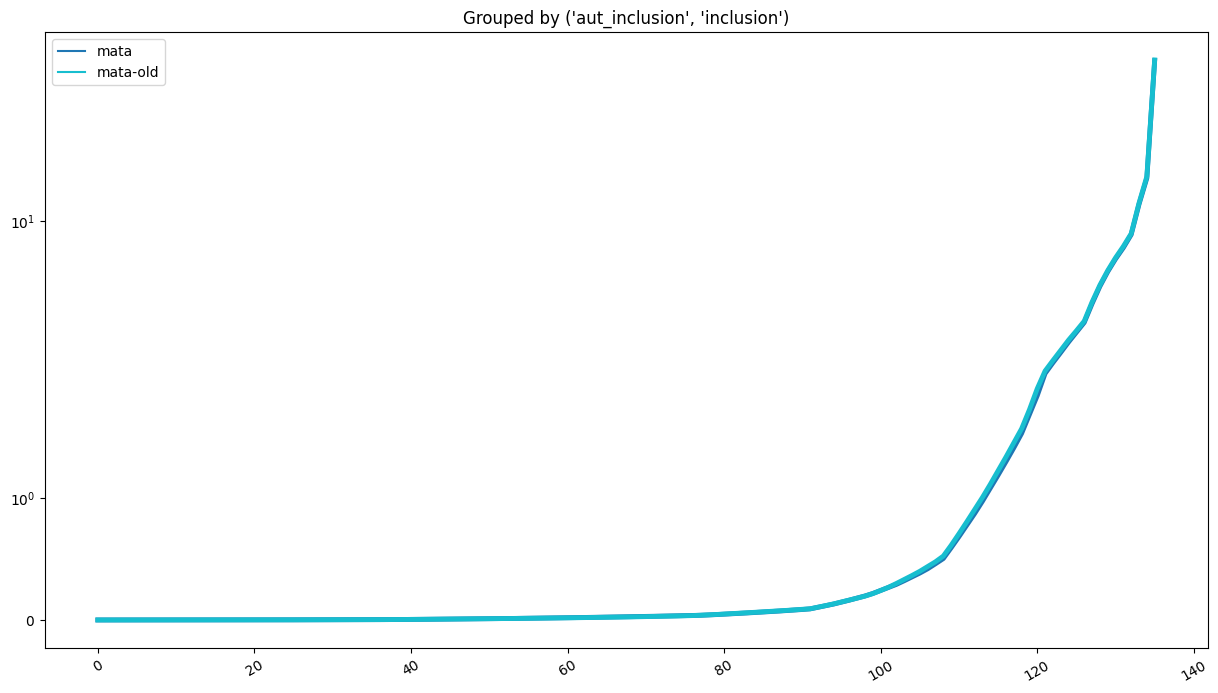

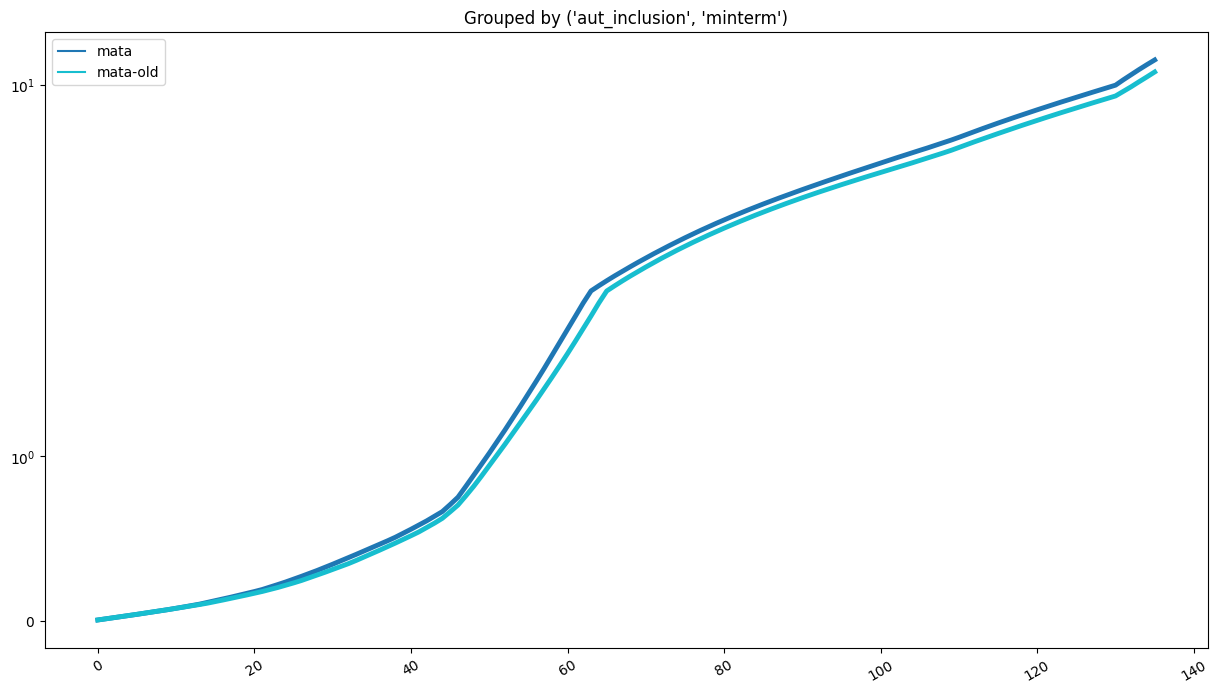

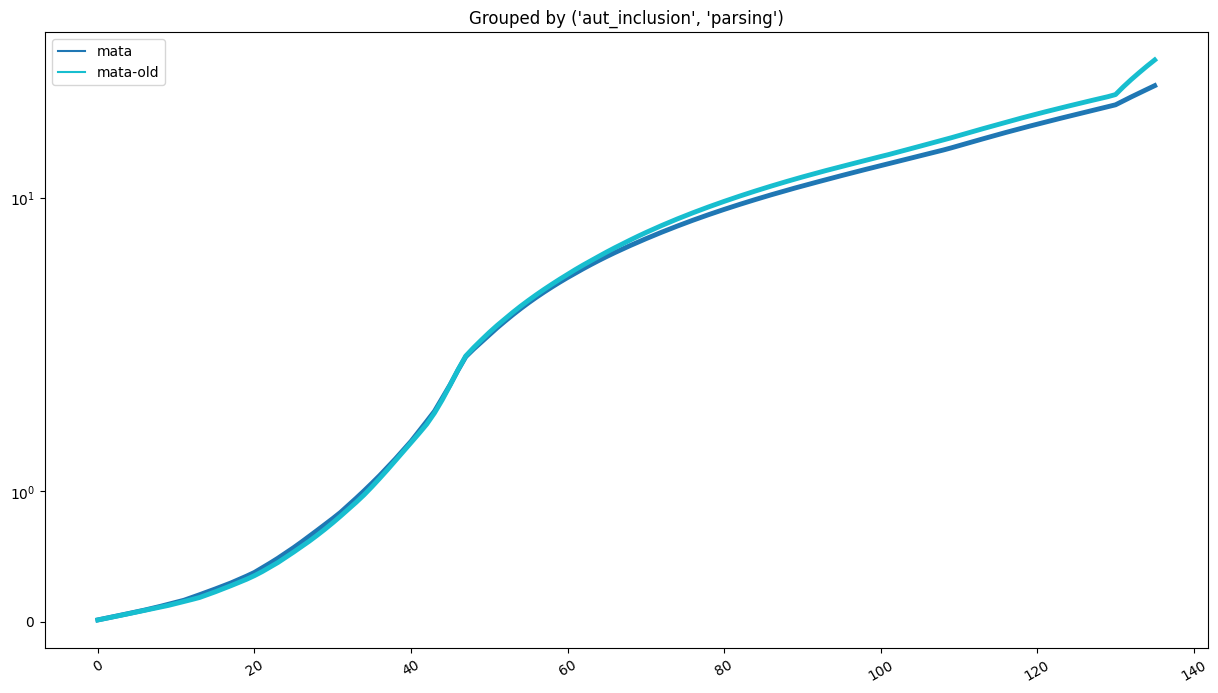

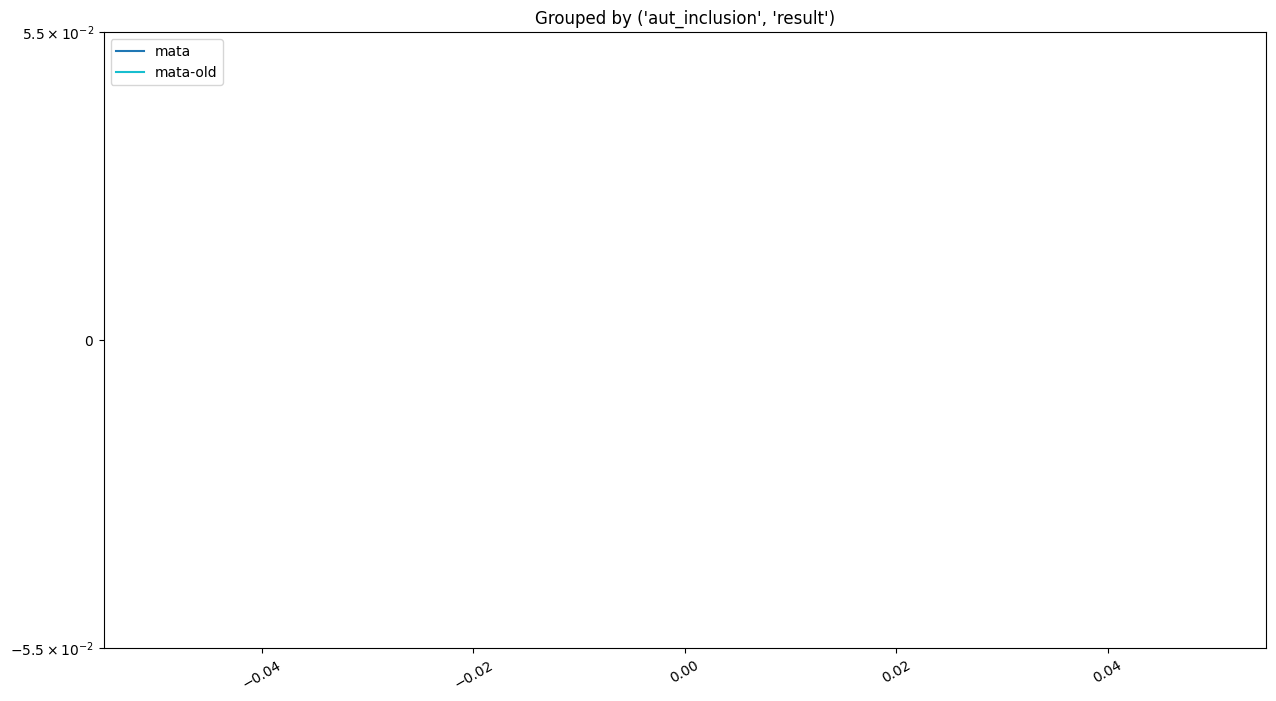

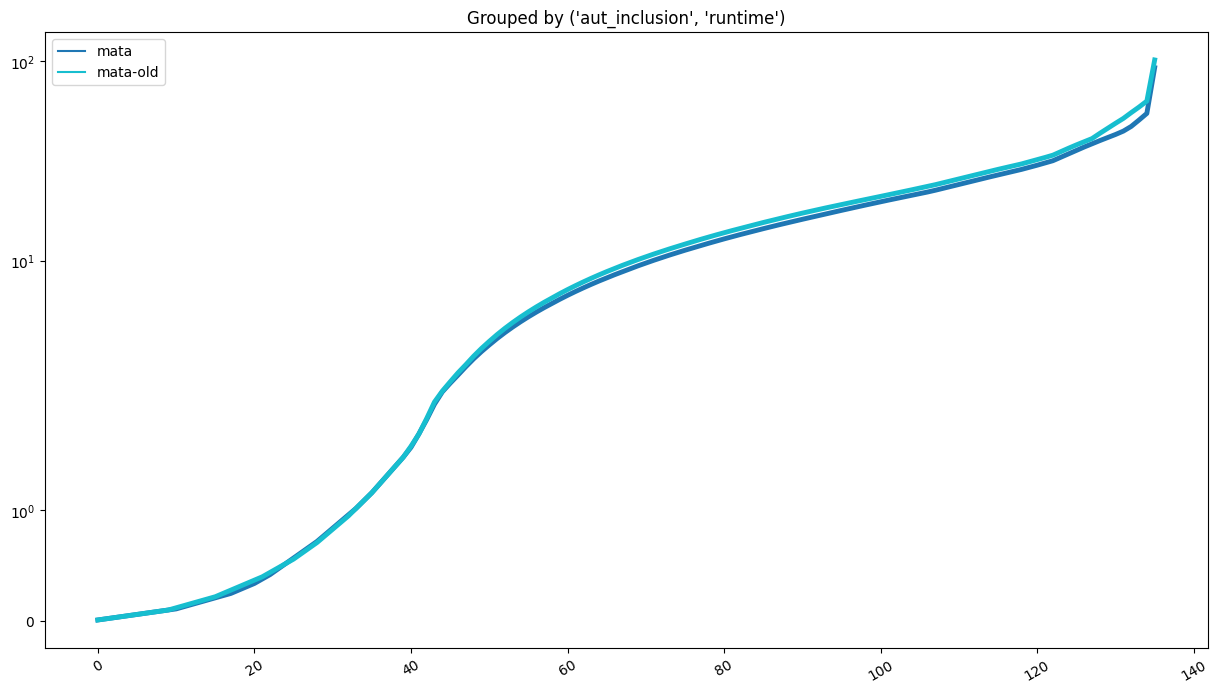

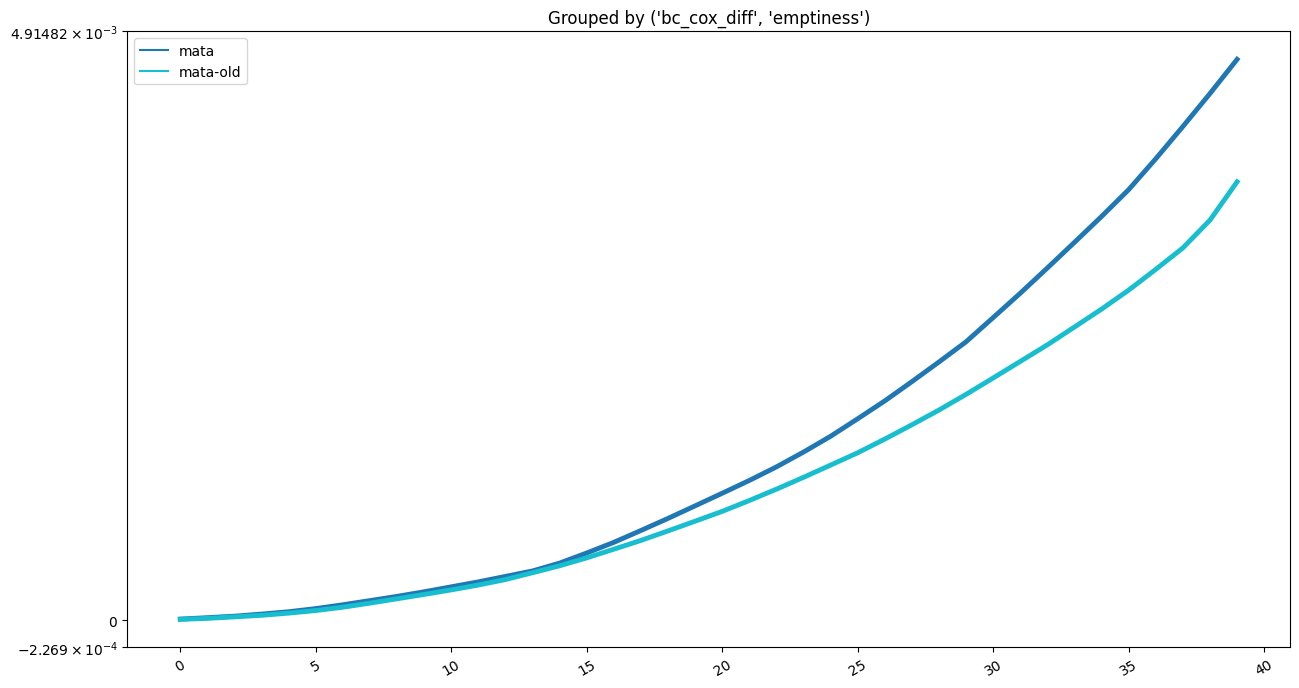

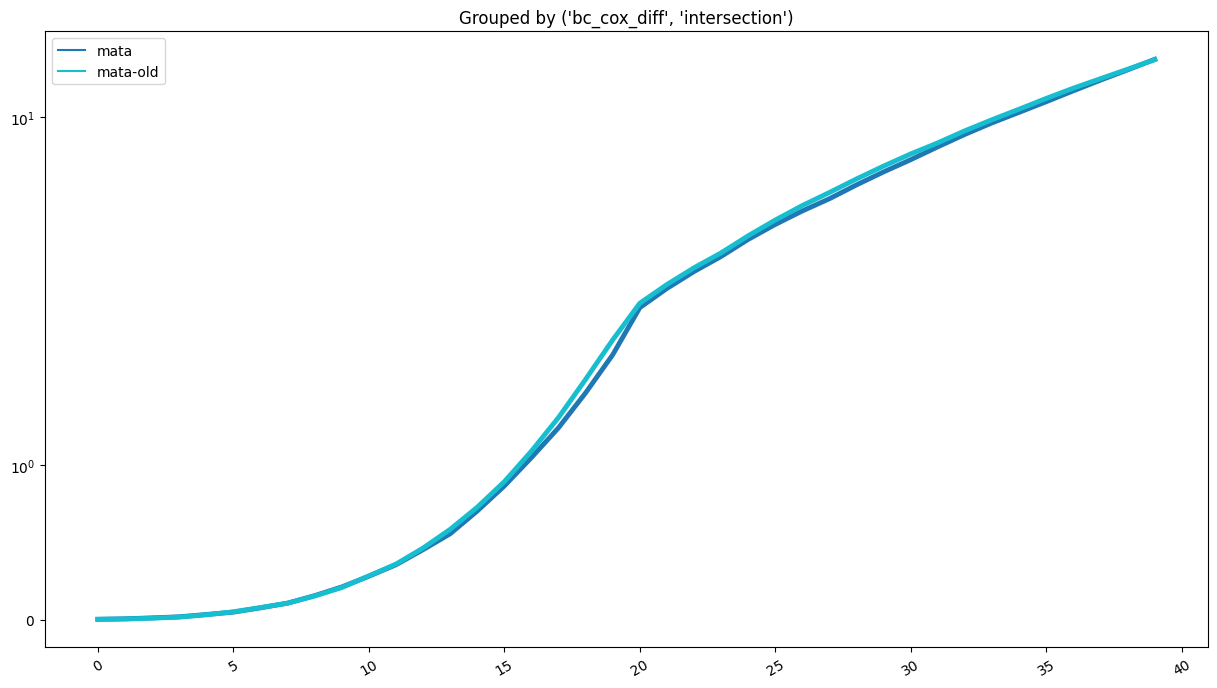

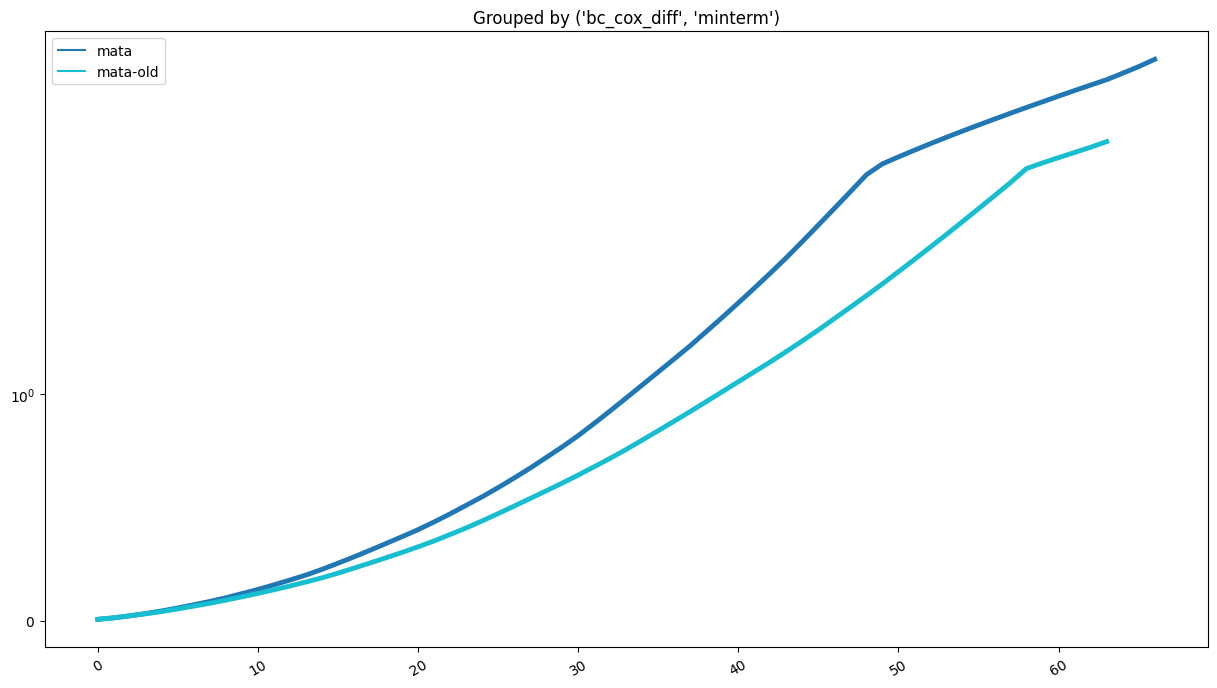

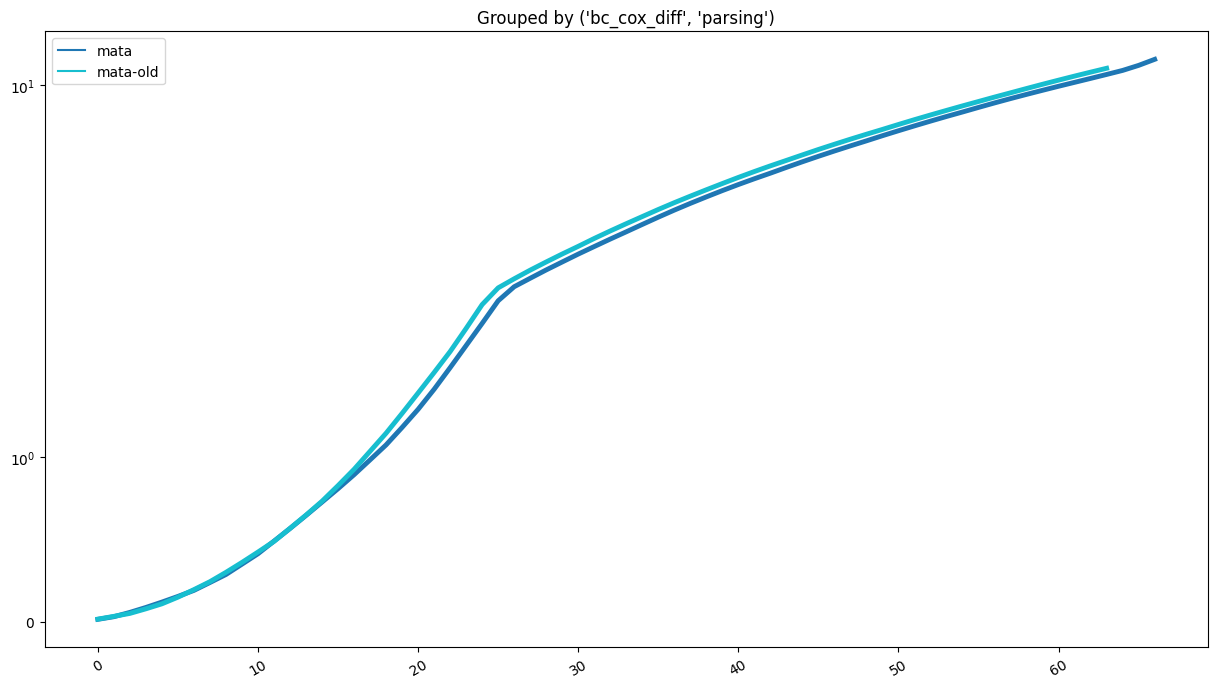

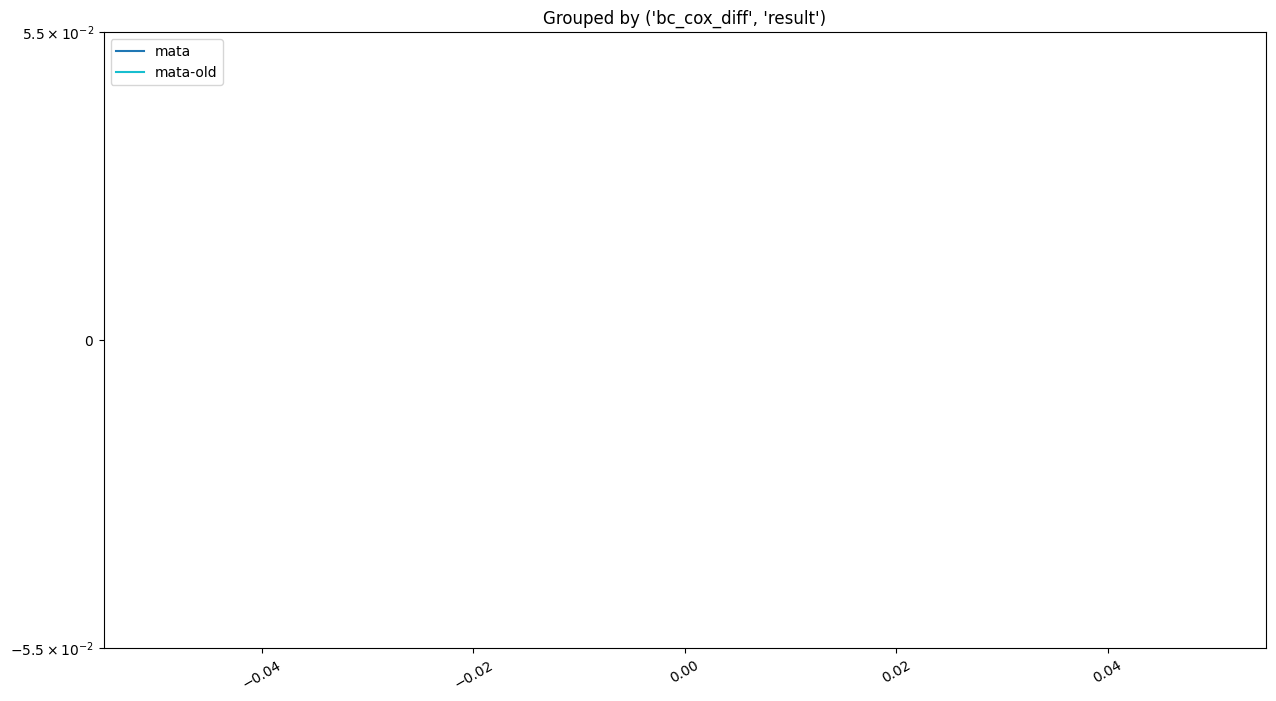

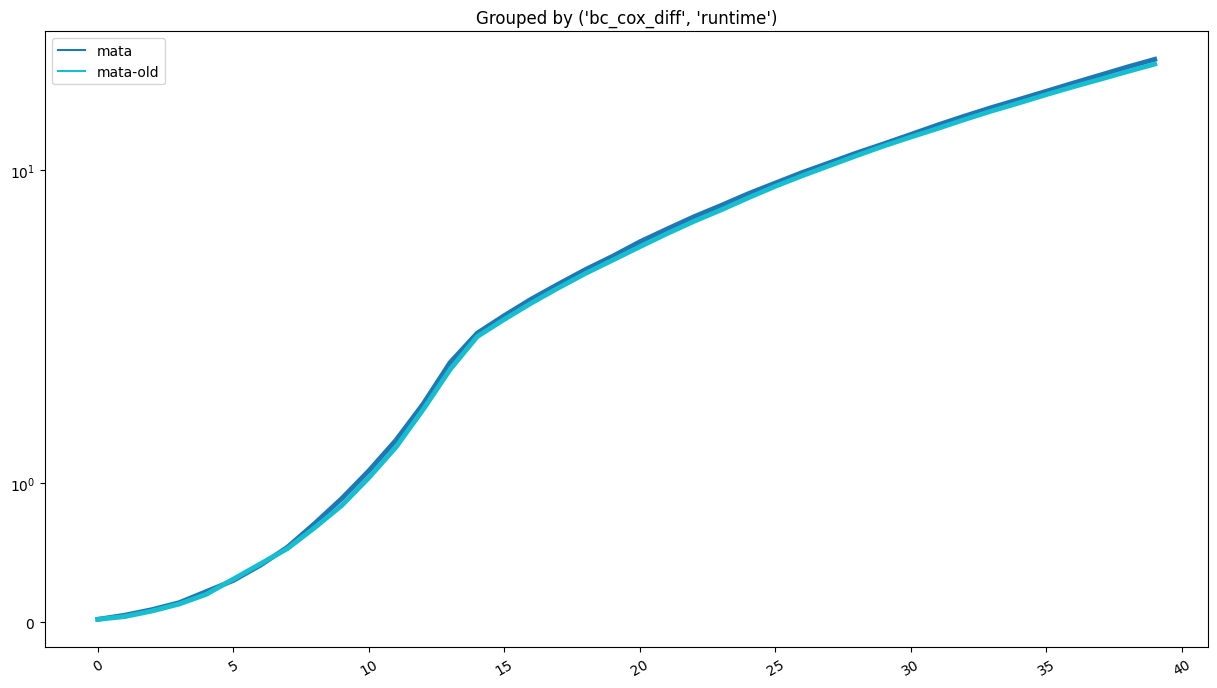

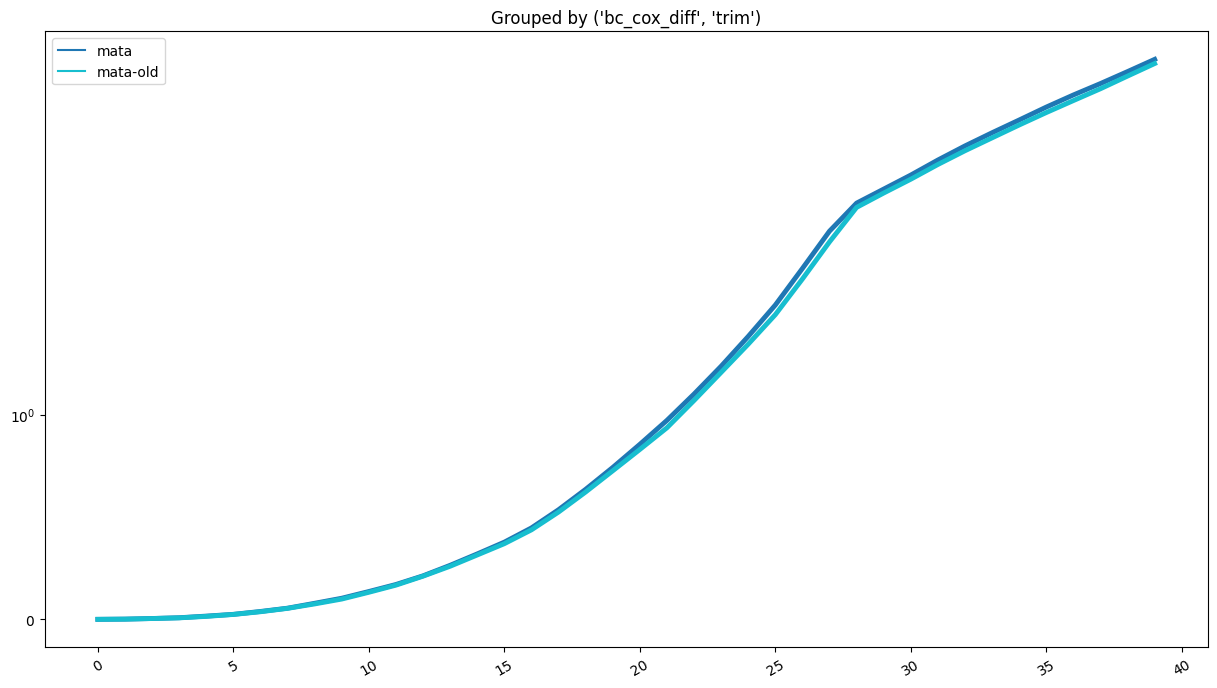

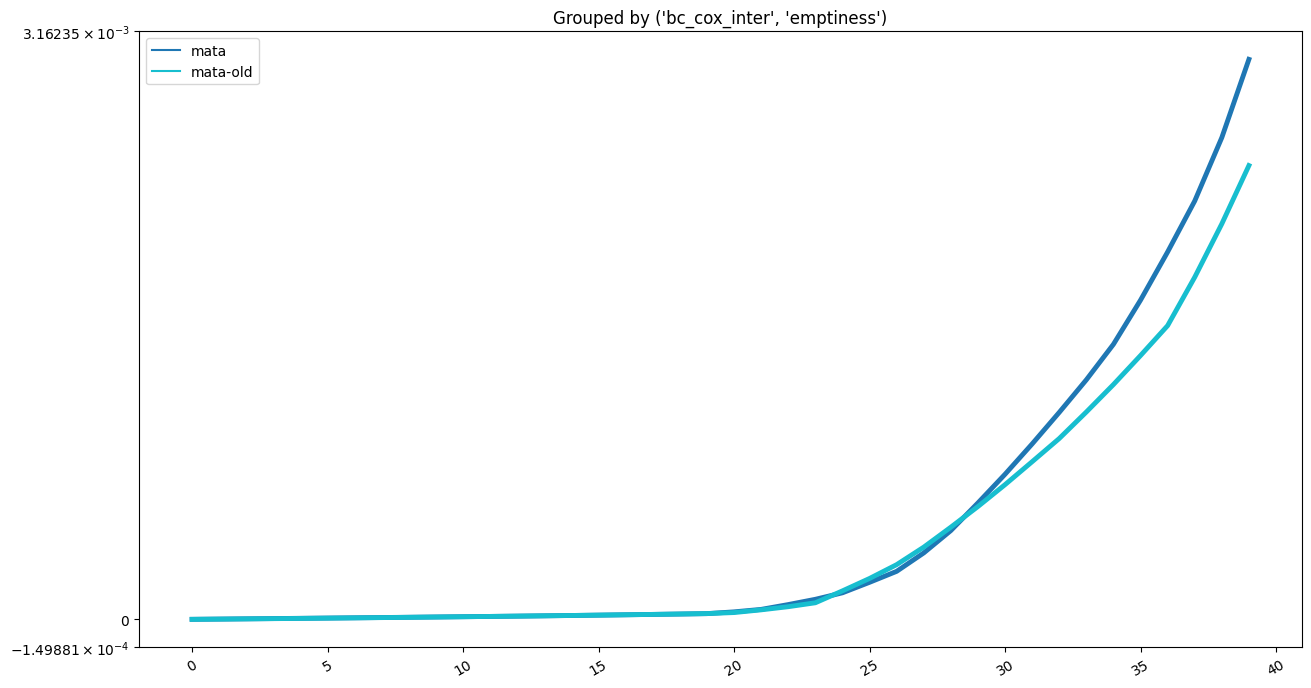

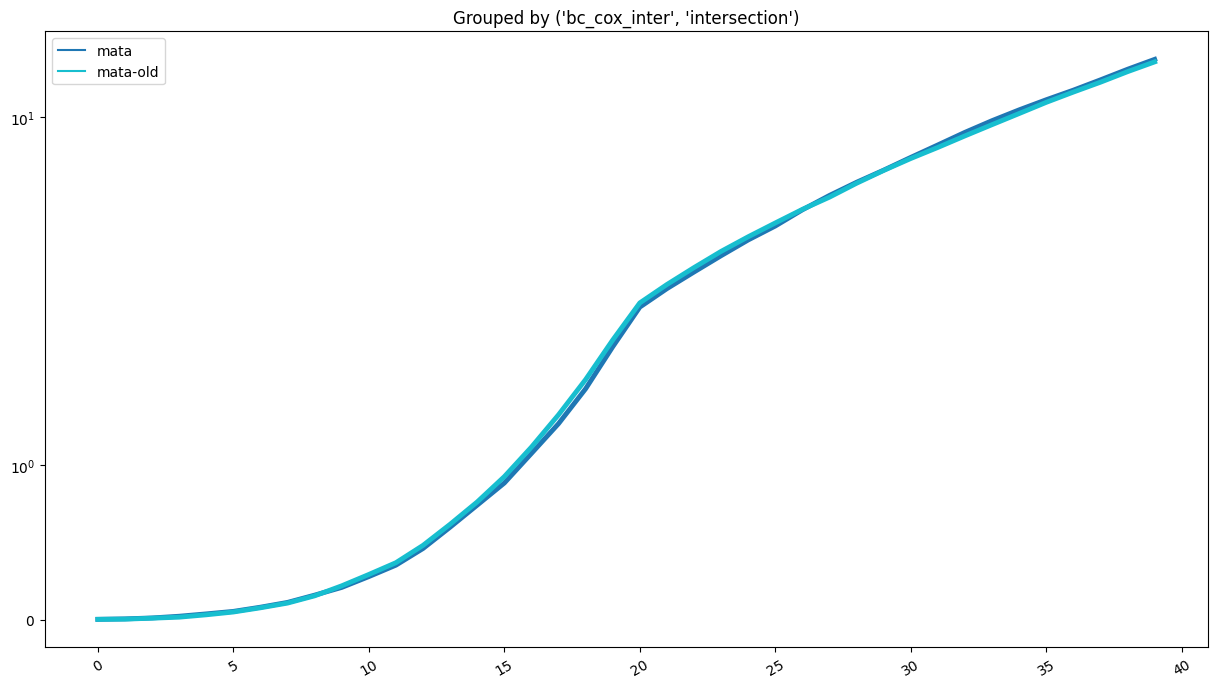

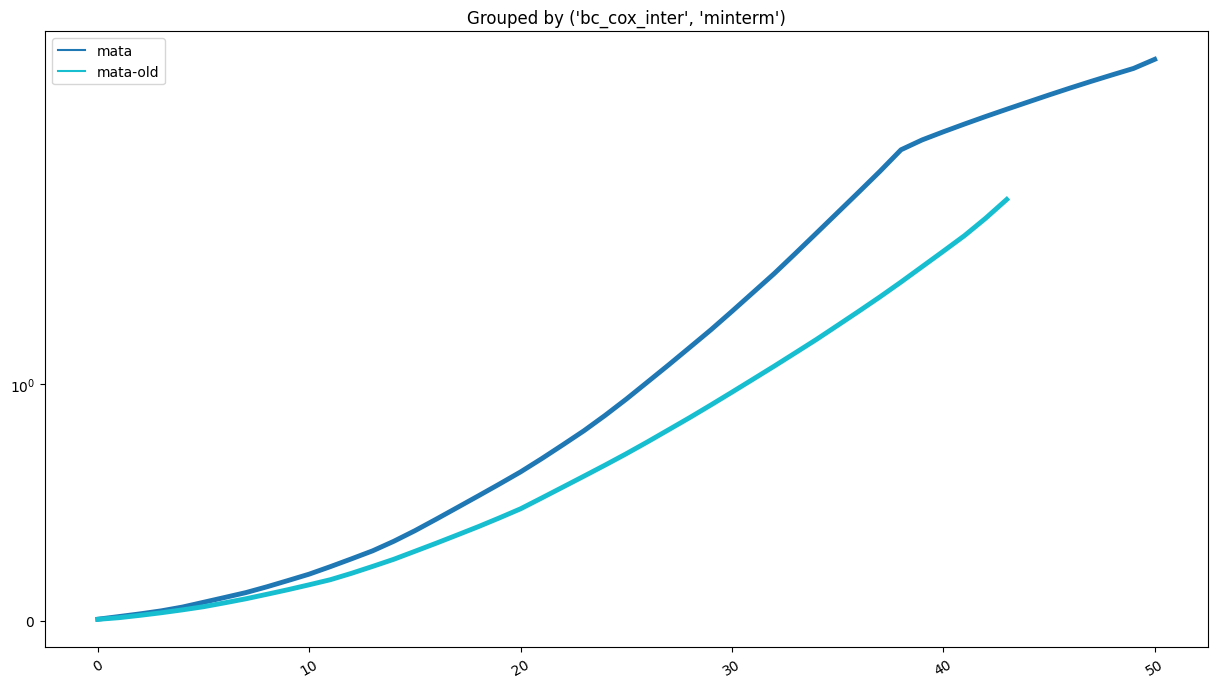

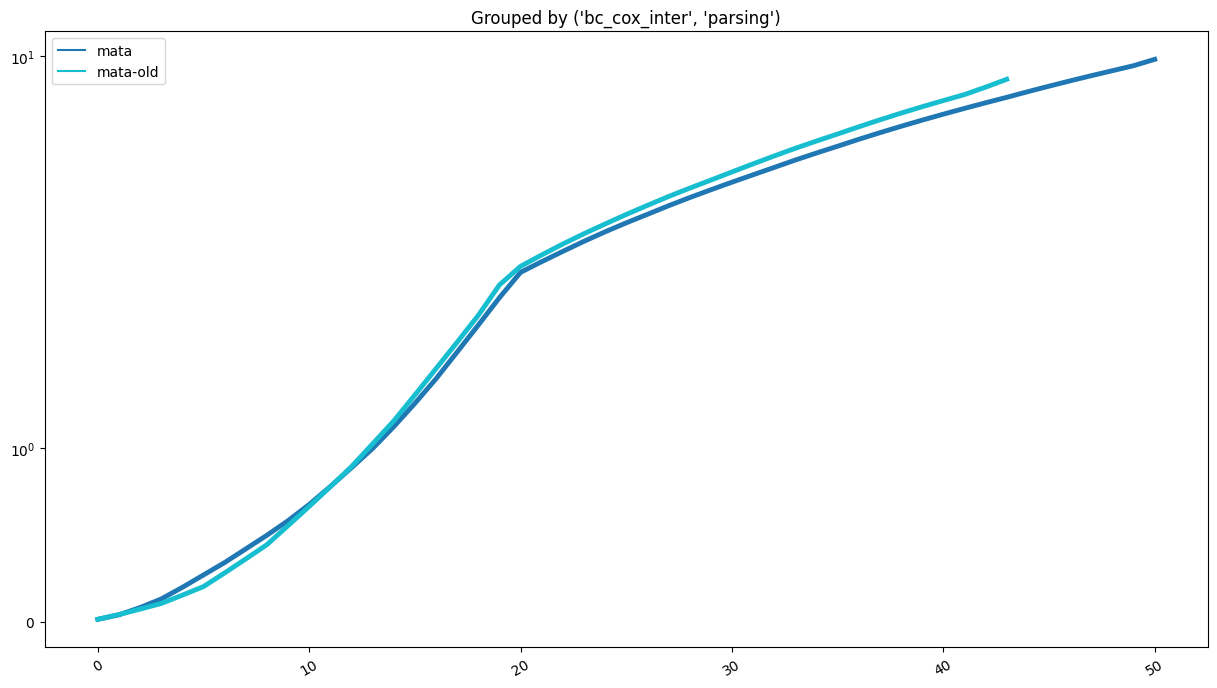

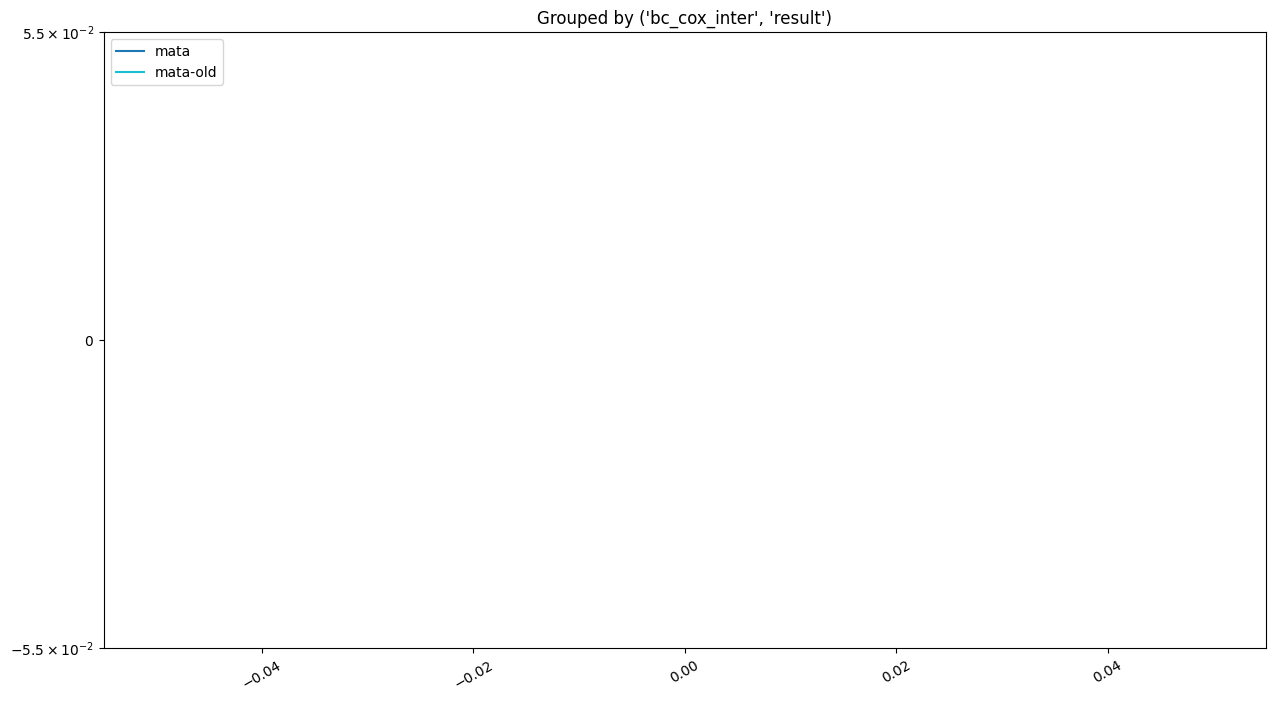

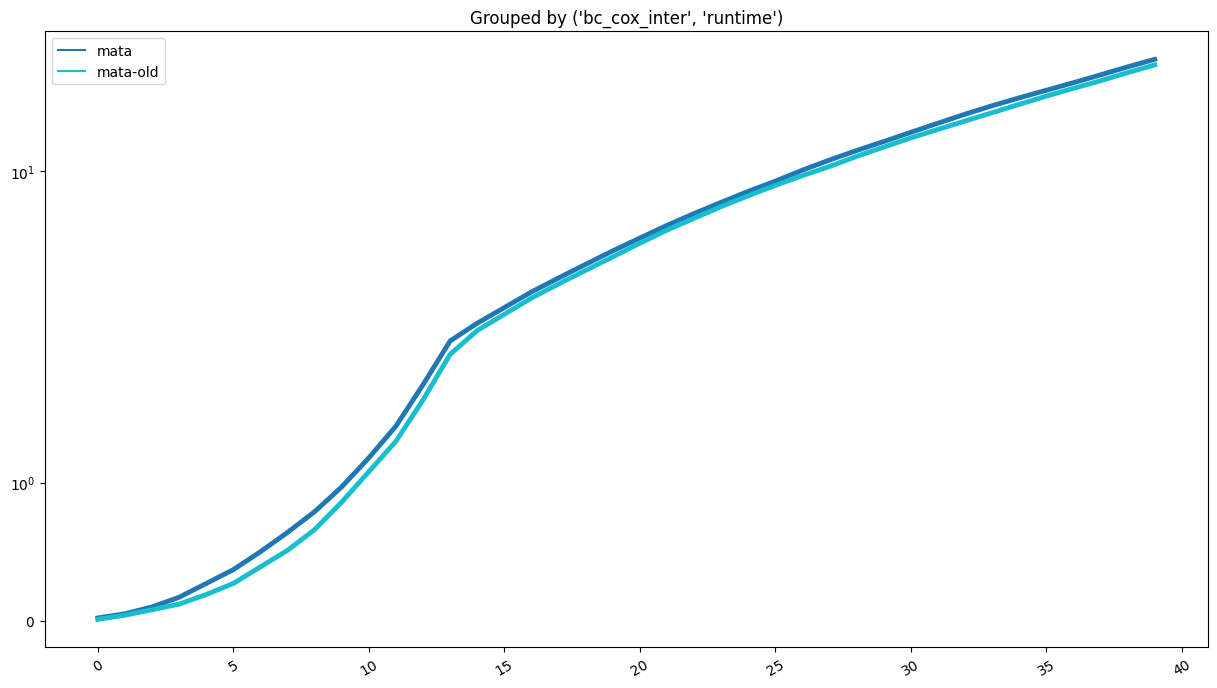

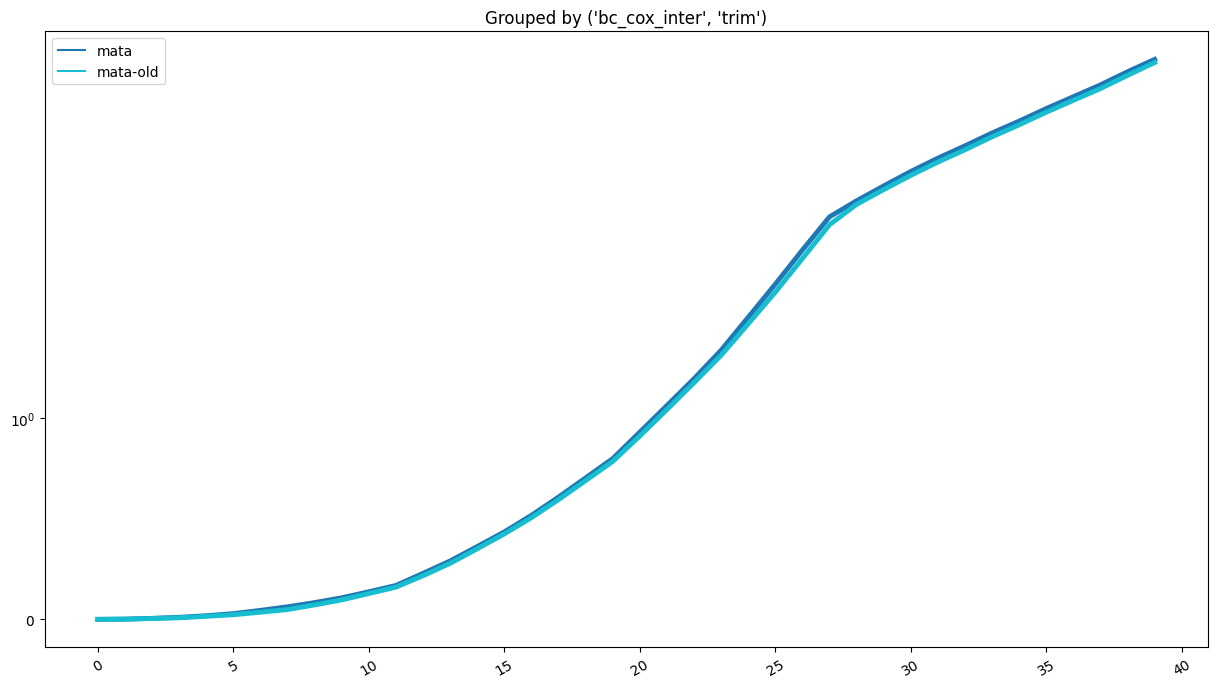

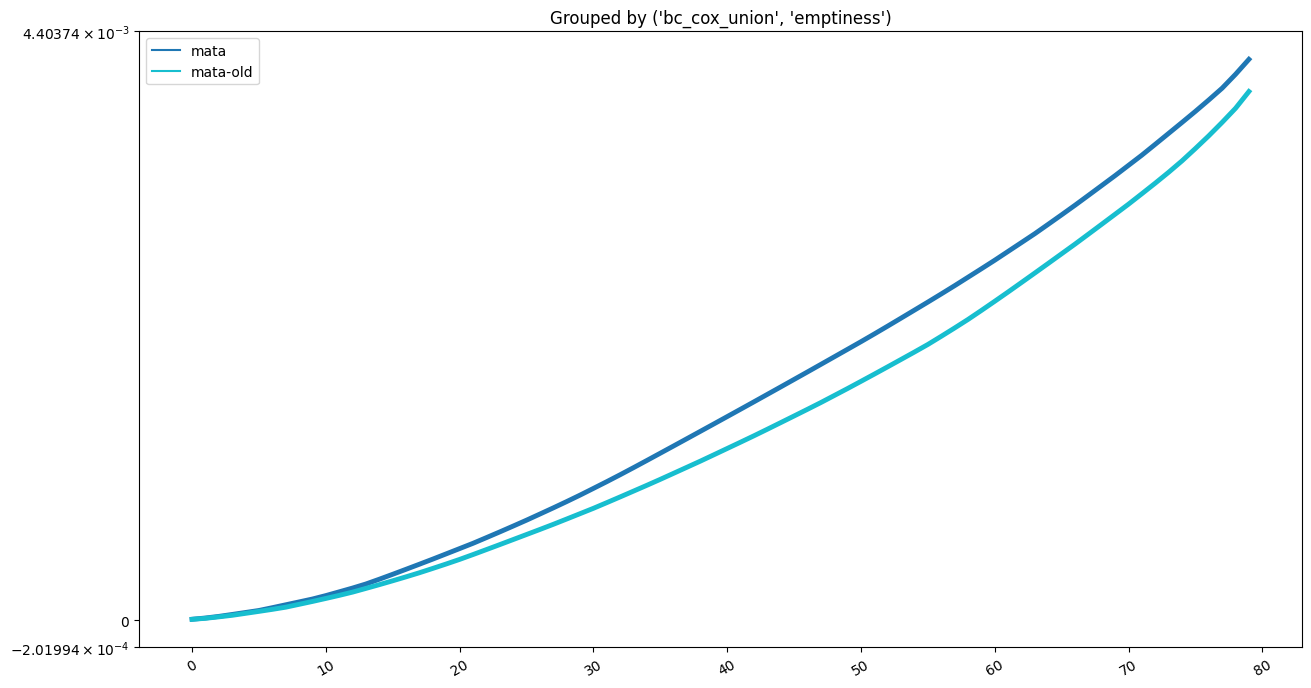

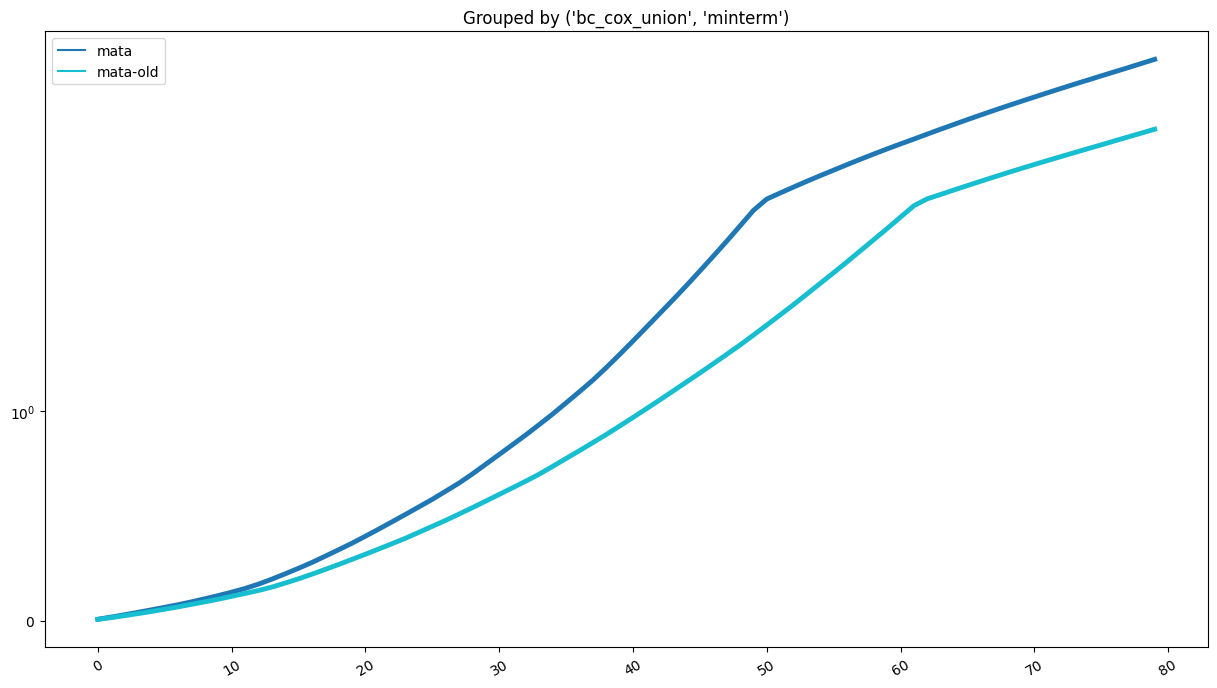

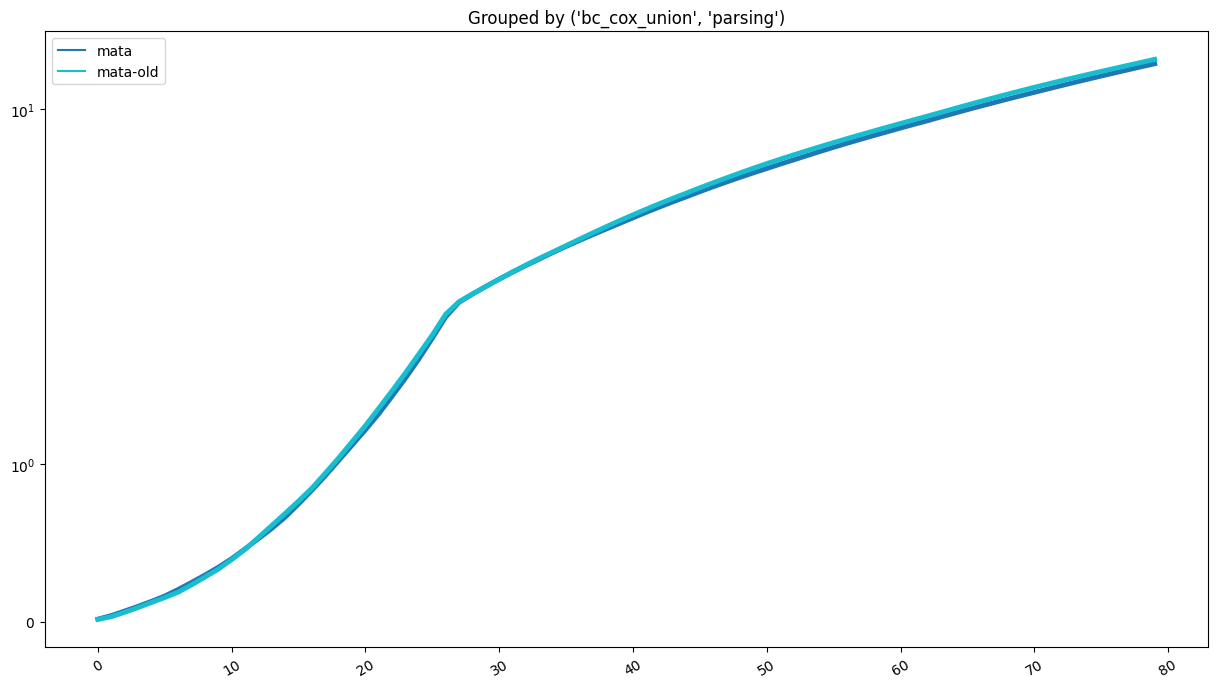

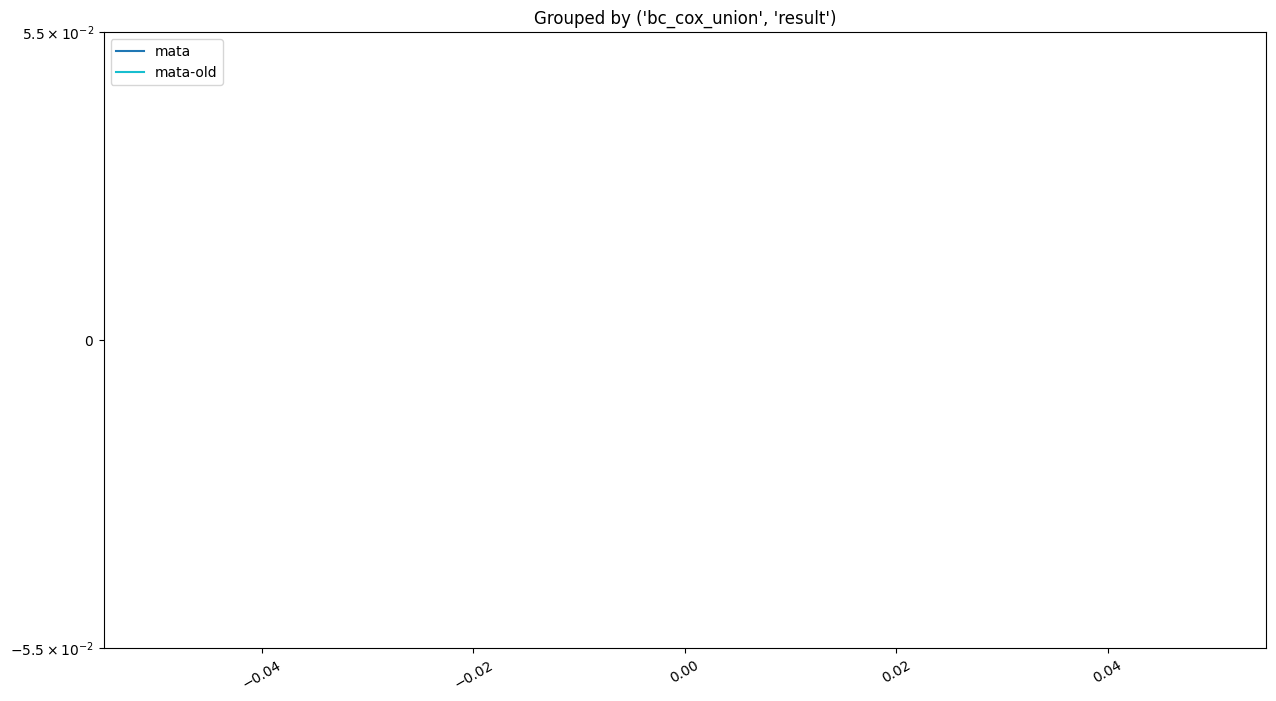

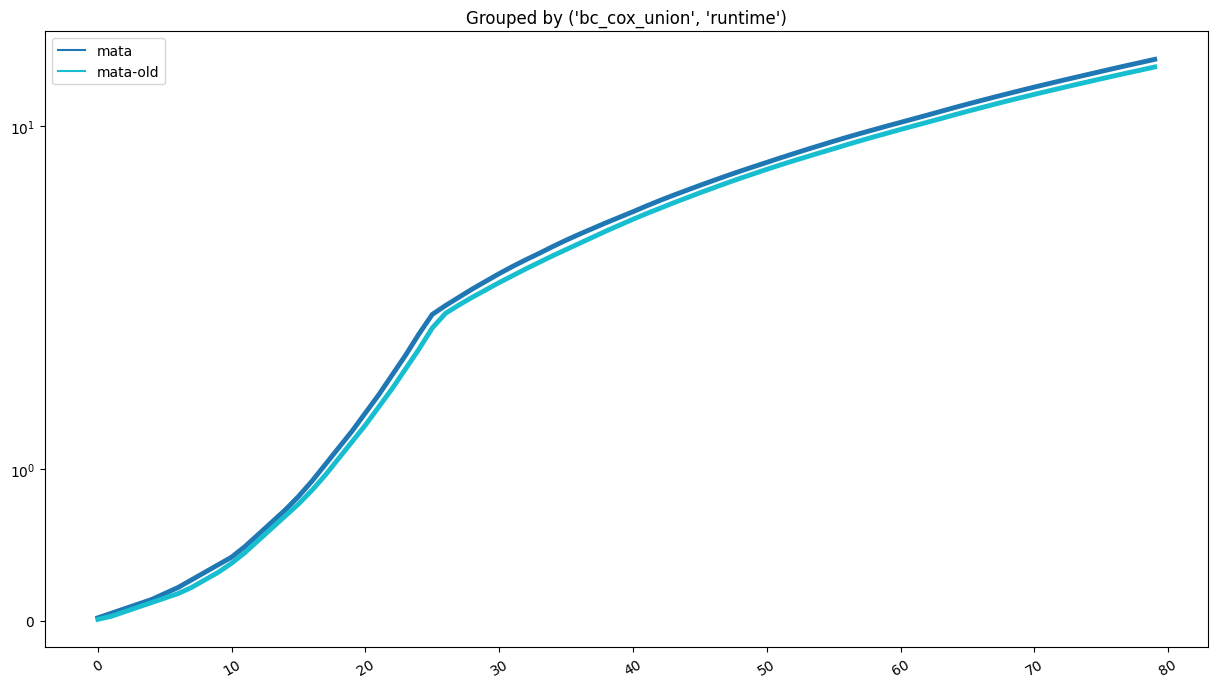

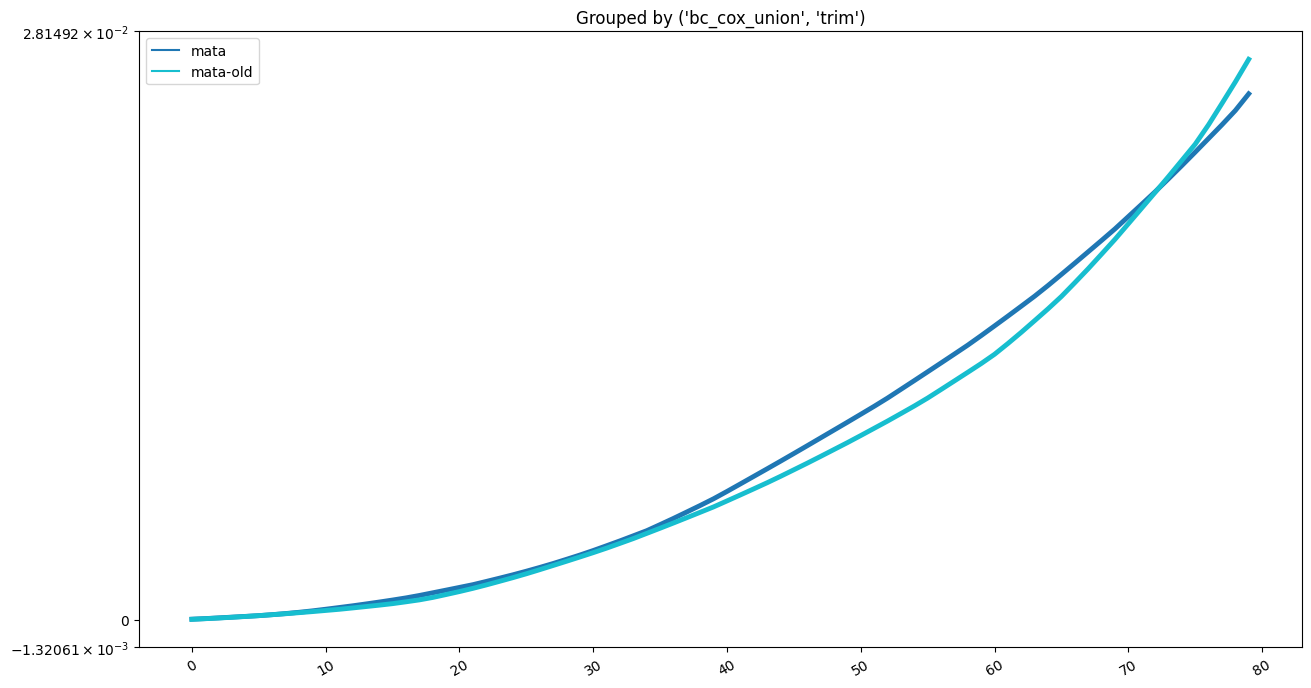

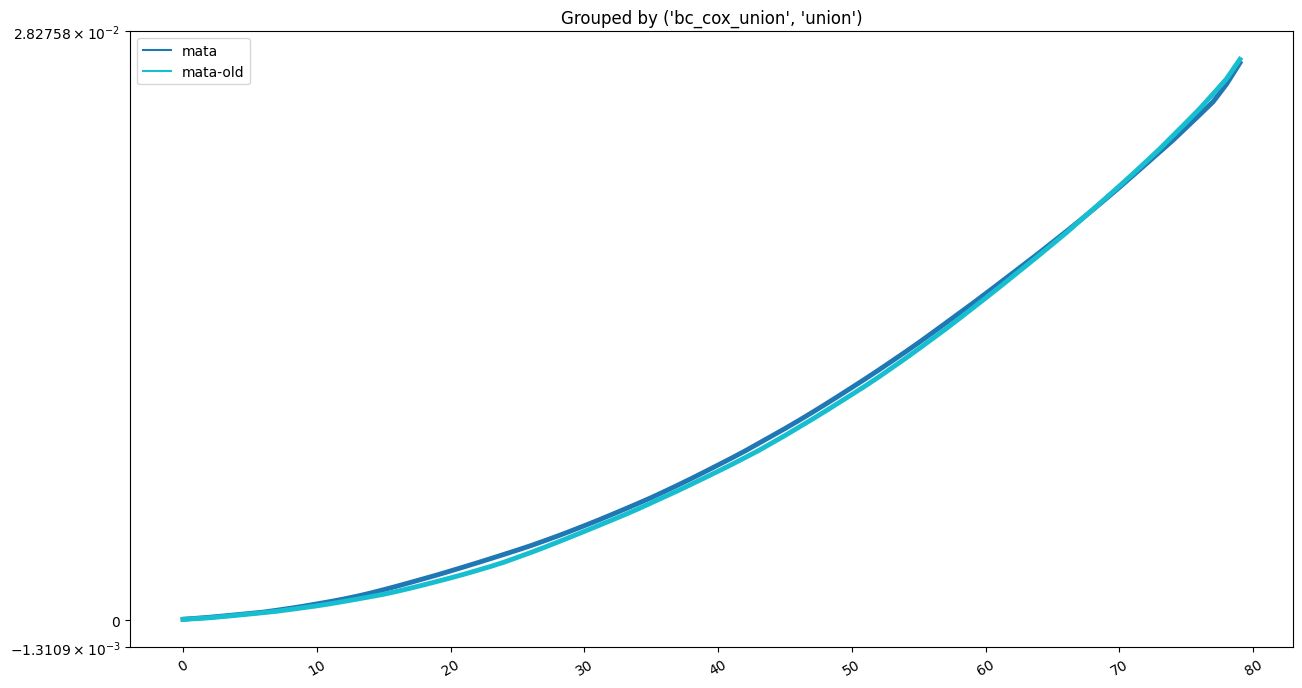

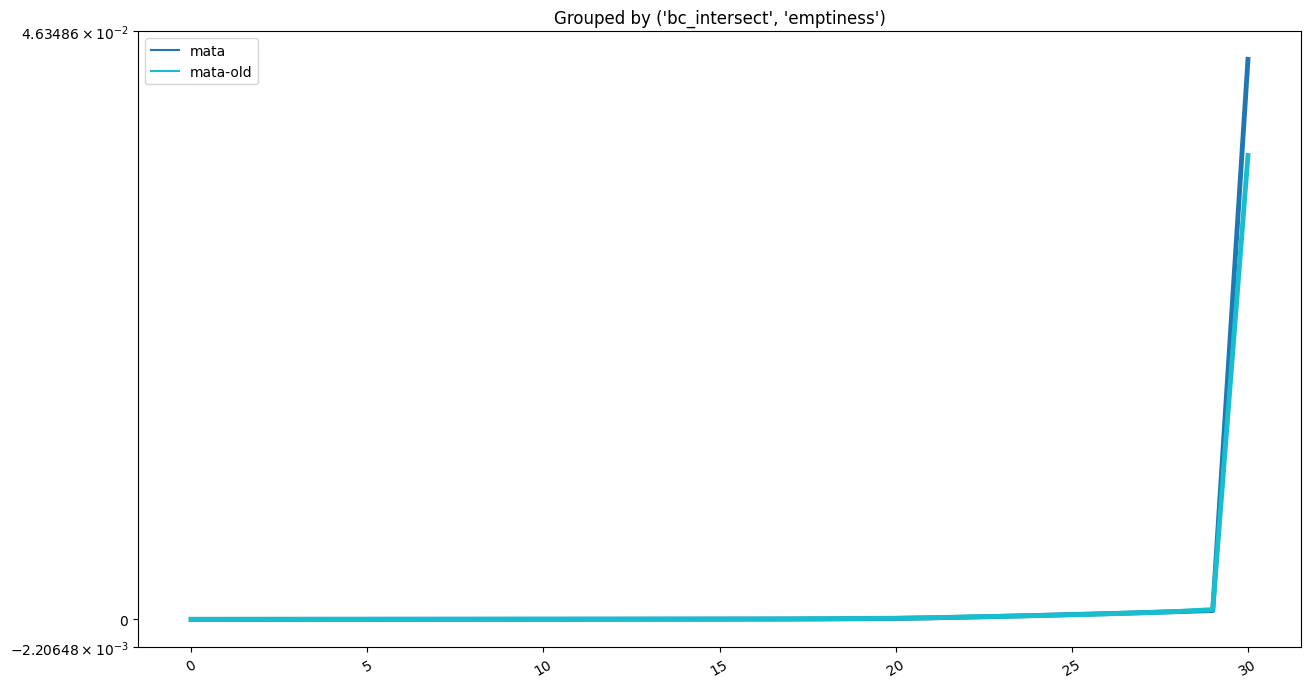

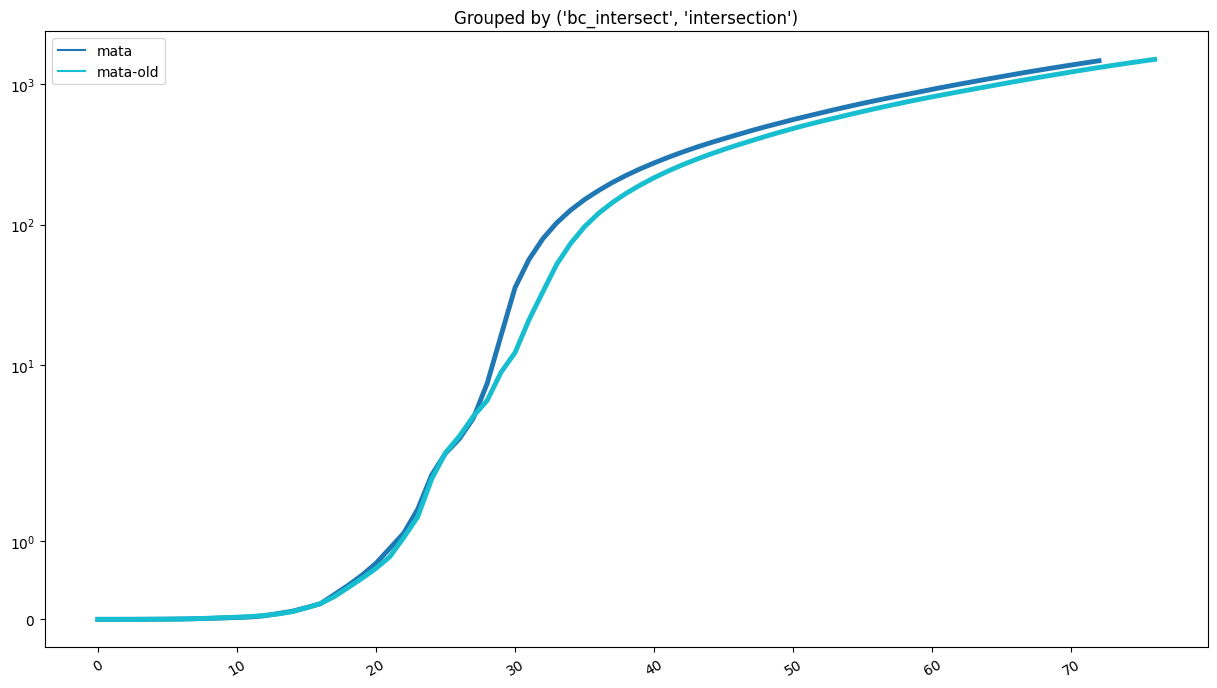

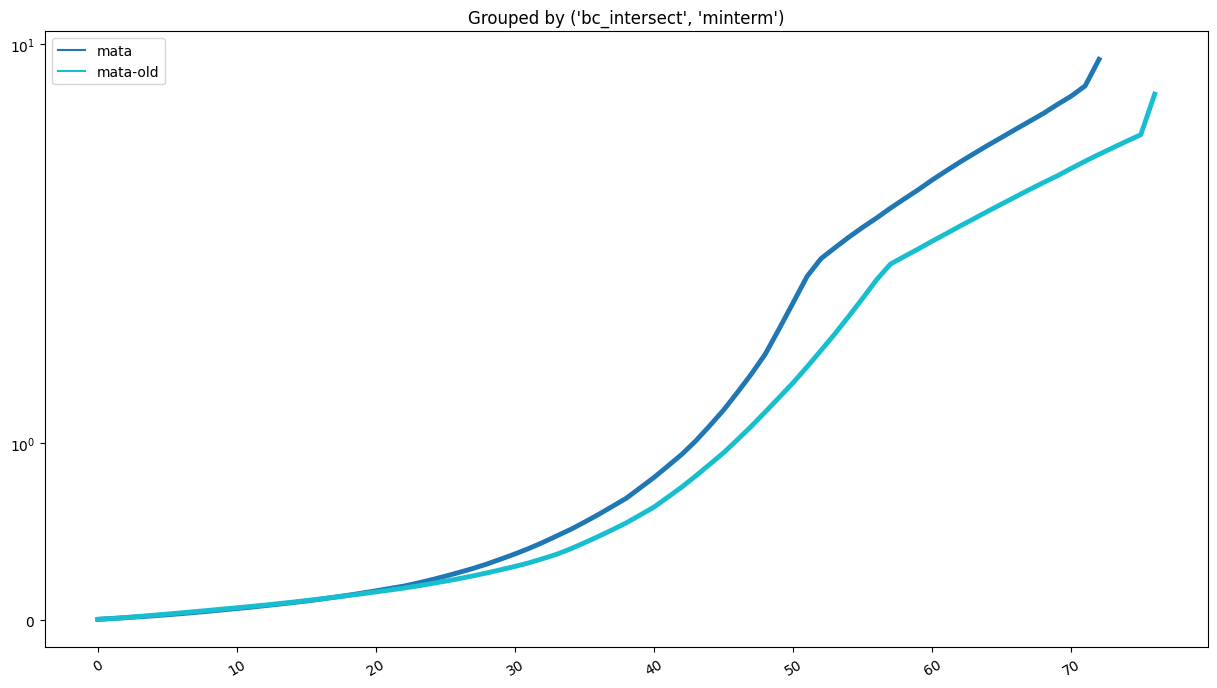

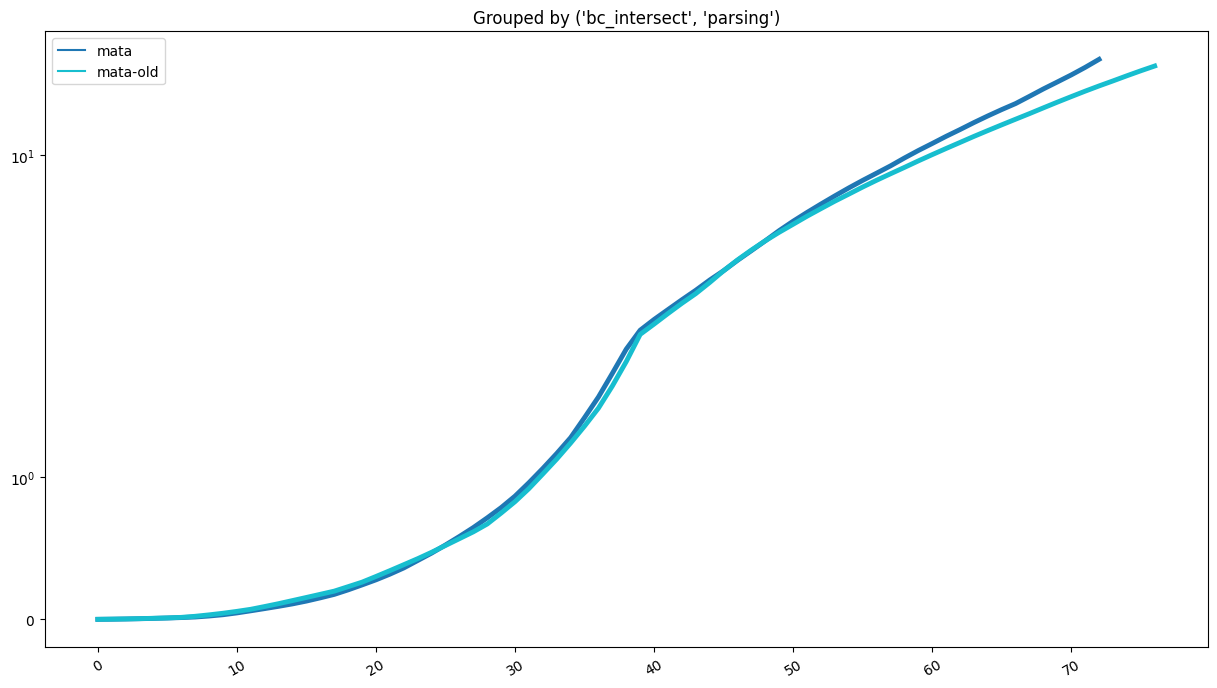

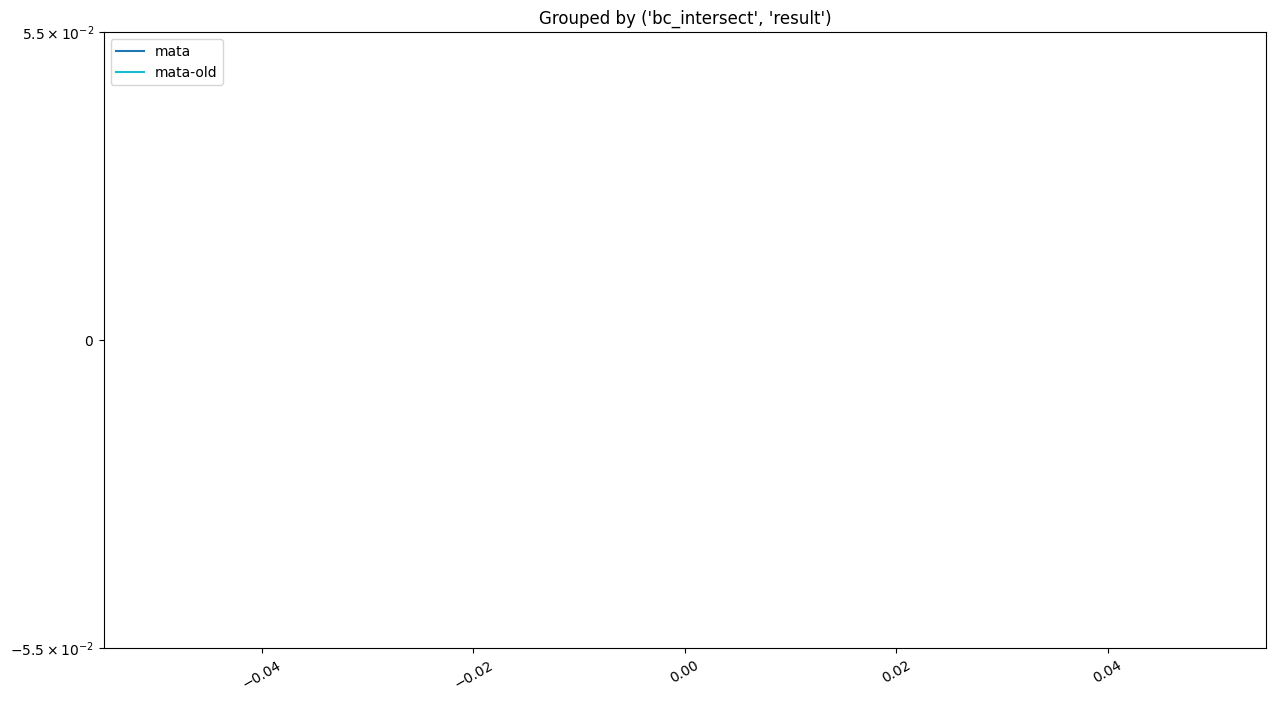

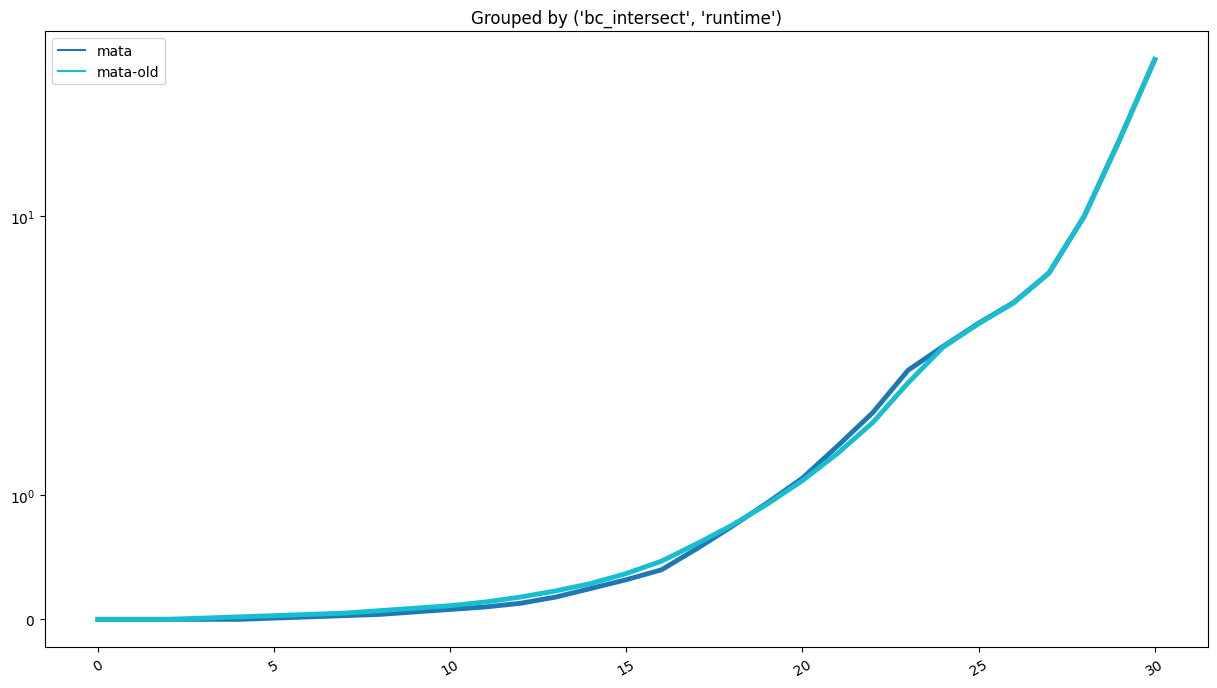

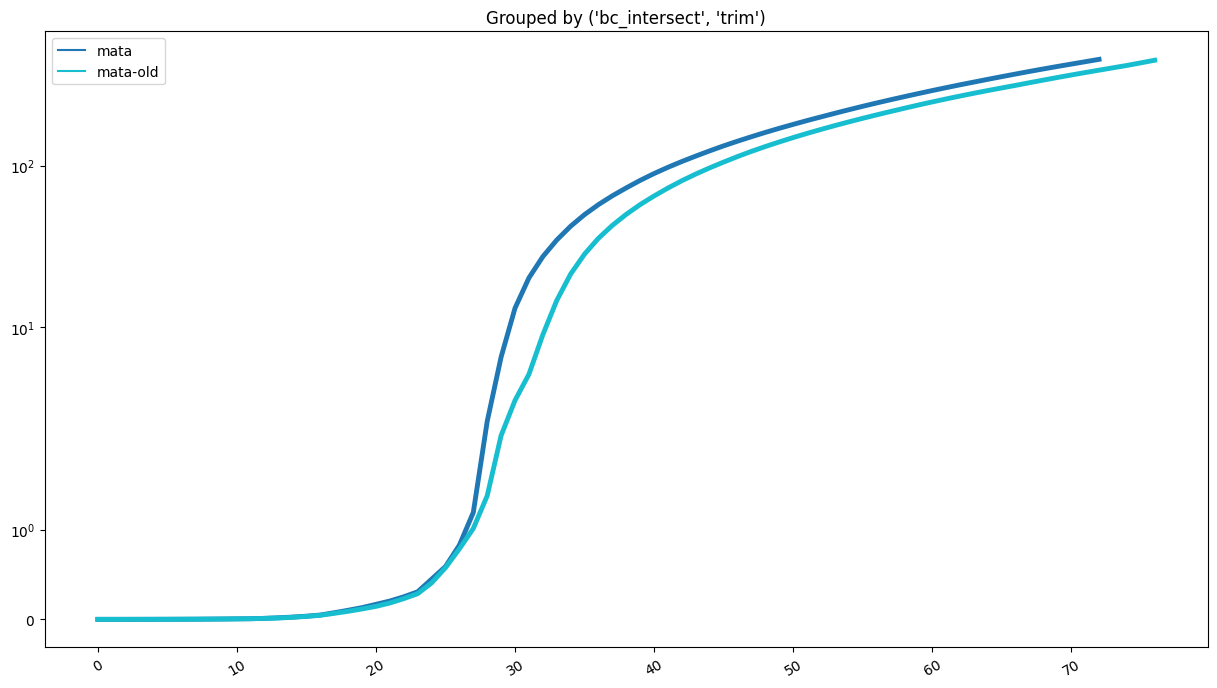

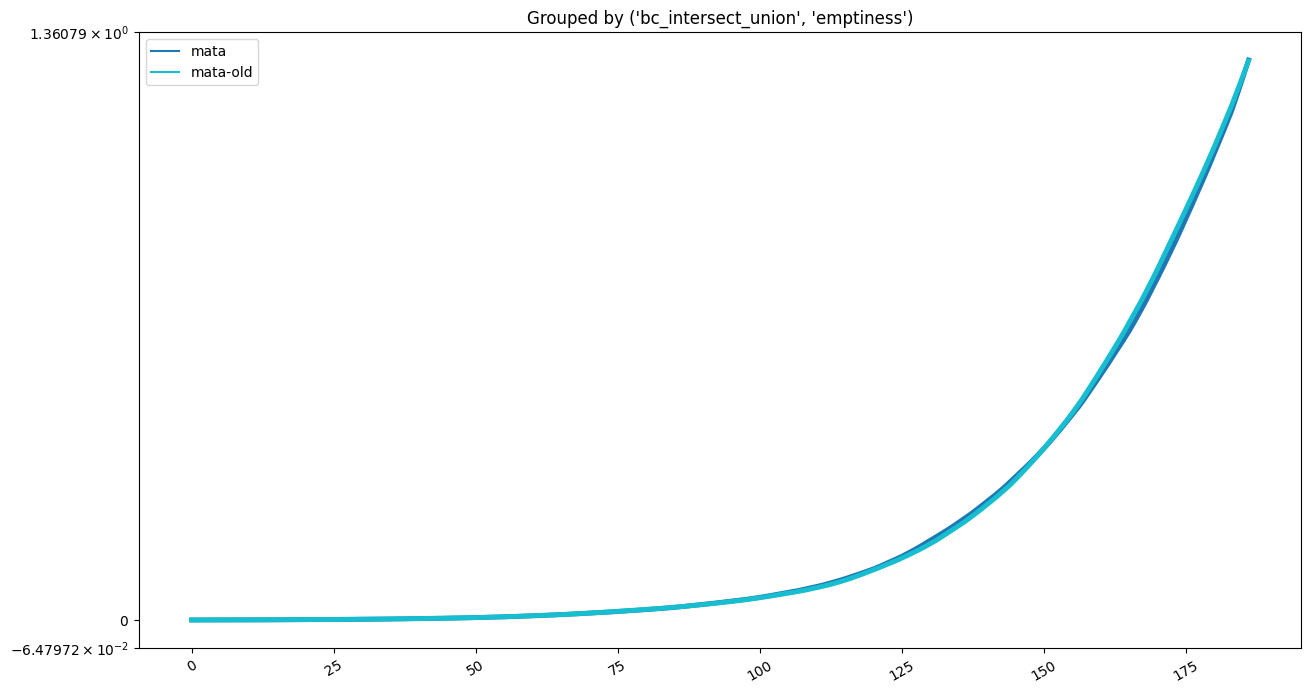

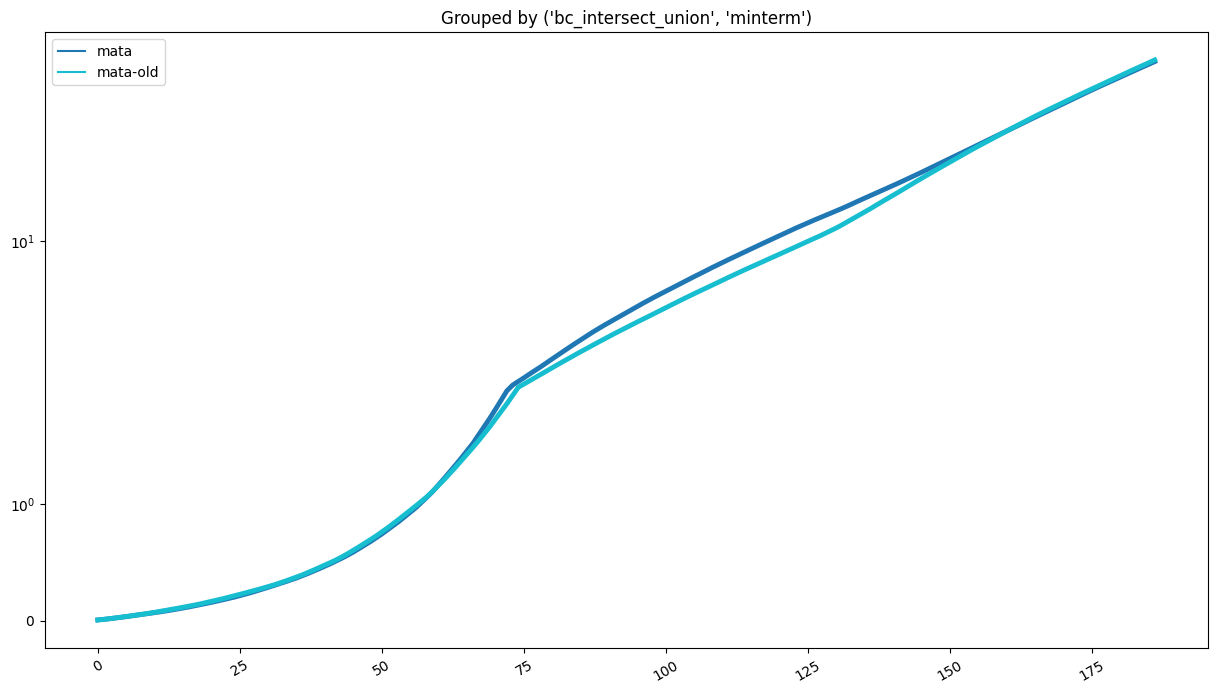

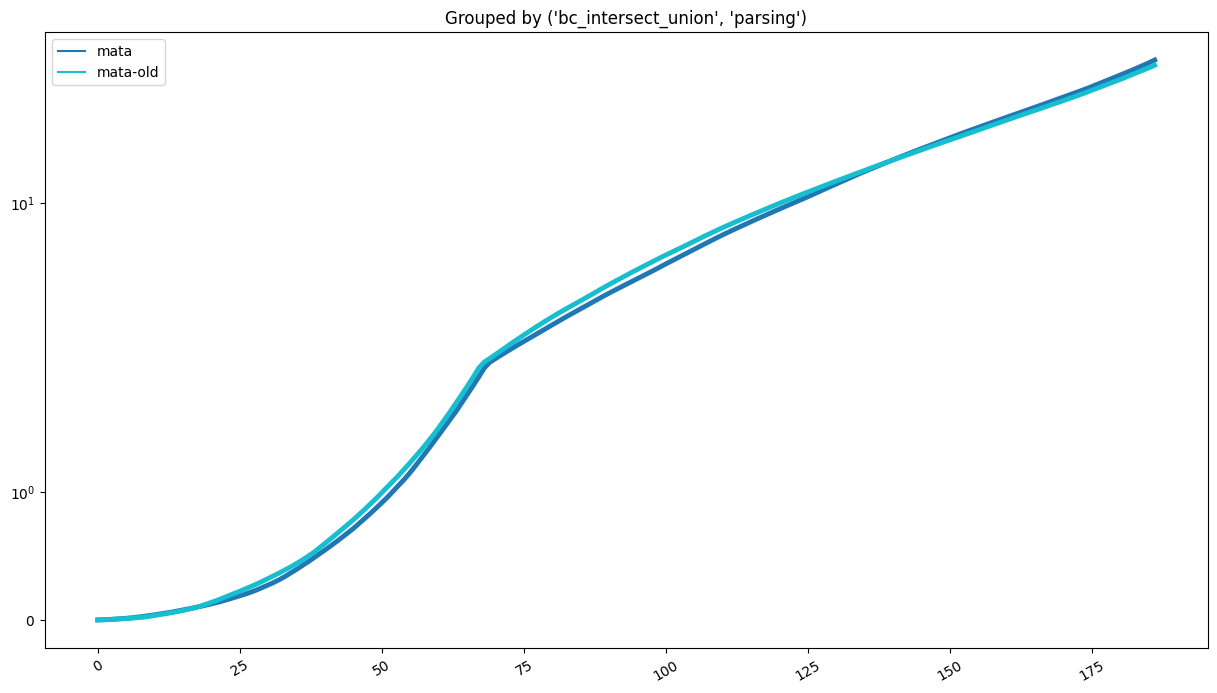

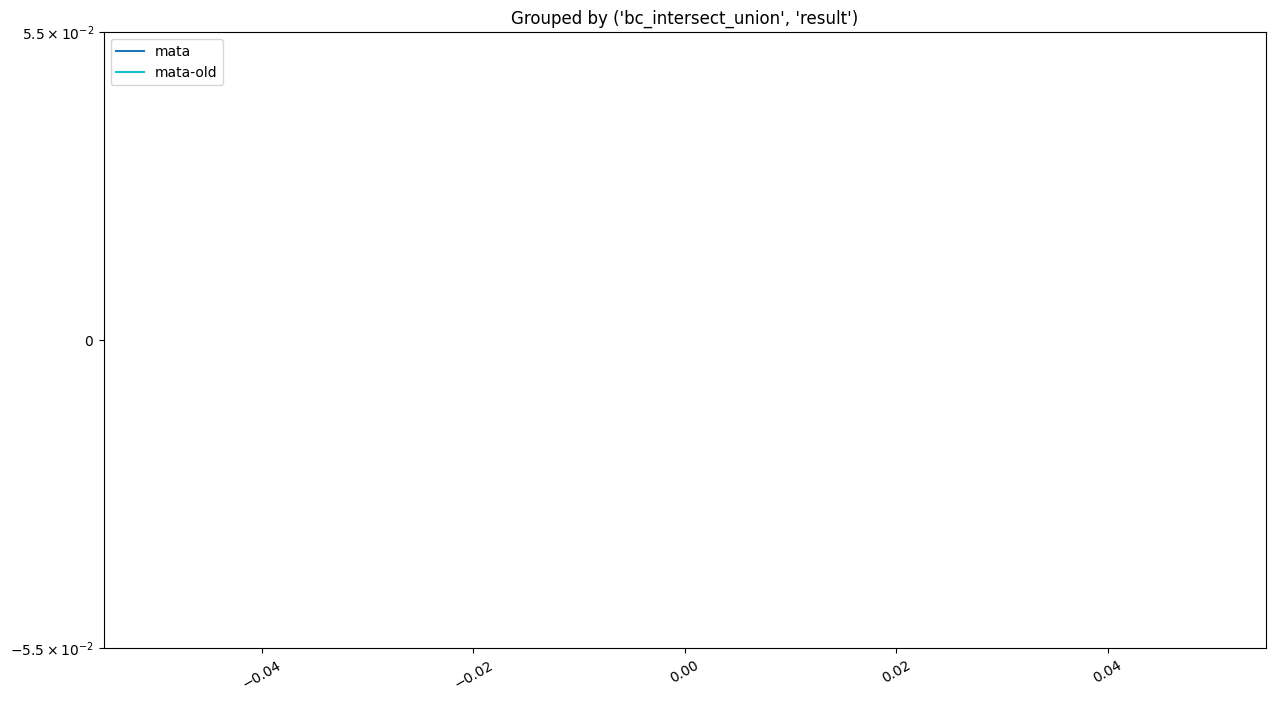

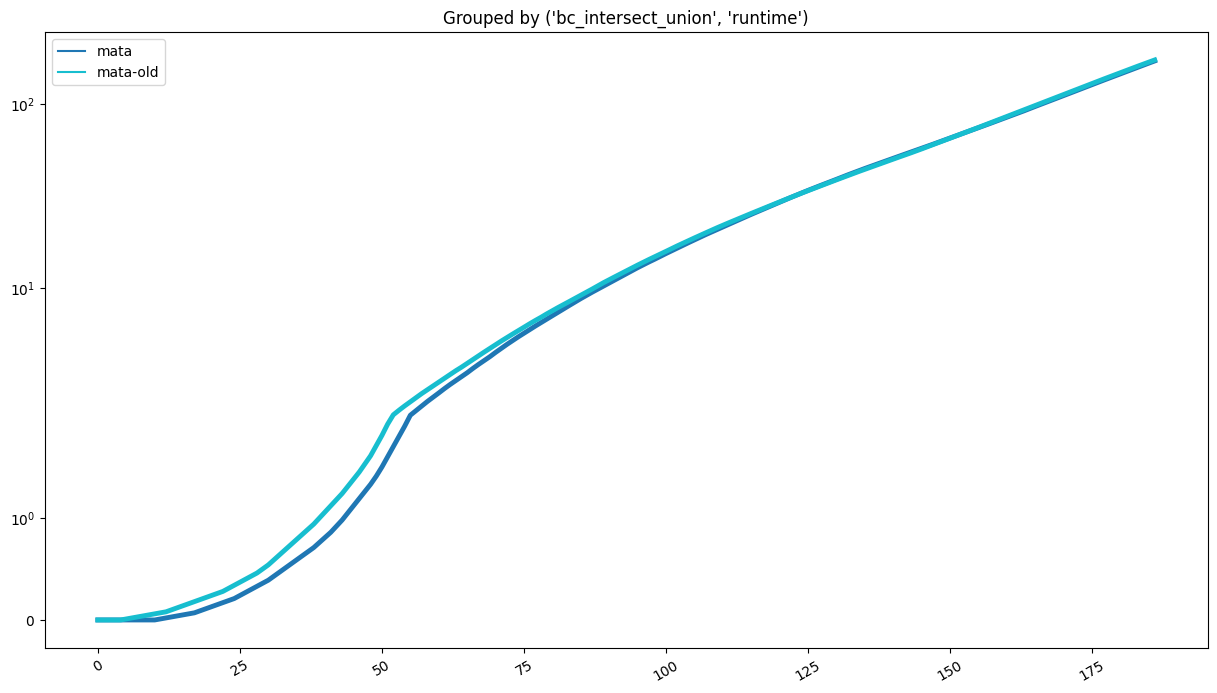

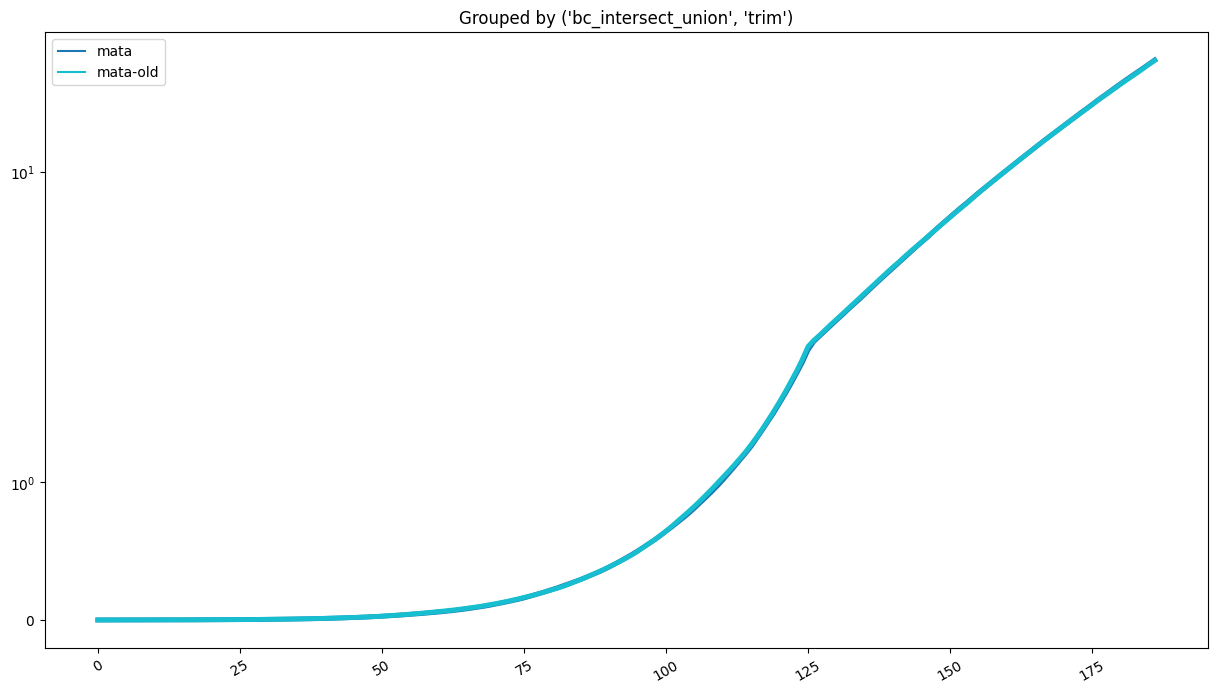

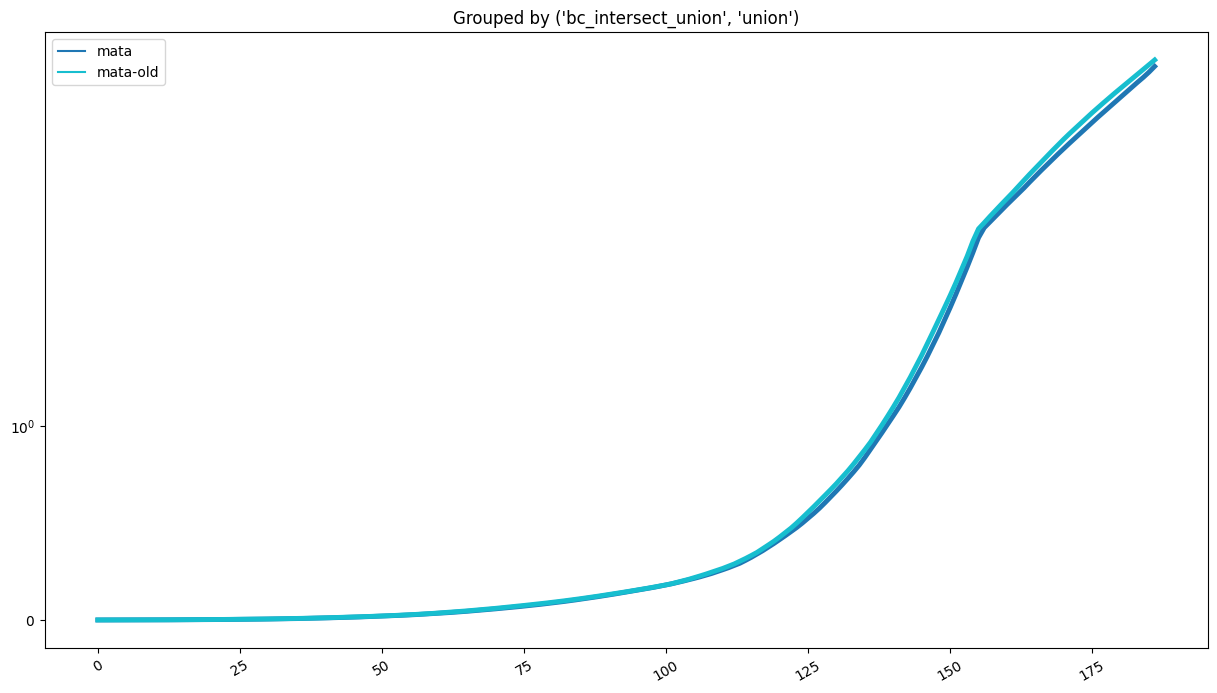

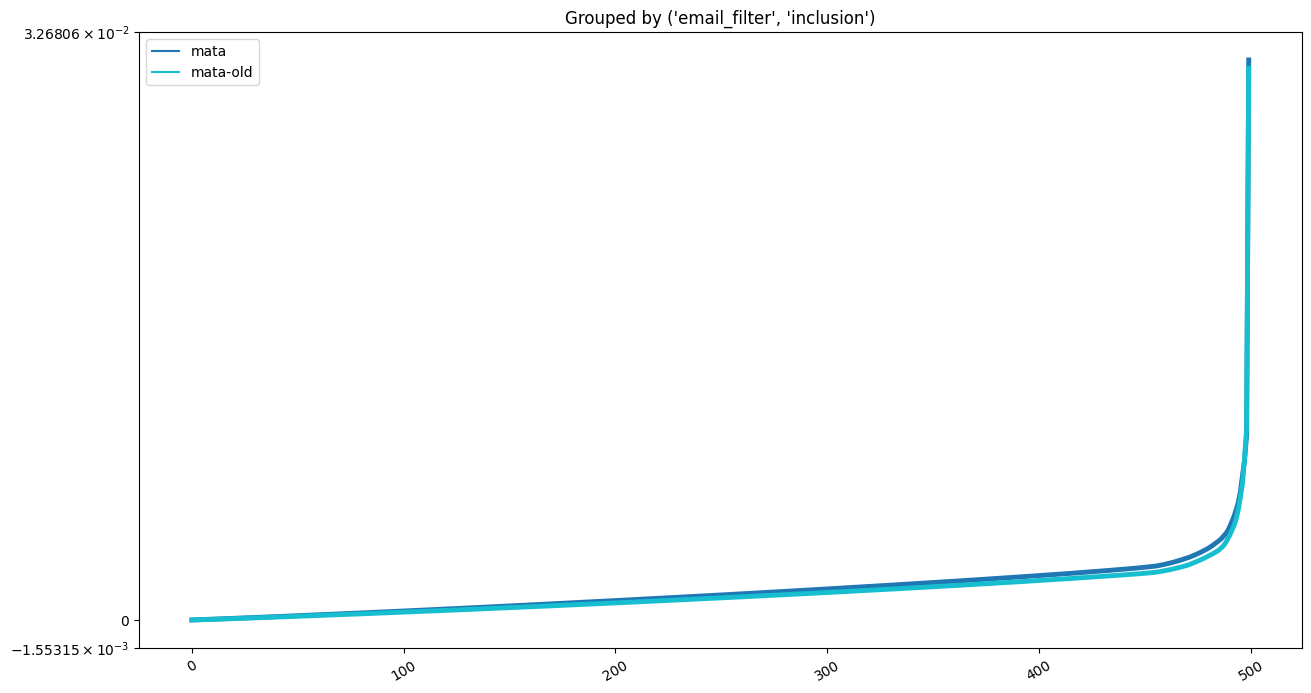

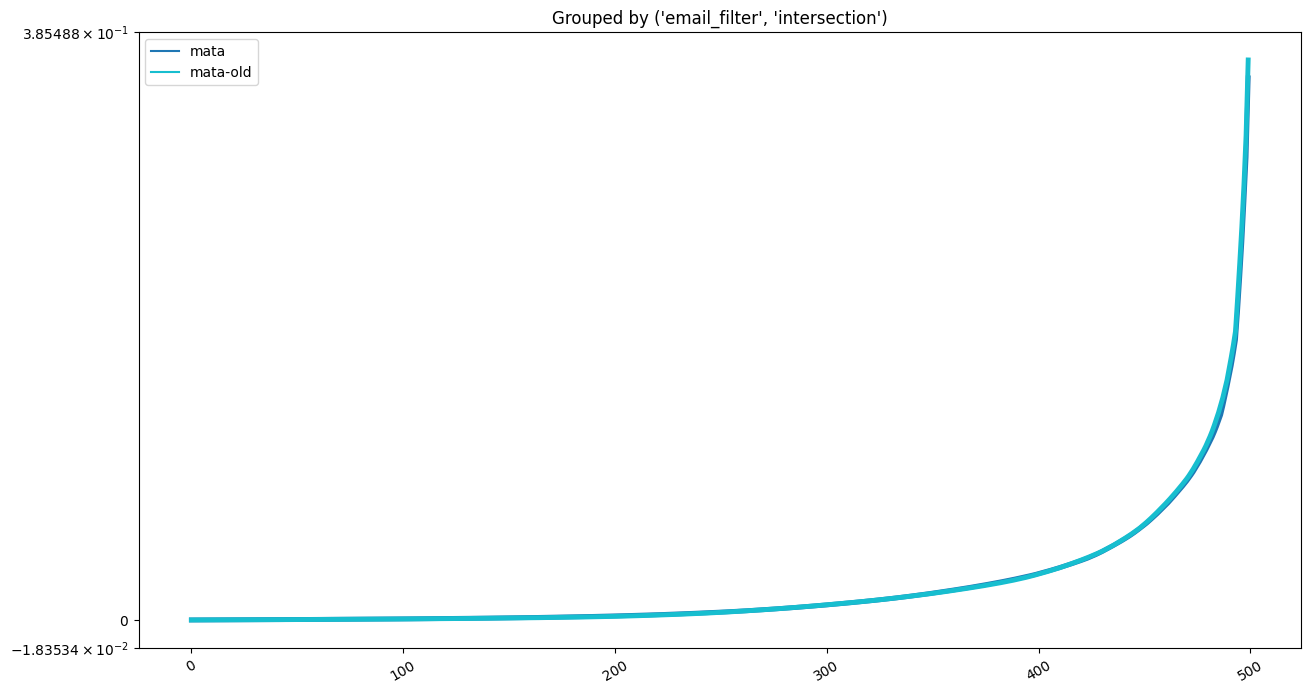

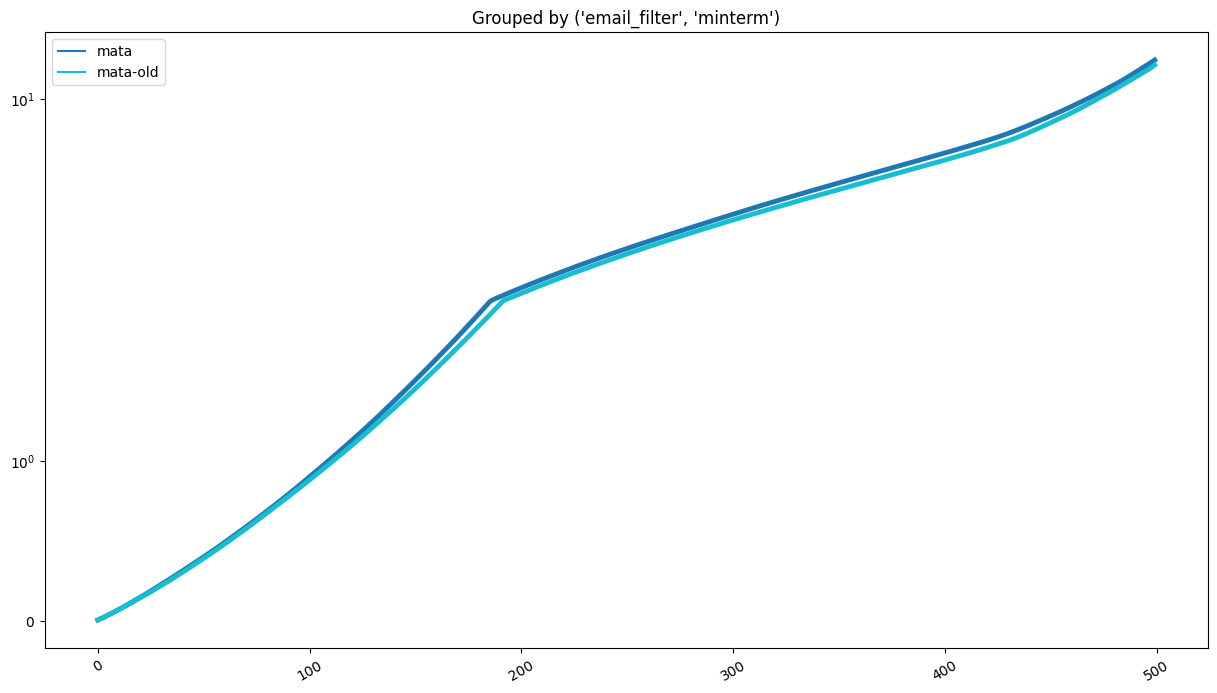

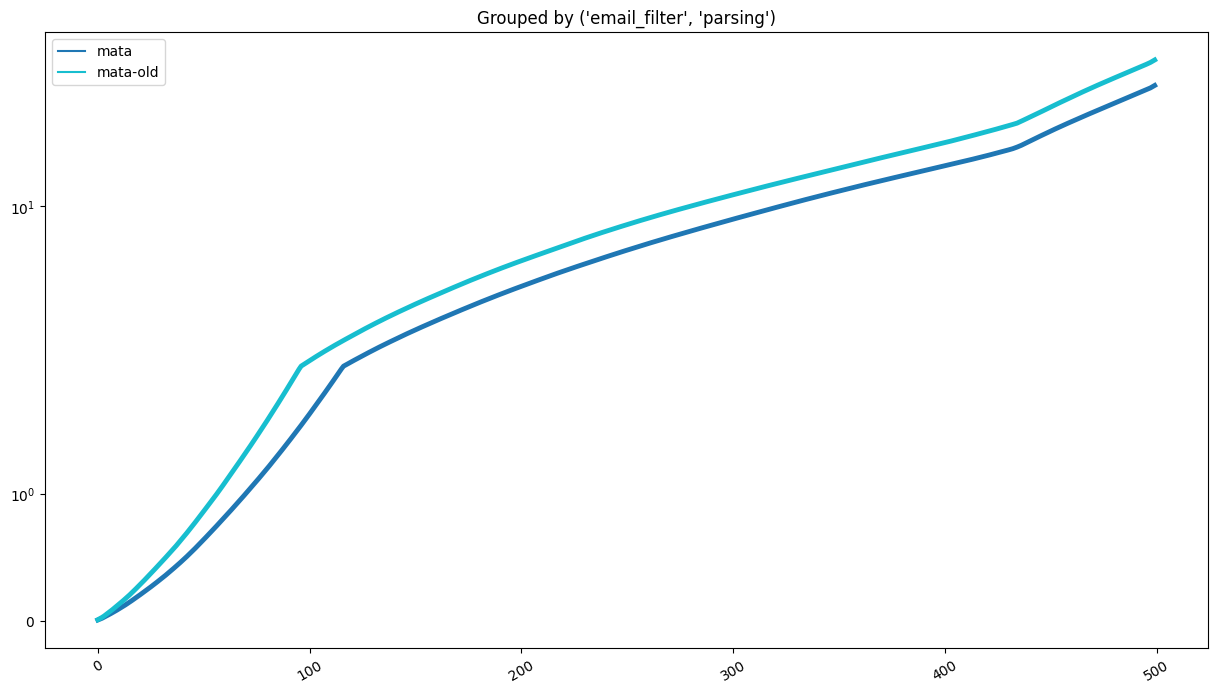

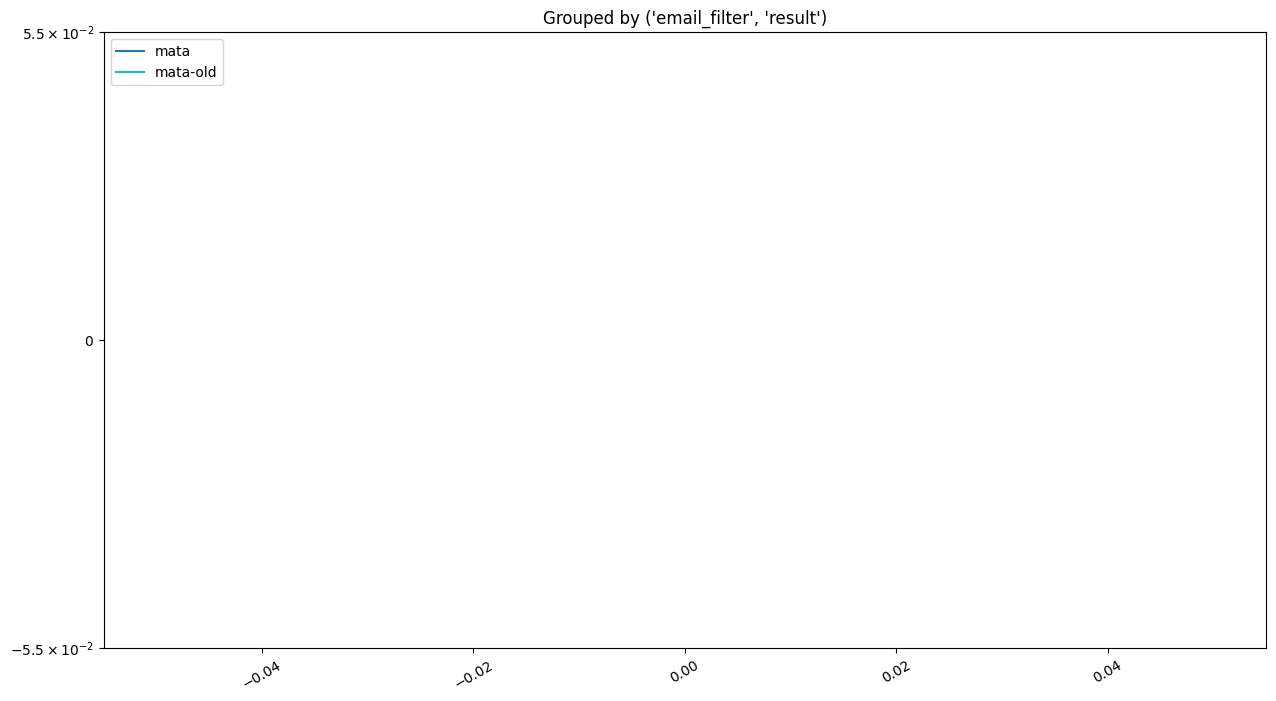

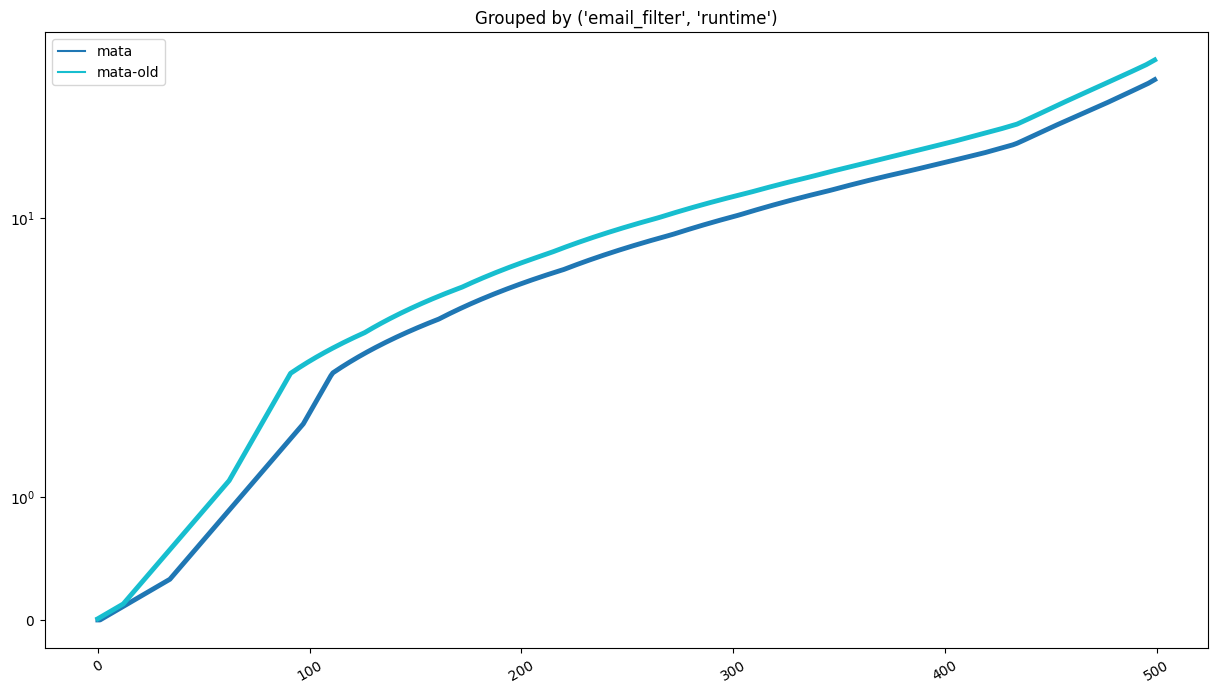

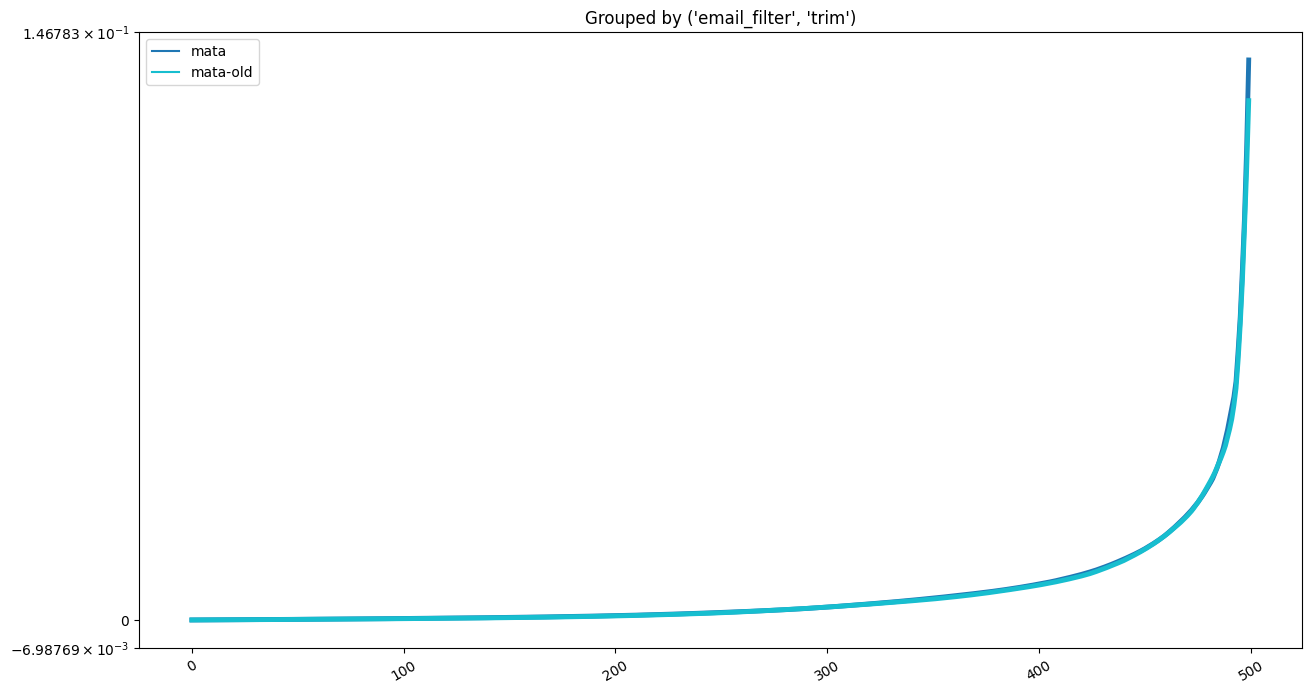

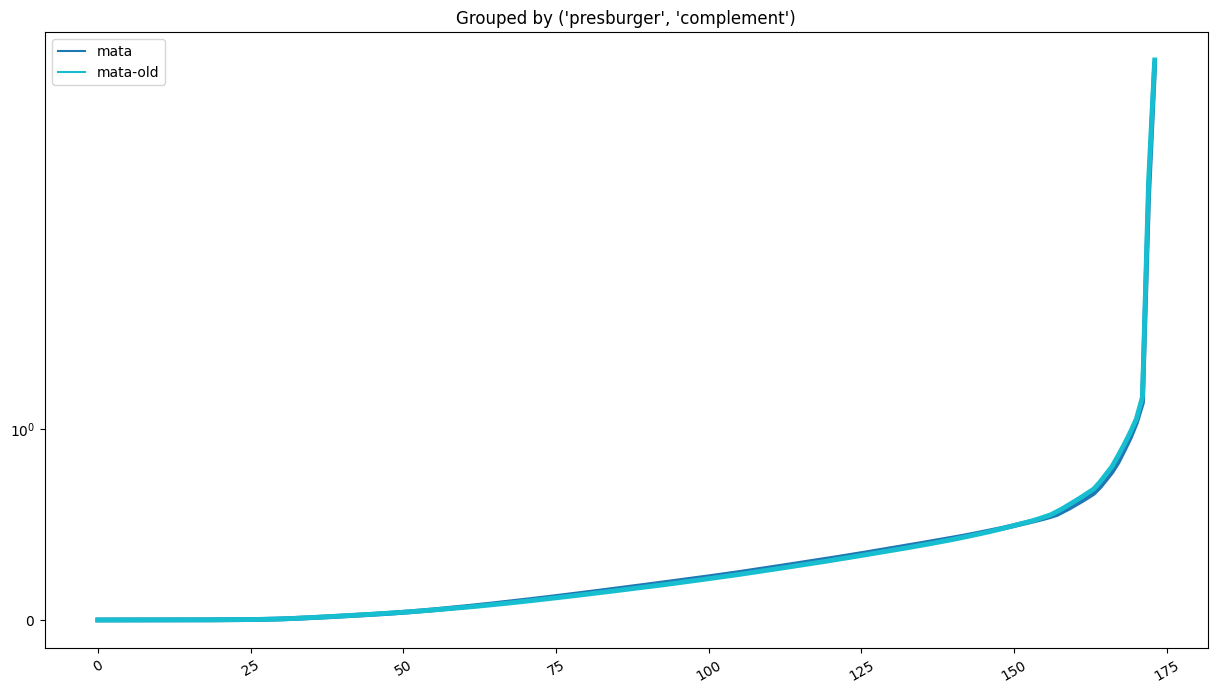

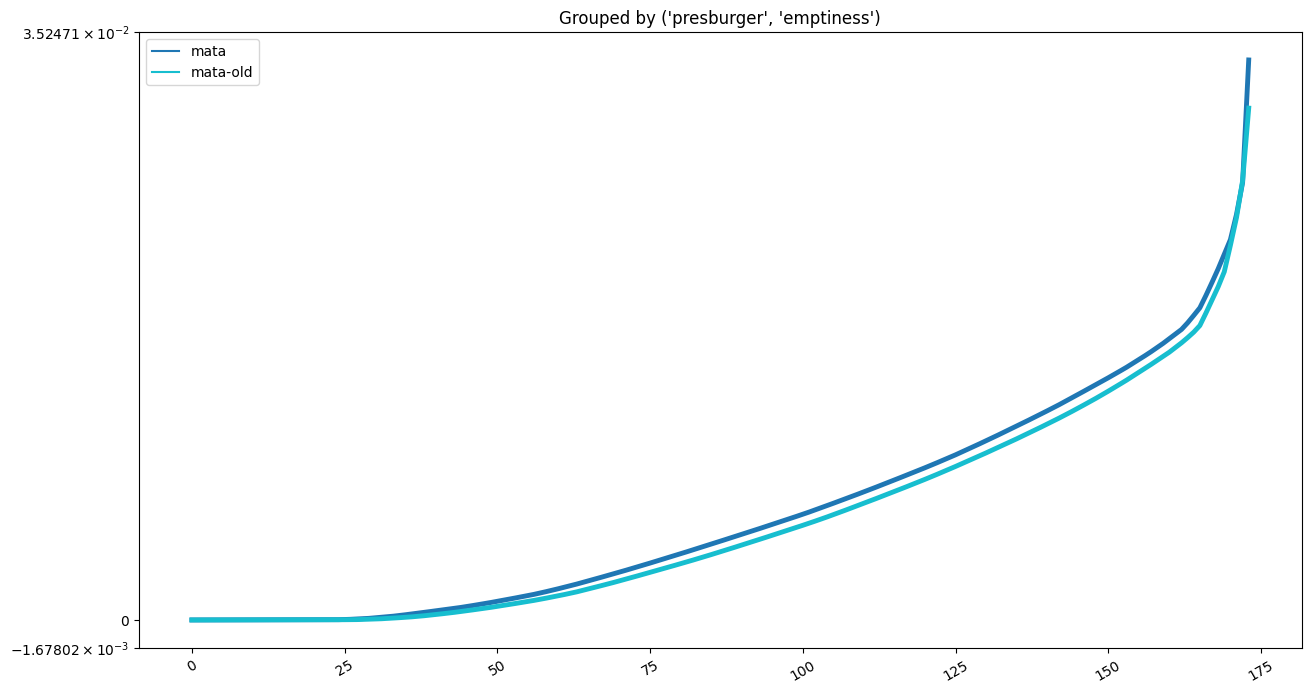

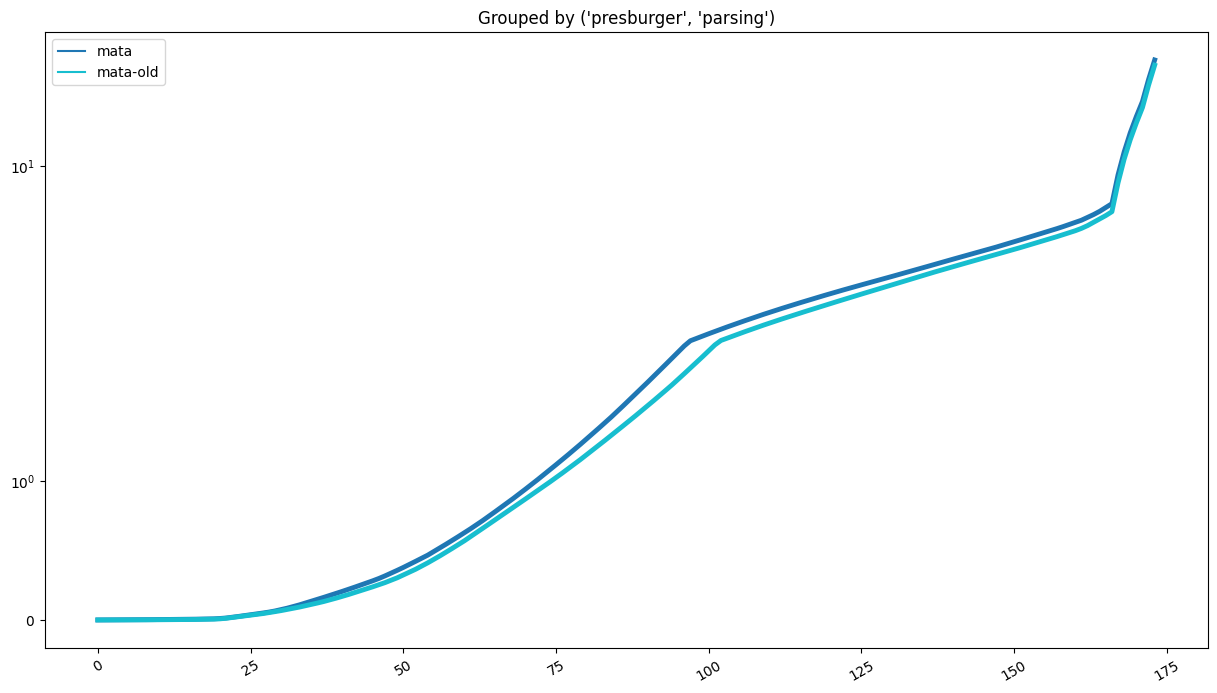

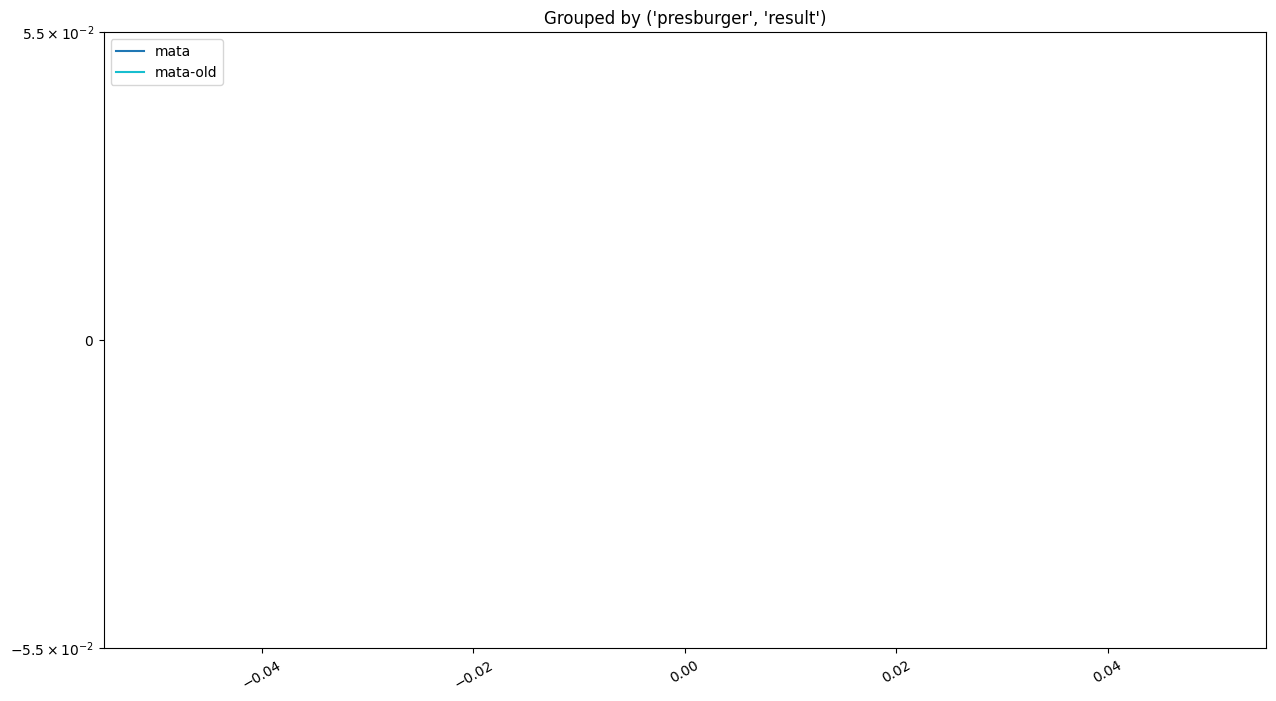

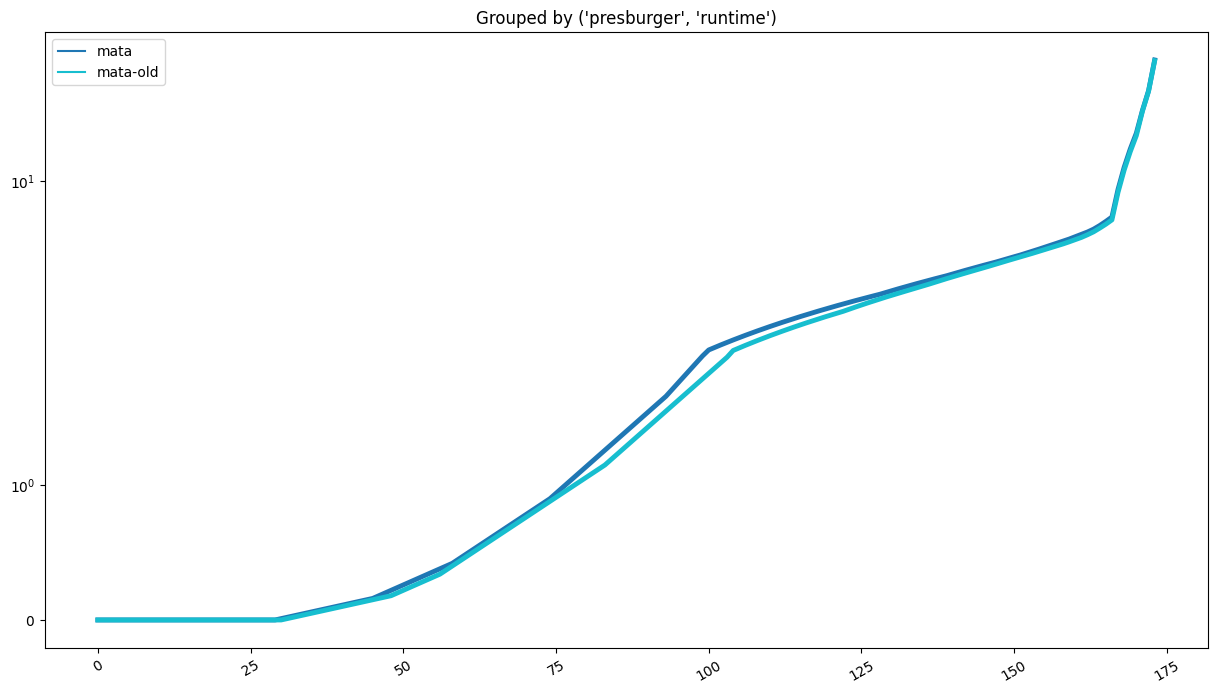

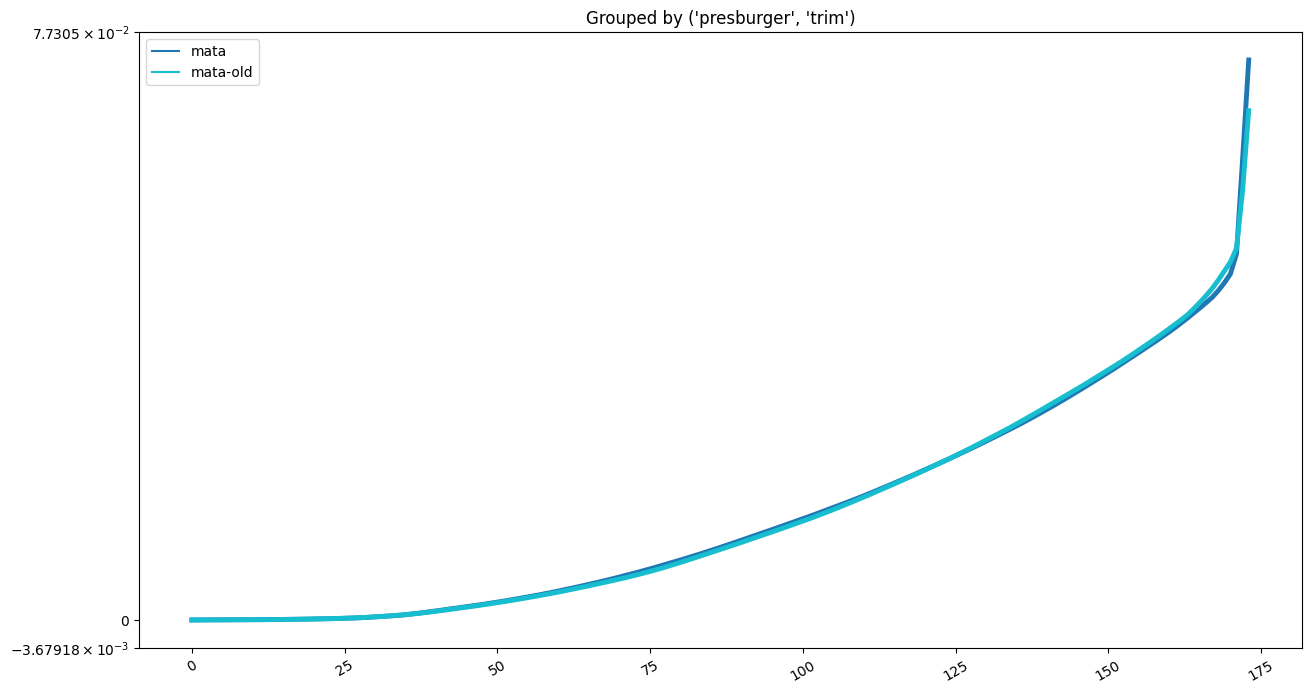

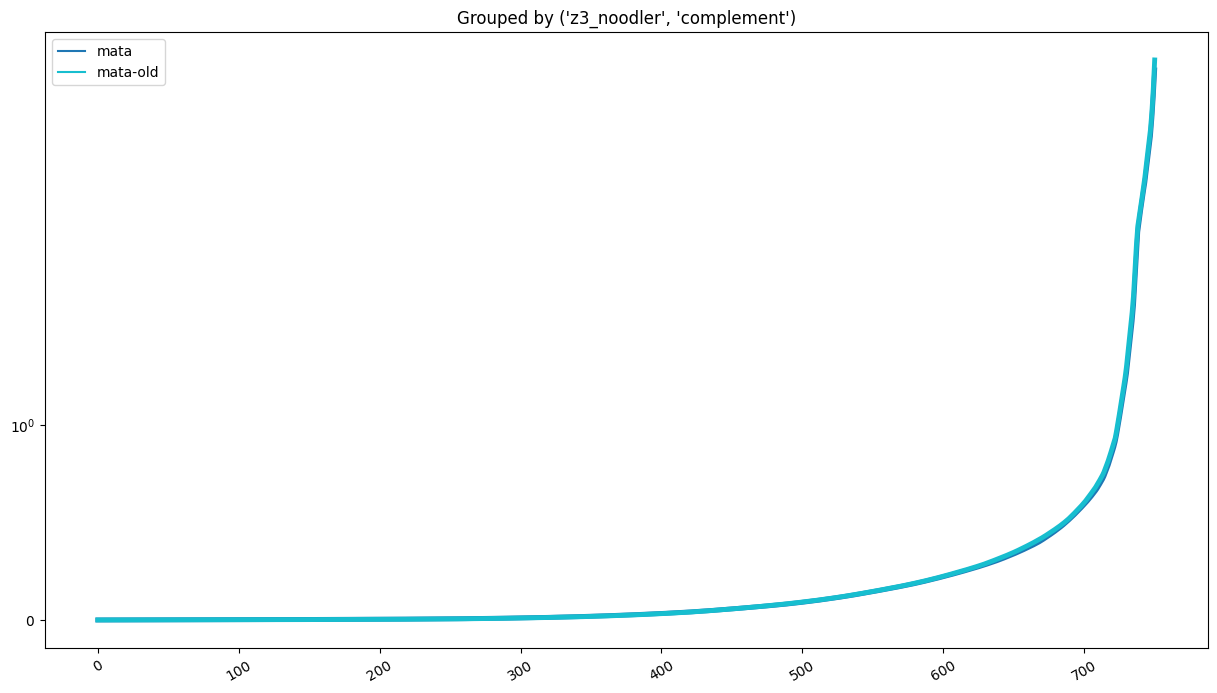

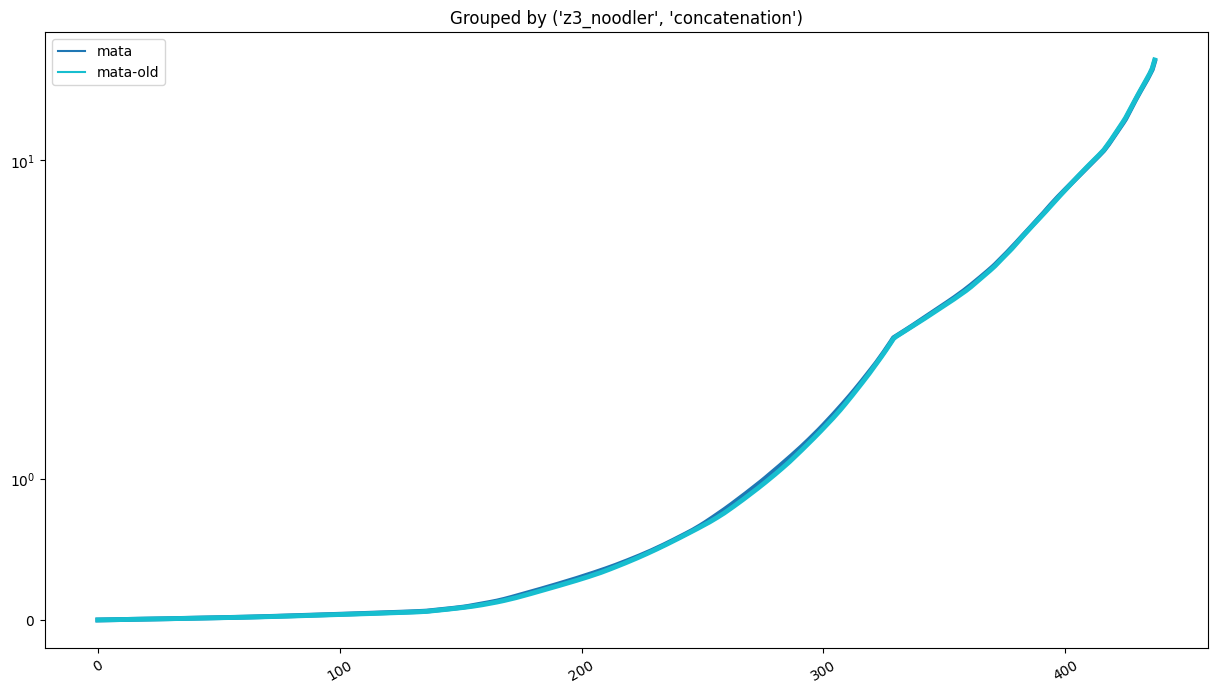

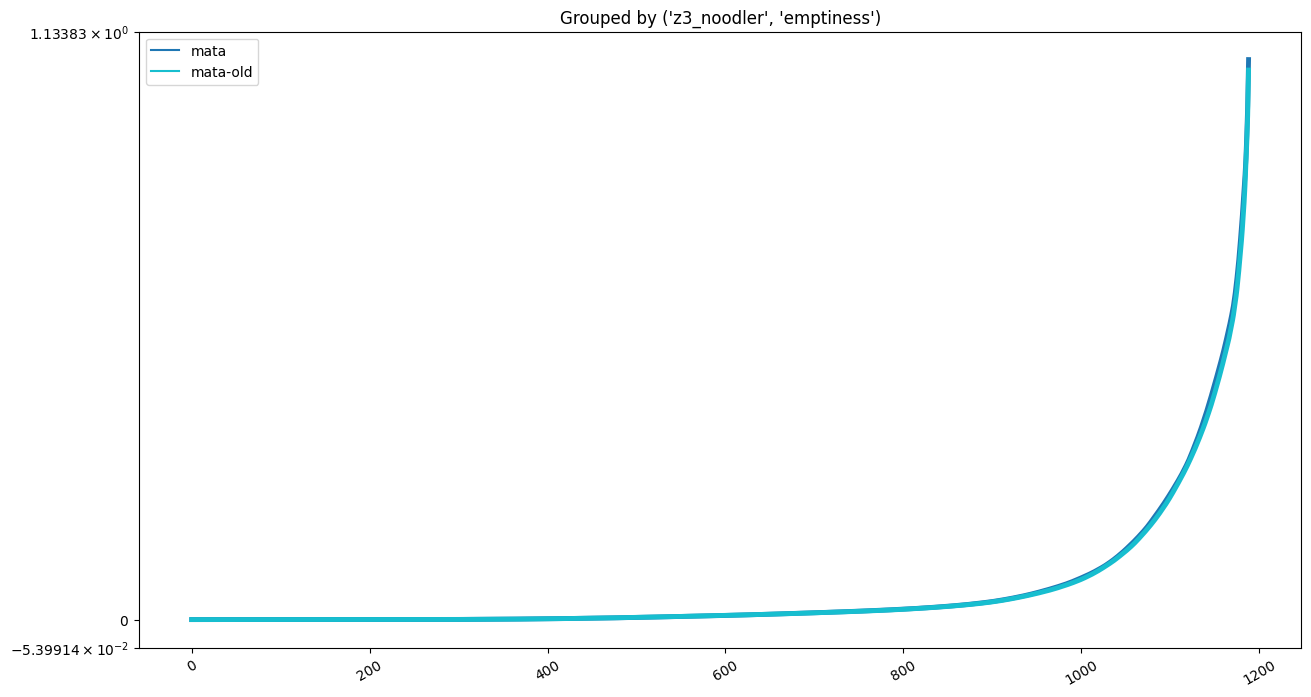

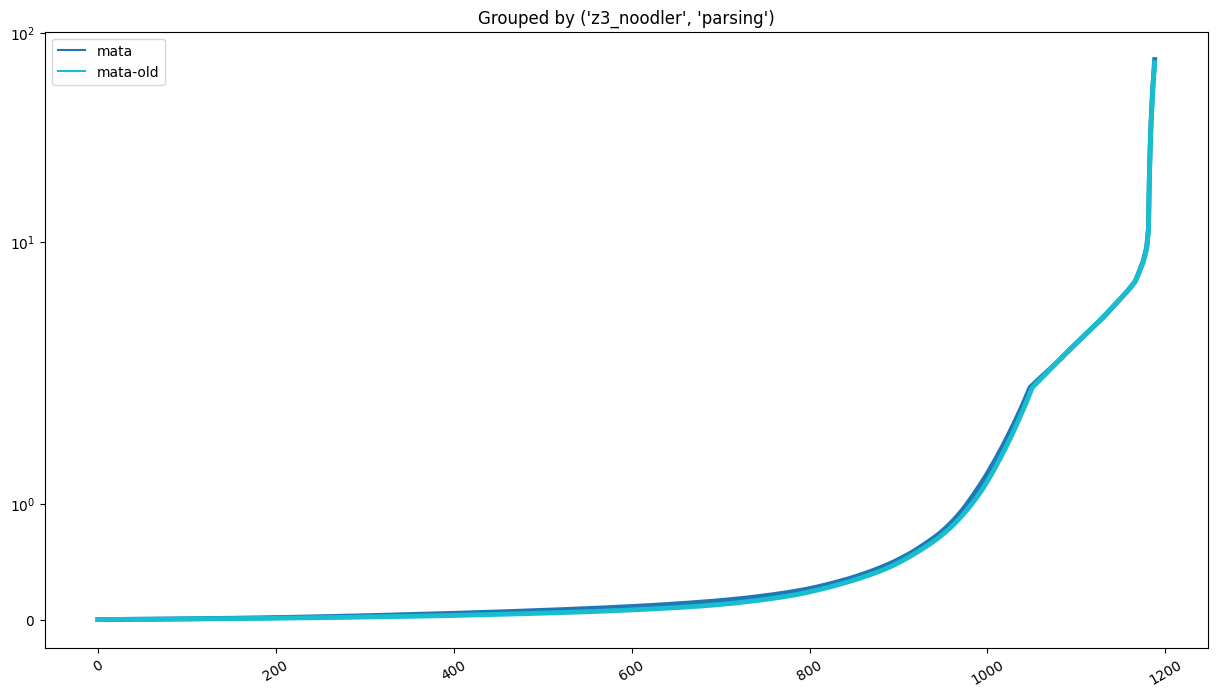

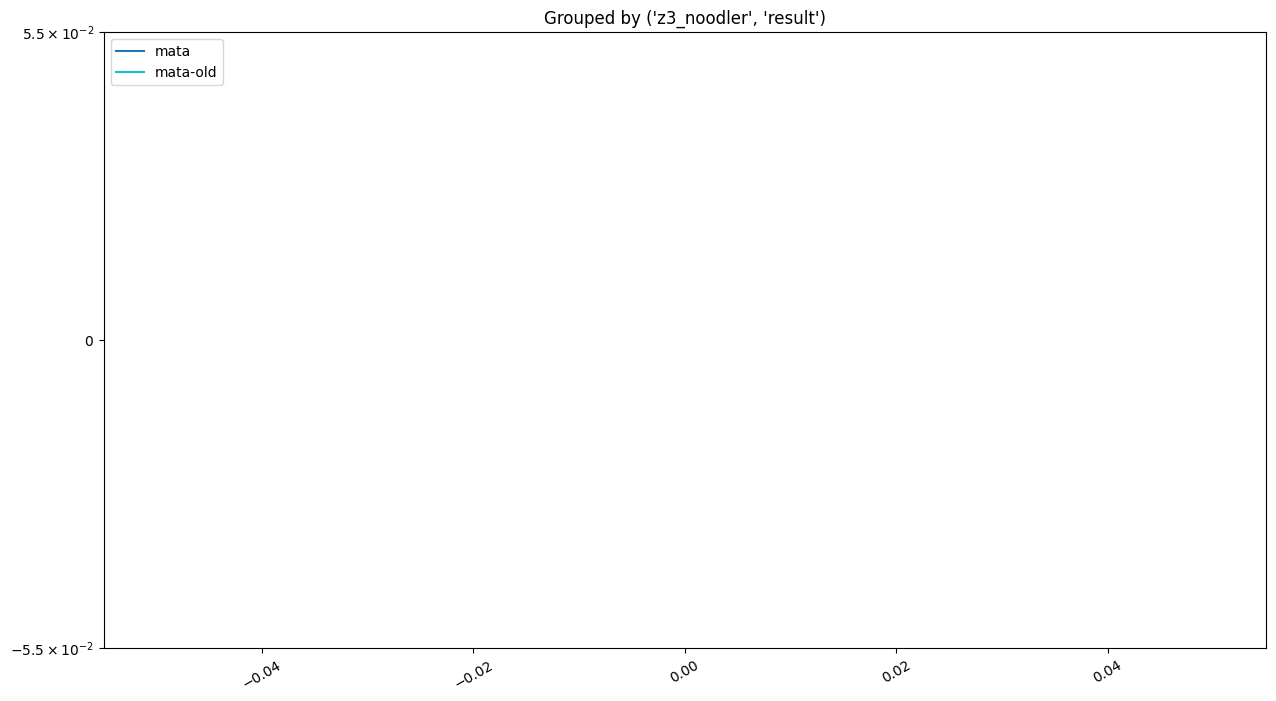

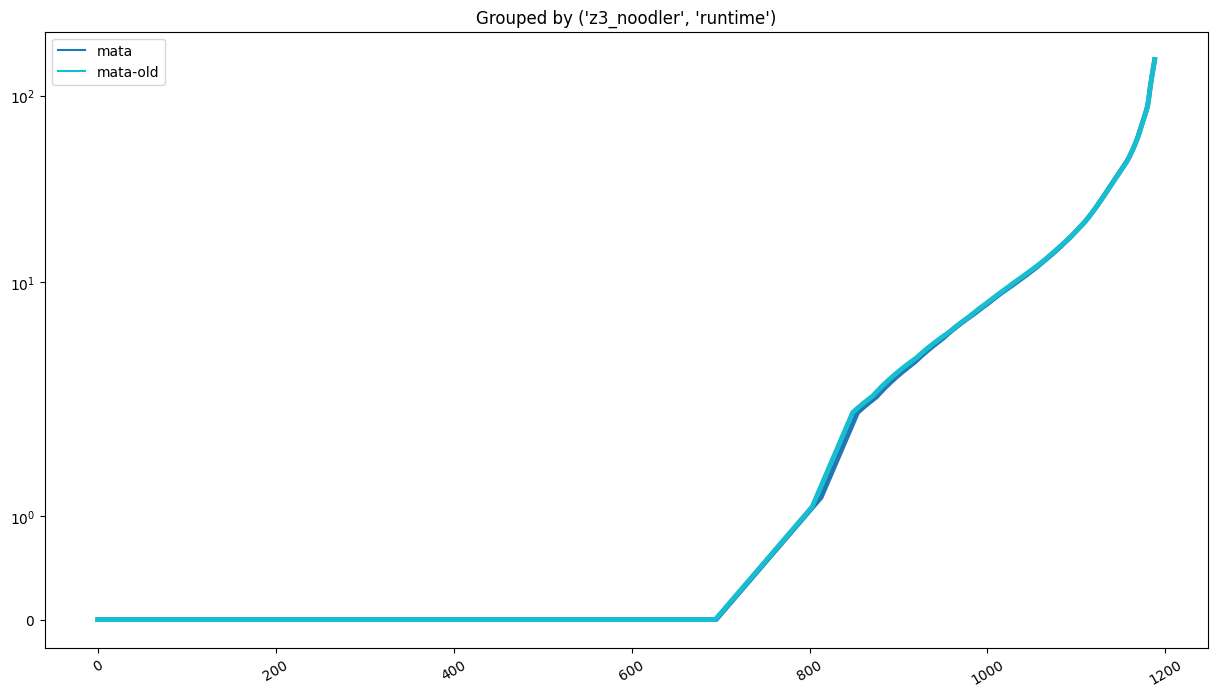

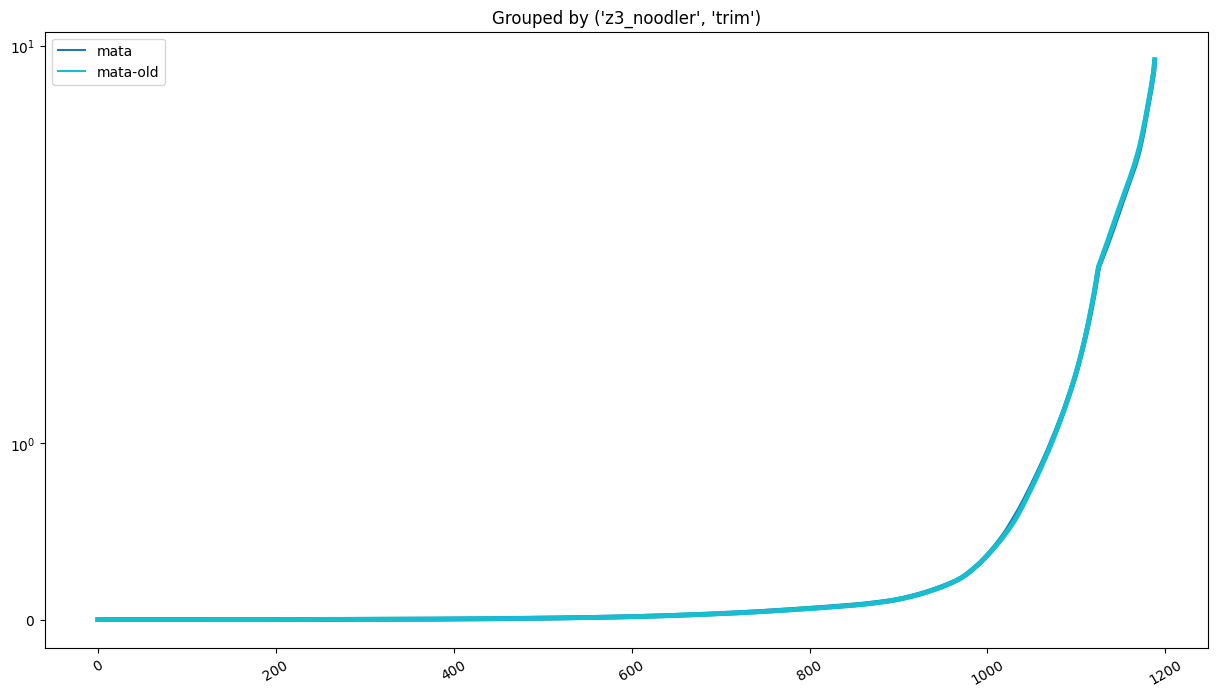

In [54]:
for grp, series in df.groupby(['bench', 'op']):
    plt.figure(figsize=(15, 8))
    data = {}
    for tool, values in series.groupby('tool'):
        data[tool] = list(sum_generator(values, timeout=TIMEOUT))
        
    g = seaborn.lineplot(
        data, linewidth=3.5, palette=color_map, dashes=""
    )
    g.set(yscale="symlog")
    g.set_xticklabels(g.get_xticklabels(), rotation=30)
    g.set_title(f"Grouped by {grp}")
    seaborn.move_legend(g, "upper left", bbox_to_anchor=(0., 1), frameon=True)
    save_figure(f"cactus-plot-{grp[0]}-{grp[1]}")

136 136
Saving to ./data/experiments-10-02-parsing/figs/scatter-plot-mata-mata-old-aut_inclusion-inclusion.png
136 136
Saving to ./data/experiments-10-02-parsing/figs/scatter-plot-mata-mata-old-aut_inclusion-minterm.png
136 136
Saving to ./data/experiments-10-02-parsing/figs/scatter-plot-mata-mata-old-aut_inclusion-parsing.png
136 136
Saving to ./data/experiments-10-02-parsing/figs/scatter-plot-mata-mata-old-aut_inclusion-result.png
136 136
Saving to ./data/experiments-10-02-parsing/figs/scatter-plot-mata-mata-old-aut_inclusion-runtime.png
40 40
Saving to ./data/experiments-10-02-parsing/figs/scatter-plot-mata-mata-old-bc_cox_diff-emptiness.png
40 40
Saving to ./data/experiments-10-02-parsing/figs/scatter-plot-mata-mata-old-bc_cox_diff-intersection.png
80 80
Saving to ./data/experiments-10-02-parsing/figs/scatter-plot-mata-mata-old-bc_cox_diff-minterm.png
80 80
Saving to ./data/experiments-10-02-parsing/figs/scatter-plot-mata-mata-old-bc_cox_diff-parsing.png
40 40
Saving to ./data/expe

/tmp/ipykernel_1820/1654169004.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15, 8))


Saving to ./data/experiments-10-02-parsing/figs/scatter-plot-mata-mata-old-bc_cox_union-parsing.png
80 80
Saving to ./data/experiments-10-02-parsing/figs/scatter-plot-mata-mata-old-bc_cox_union-result.png
80 80
Saving to ./data/experiments-10-02-parsing/figs/scatter-plot-mata-mata-old-bc_cox_union-runtime.png
80 80
Saving to ./data/experiments-10-02-parsing/figs/scatter-plot-mata-mata-old-bc_cox_union-trim.png
80 80
Saving to ./data/experiments-10-02-parsing/figs/scatter-plot-mata-mata-old-bc_cox_union-union.png
187 187
Saving to ./data/experiments-10-02-parsing/figs/scatter-plot-mata-mata-old-bc_intersect-emptiness.png
187 187
Saving to ./data/experiments-10-02-parsing/figs/scatter-plot-mata-mata-old-bc_intersect-intersection.png
187 187
Saving to ./data/experiments-10-02-parsing/figs/scatter-plot-mata-mata-old-bc_intersect-minterm.png
187 187
Saving to ./data/experiments-10-02-parsing/figs/scatter-plot-mata-mata-old-bc_intersect-parsing.png
187 187
Saving to ./data/experiments-10-02-

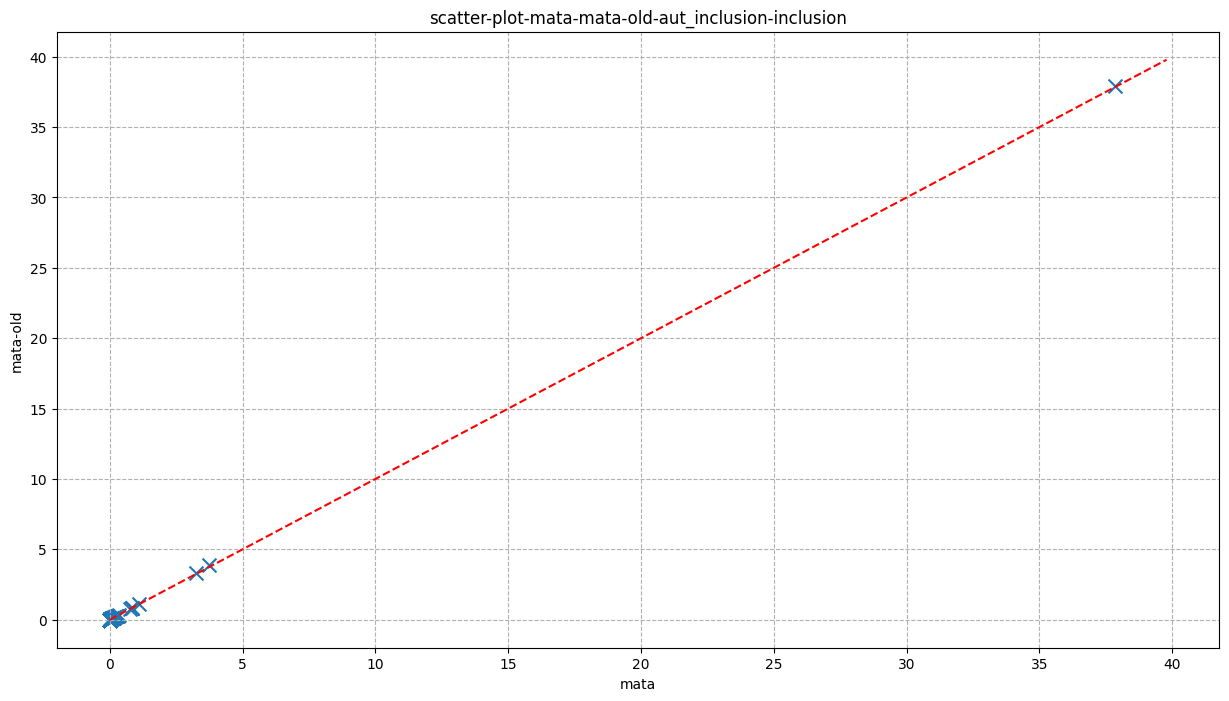

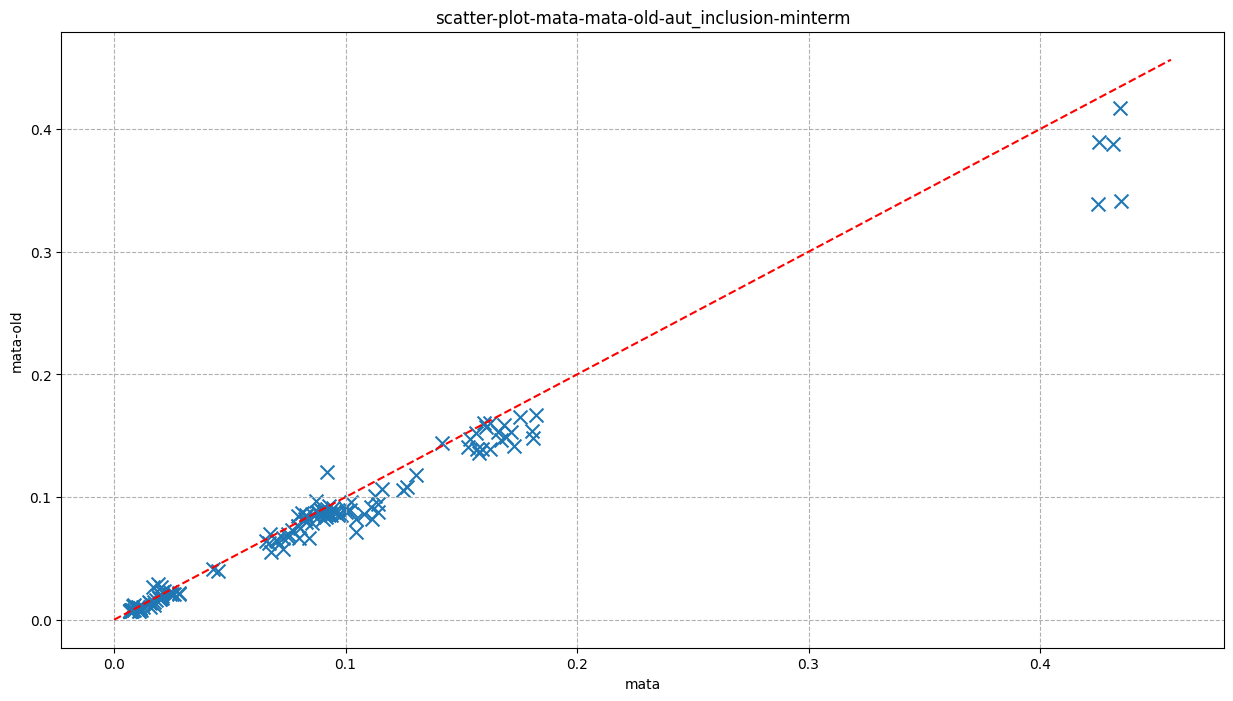

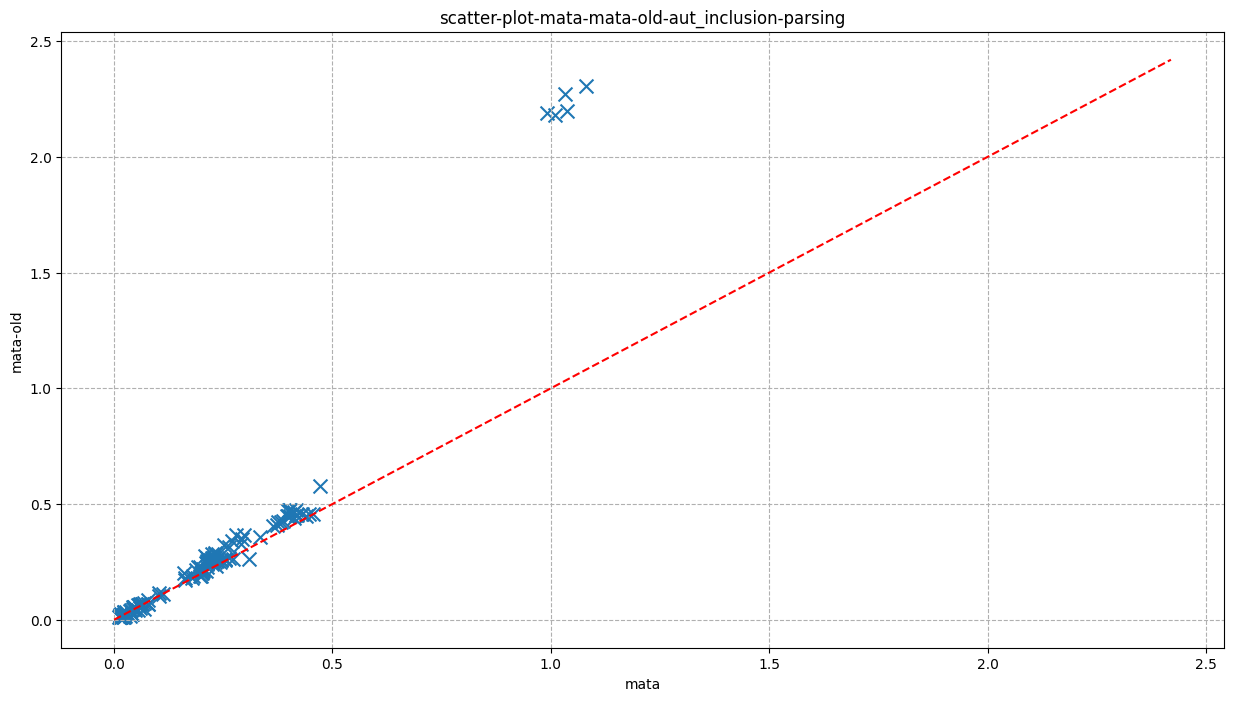

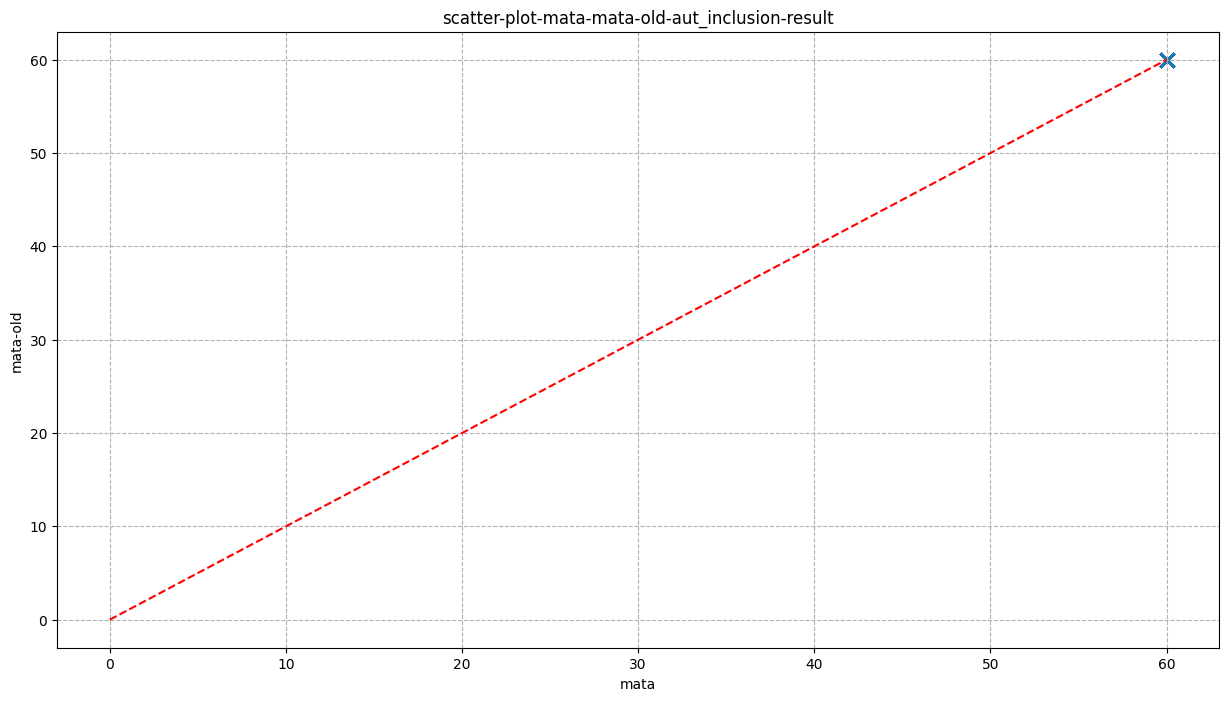

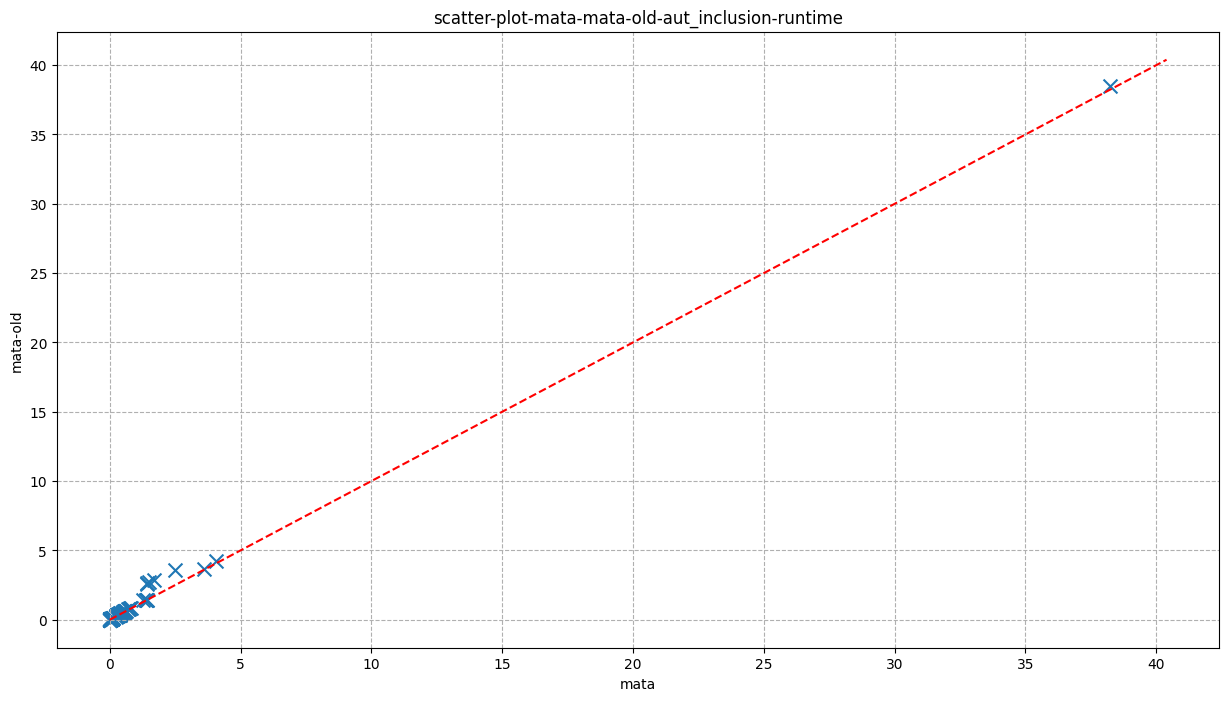

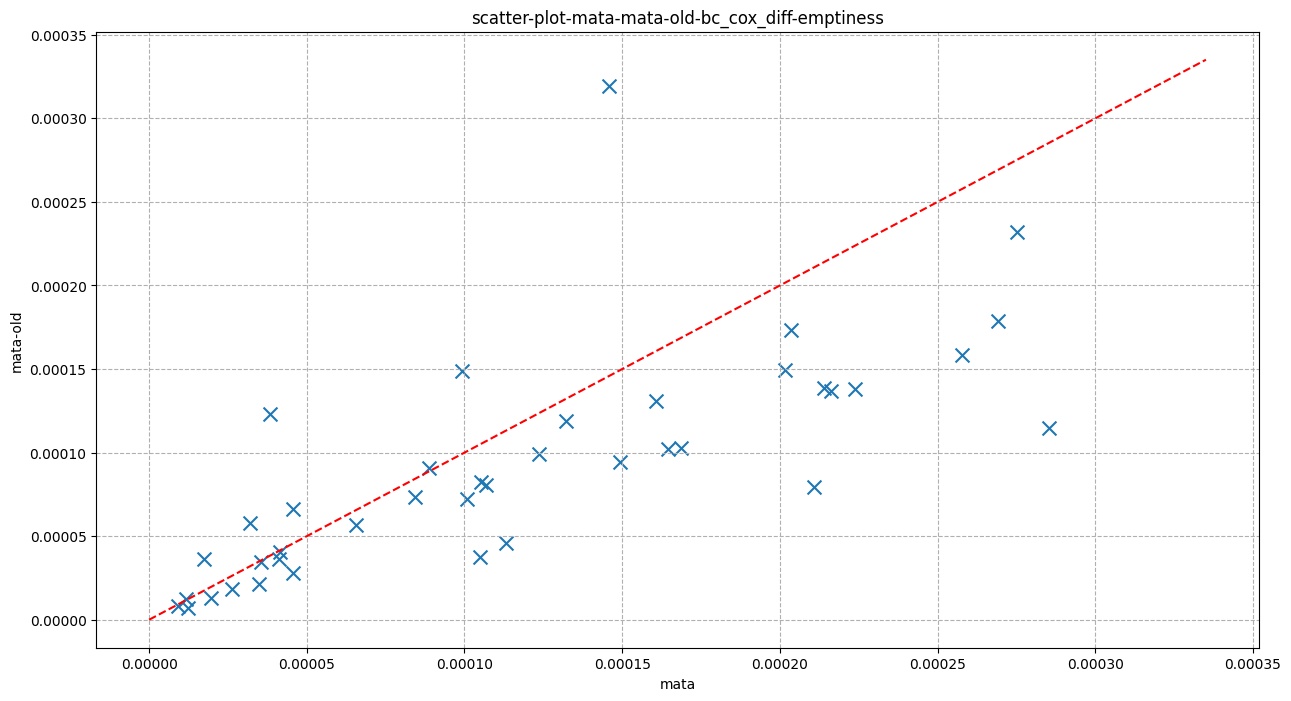

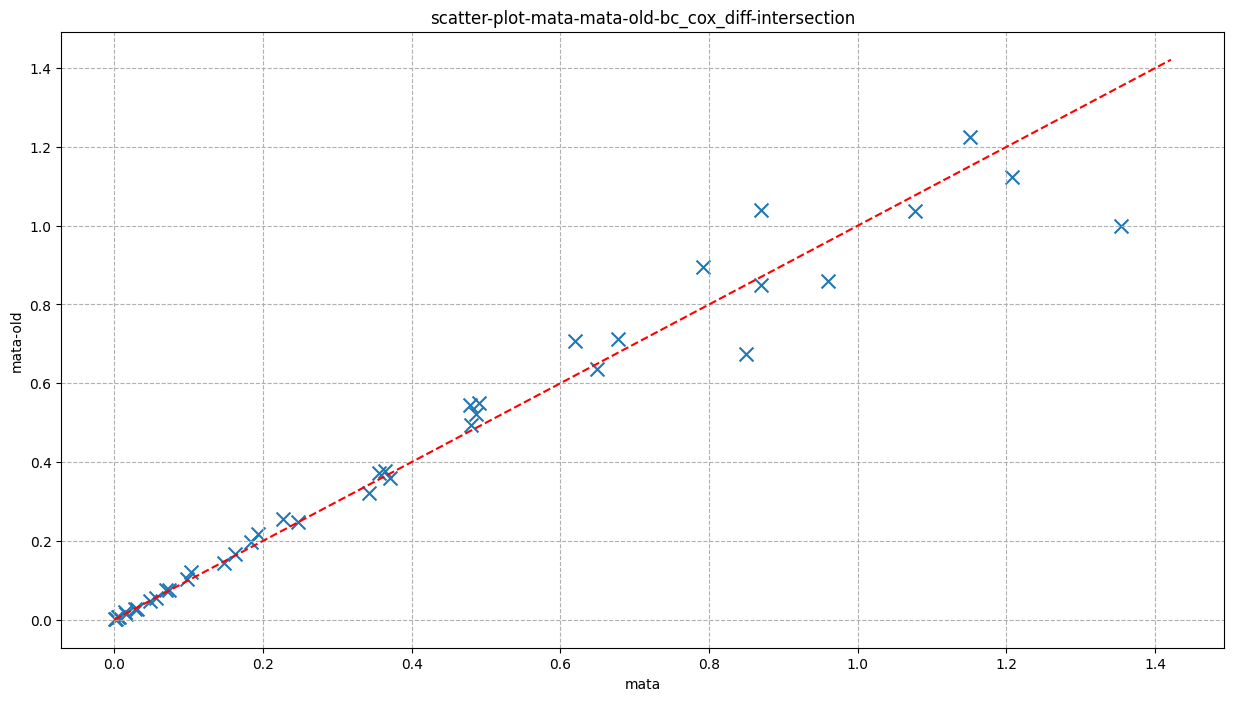

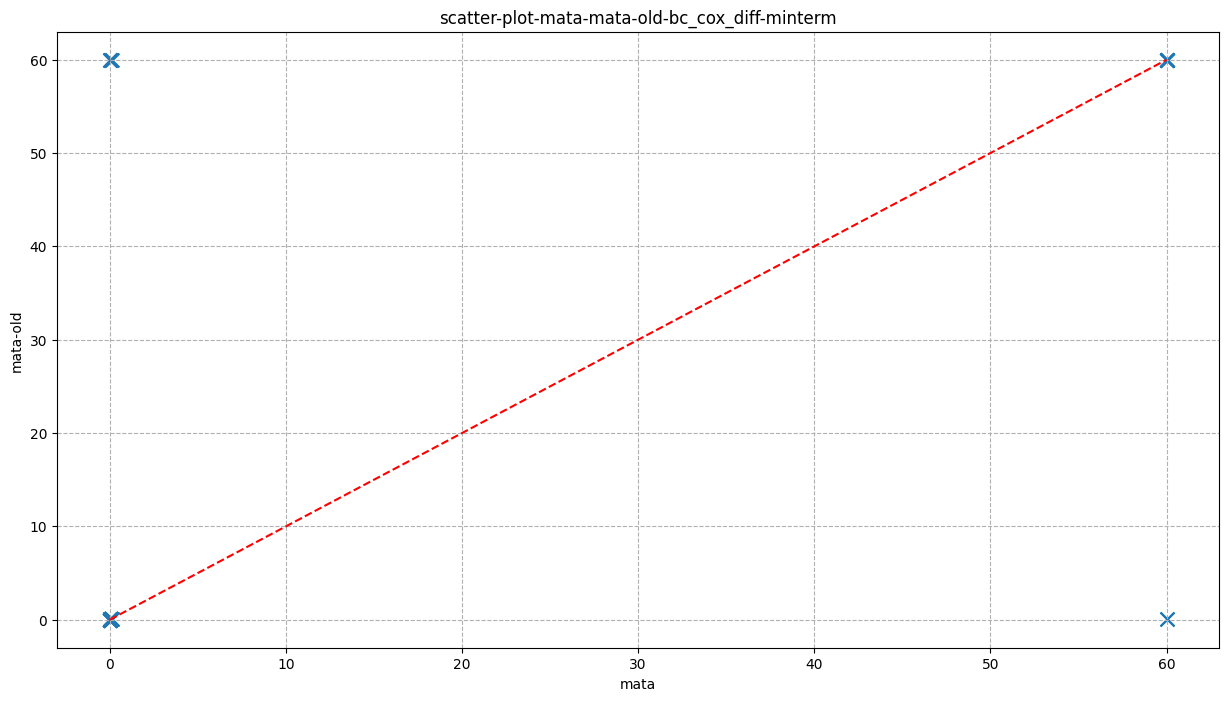

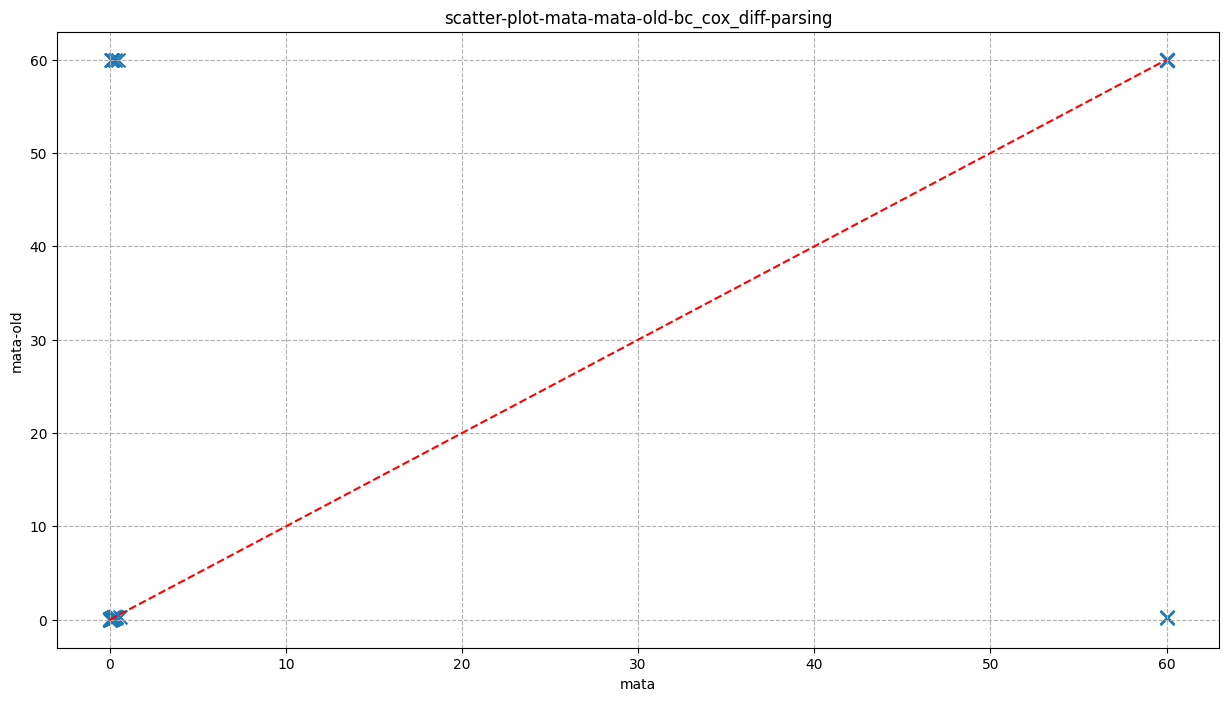

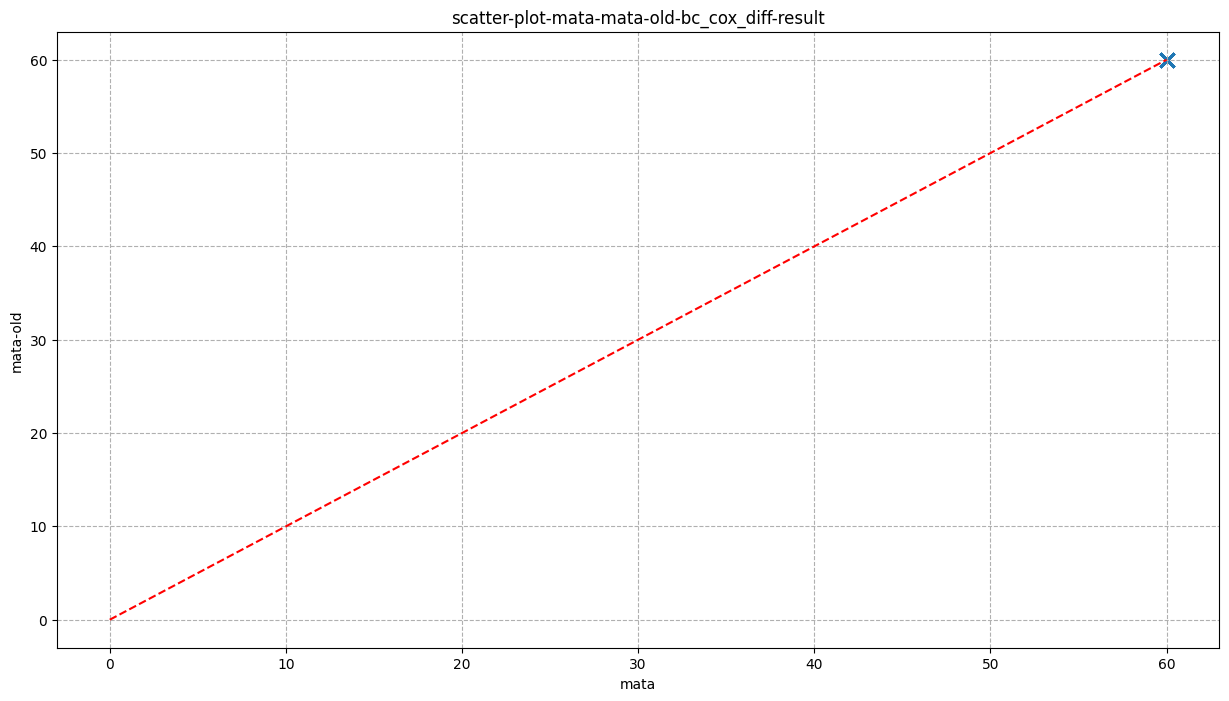

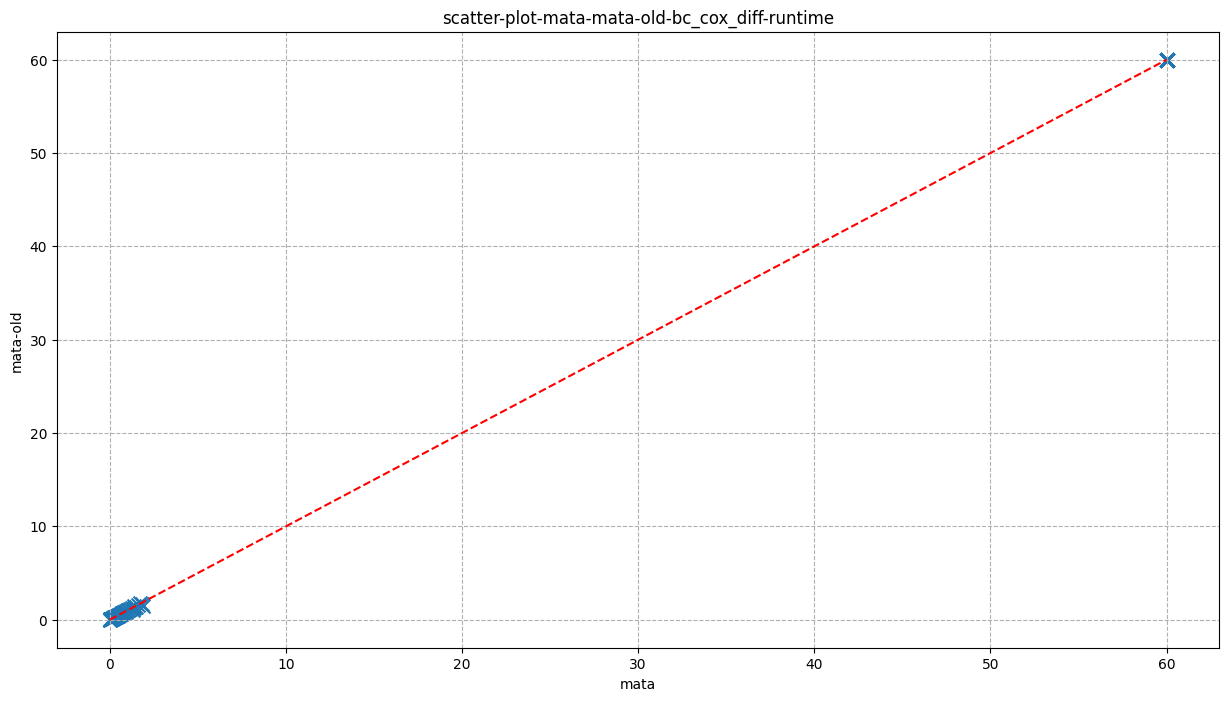

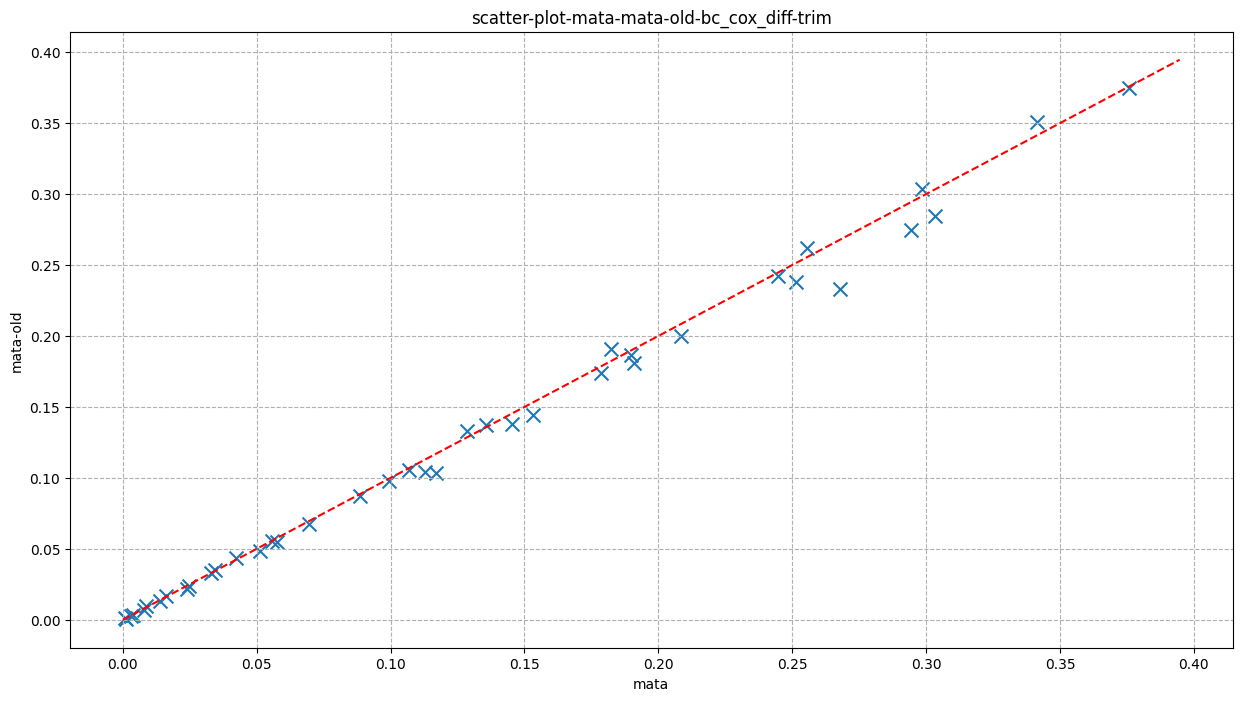

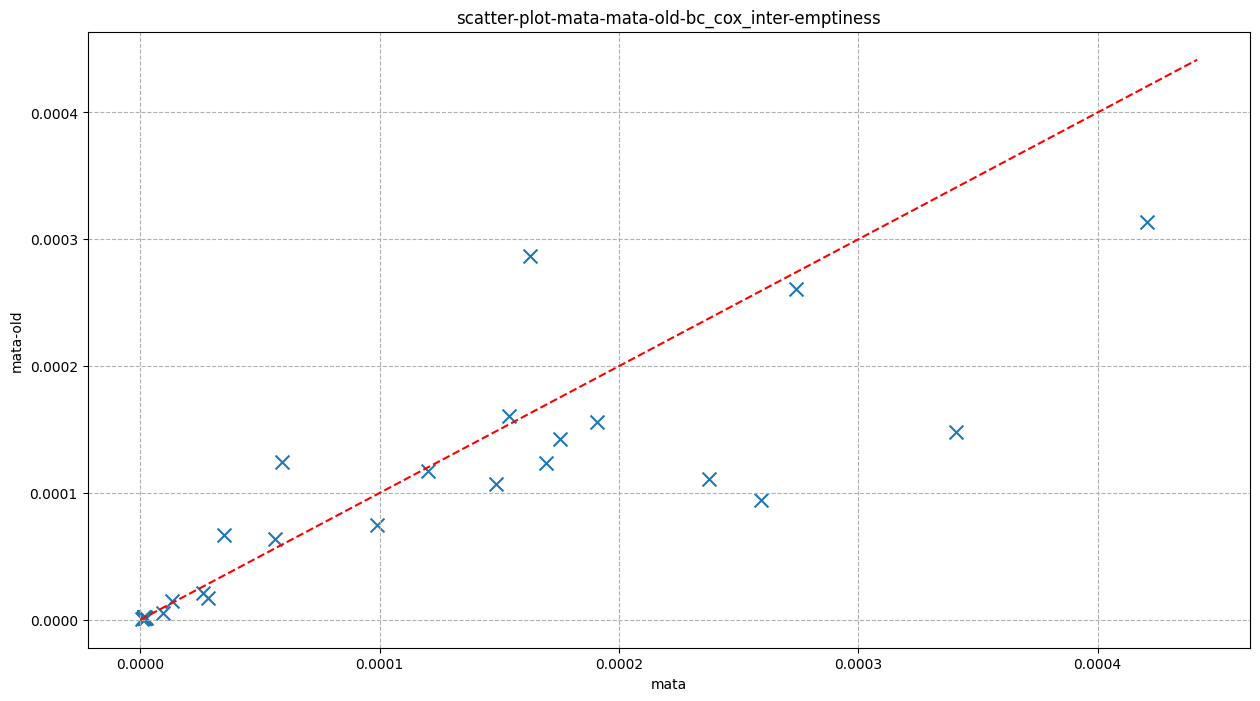

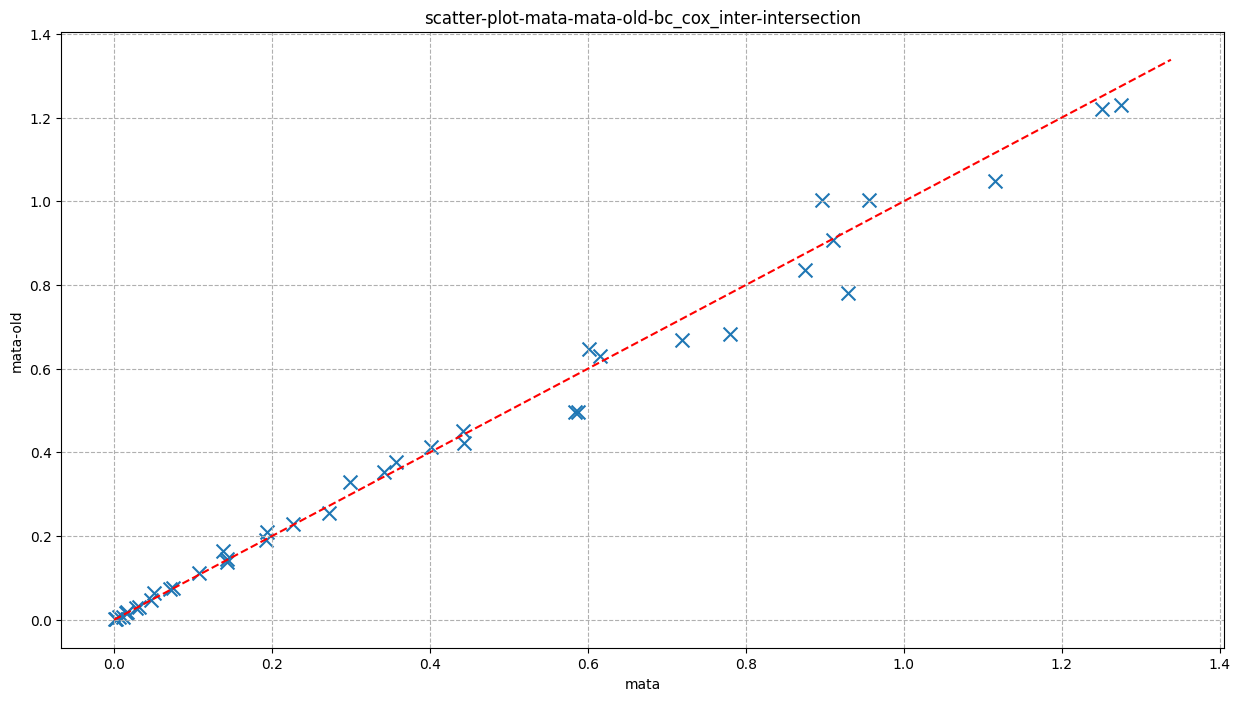

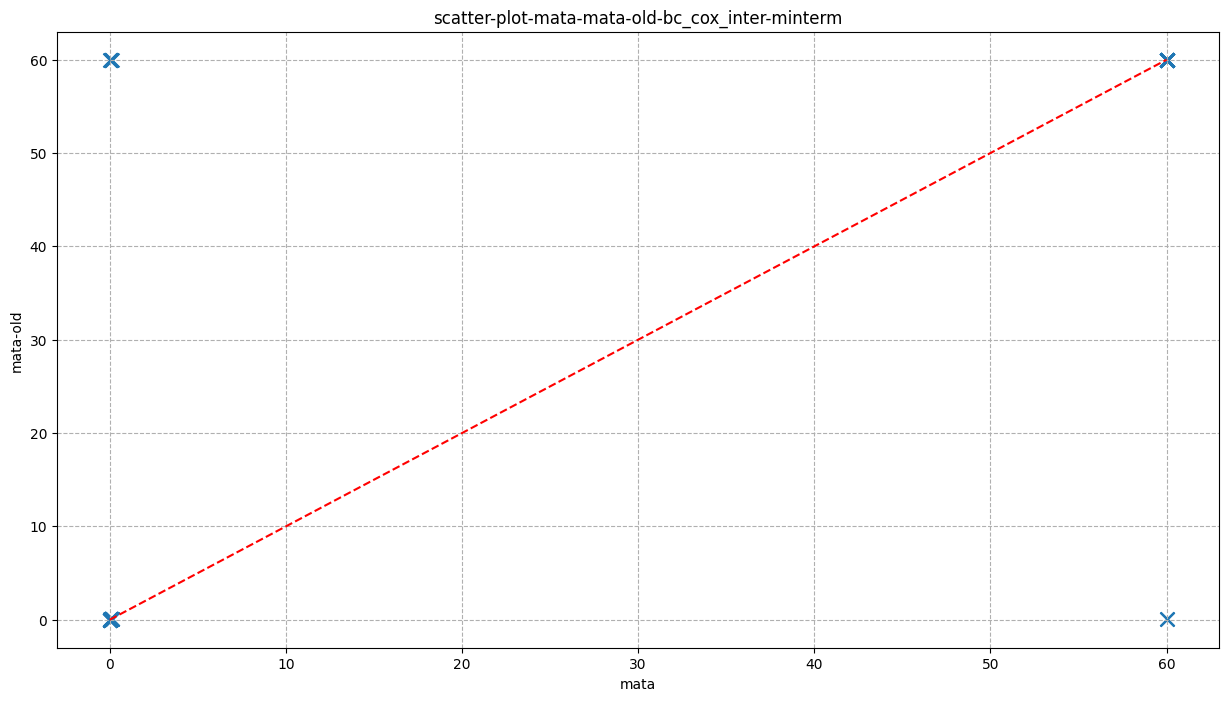

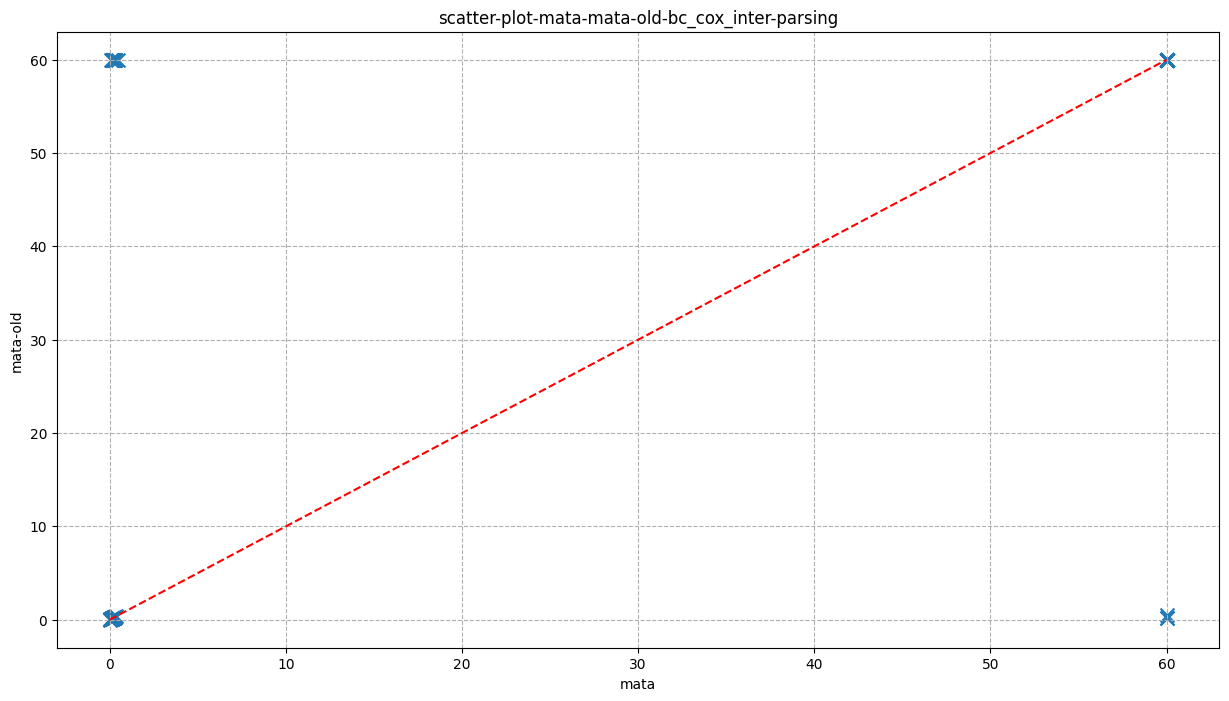

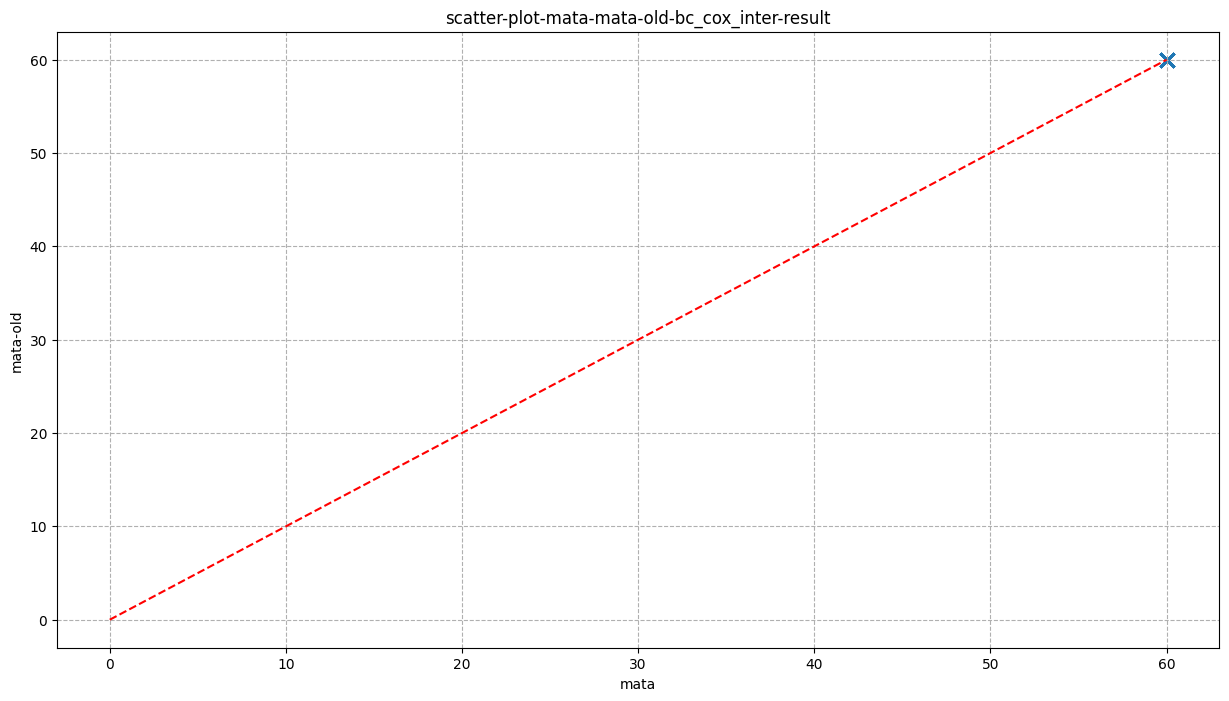

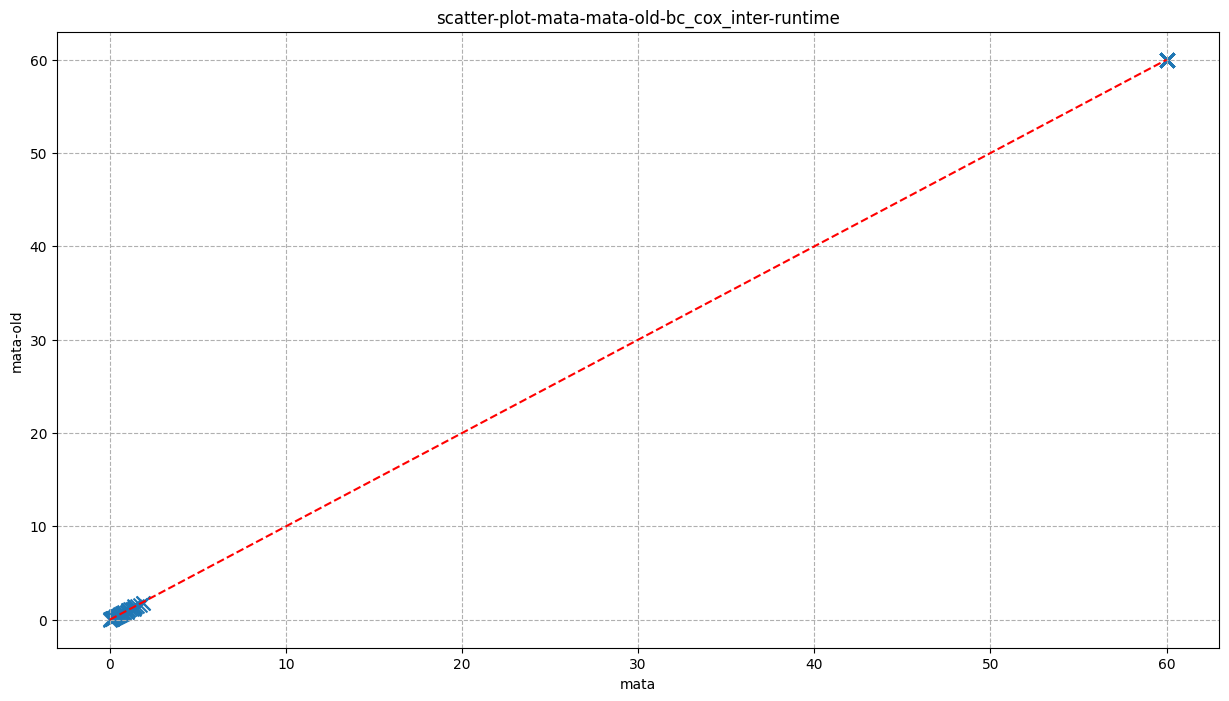

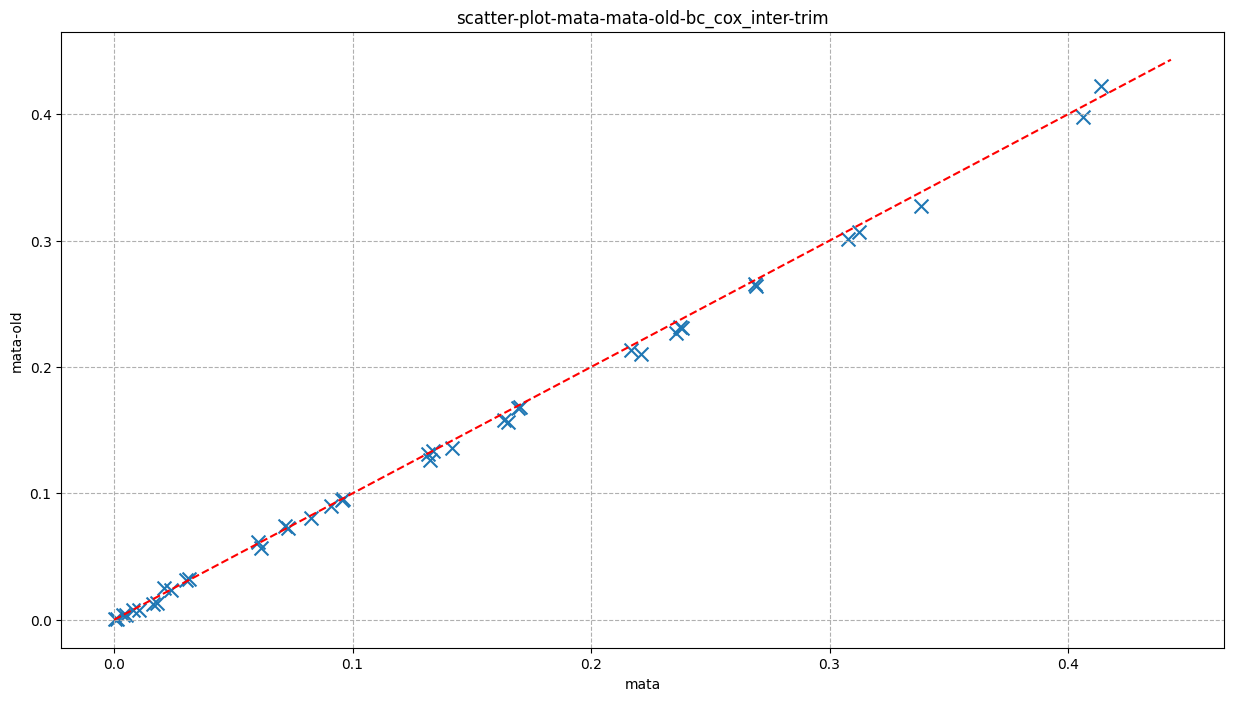

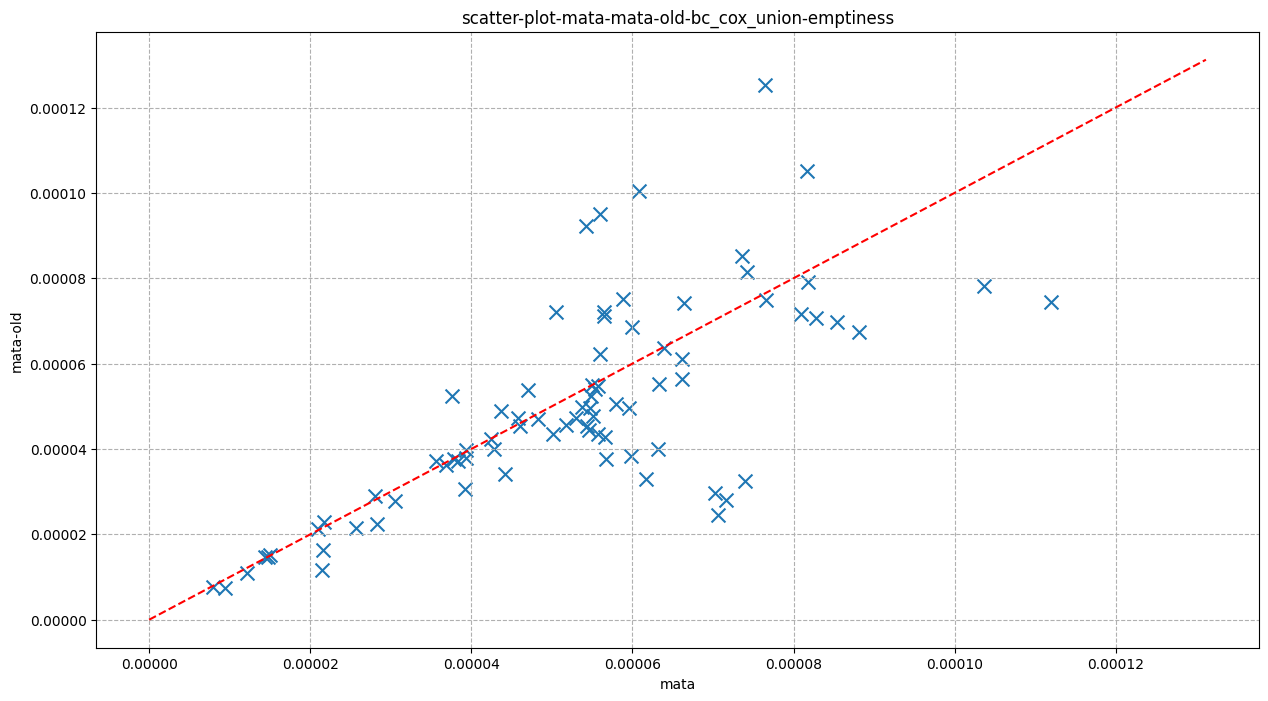

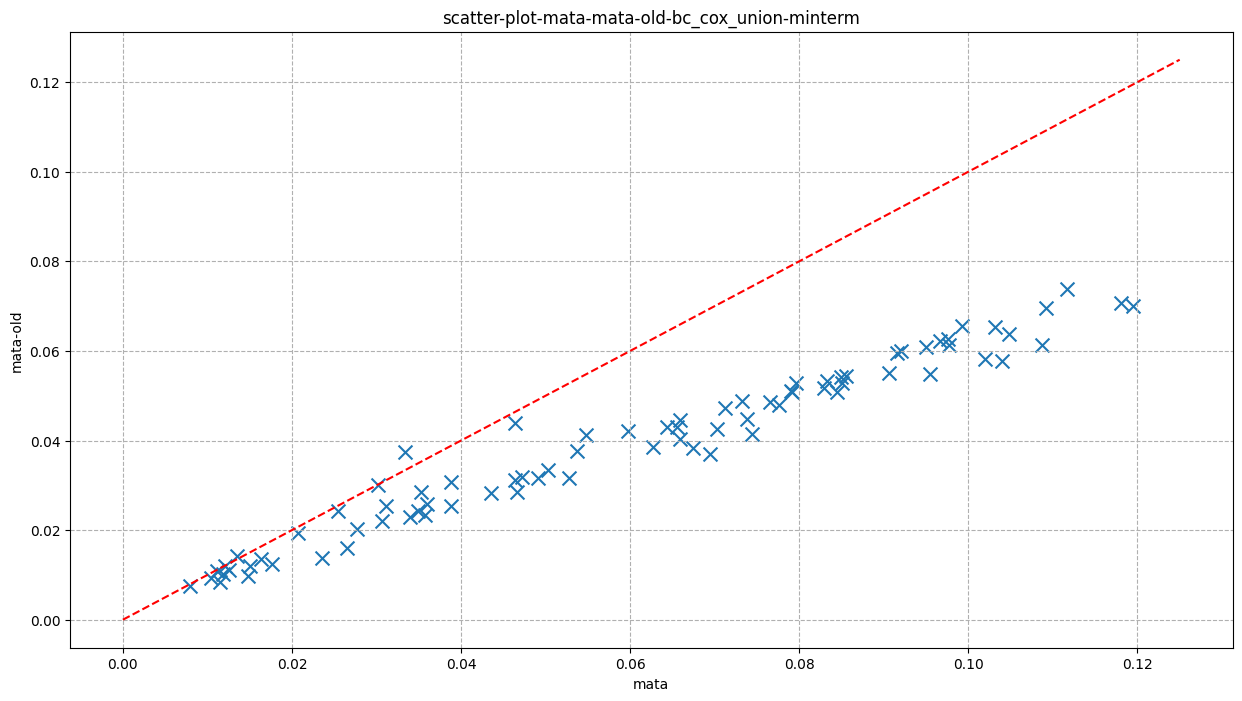

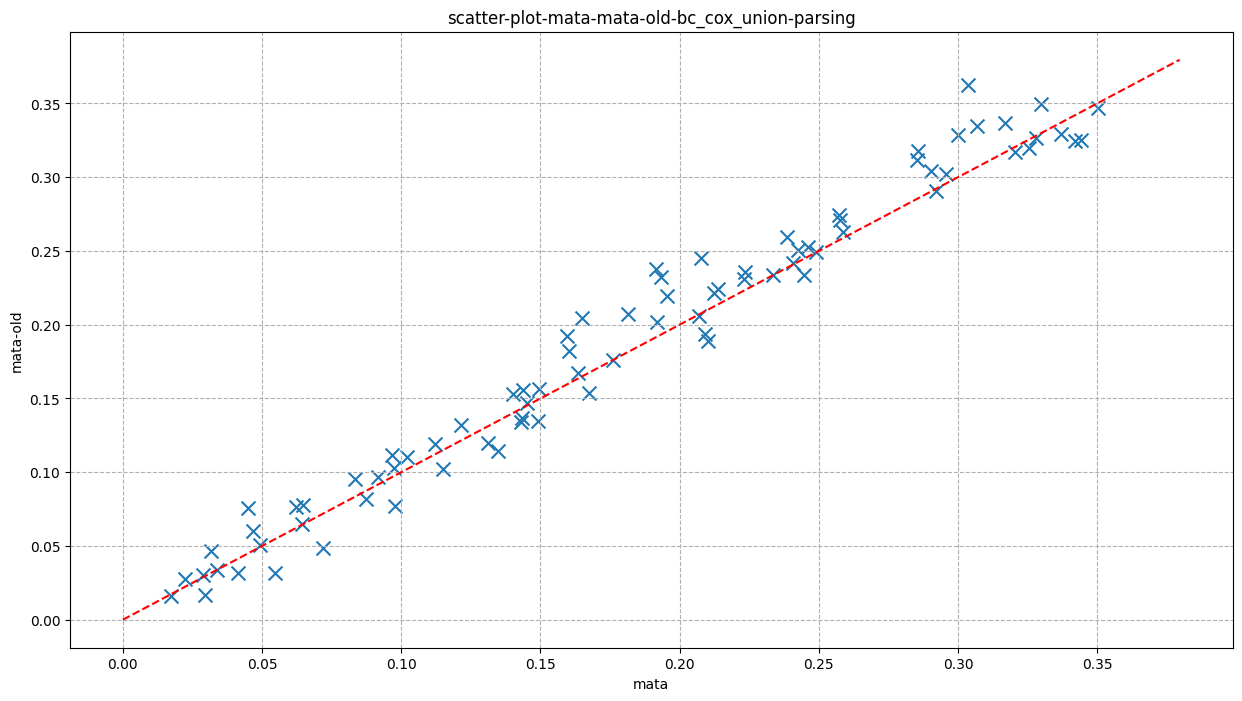

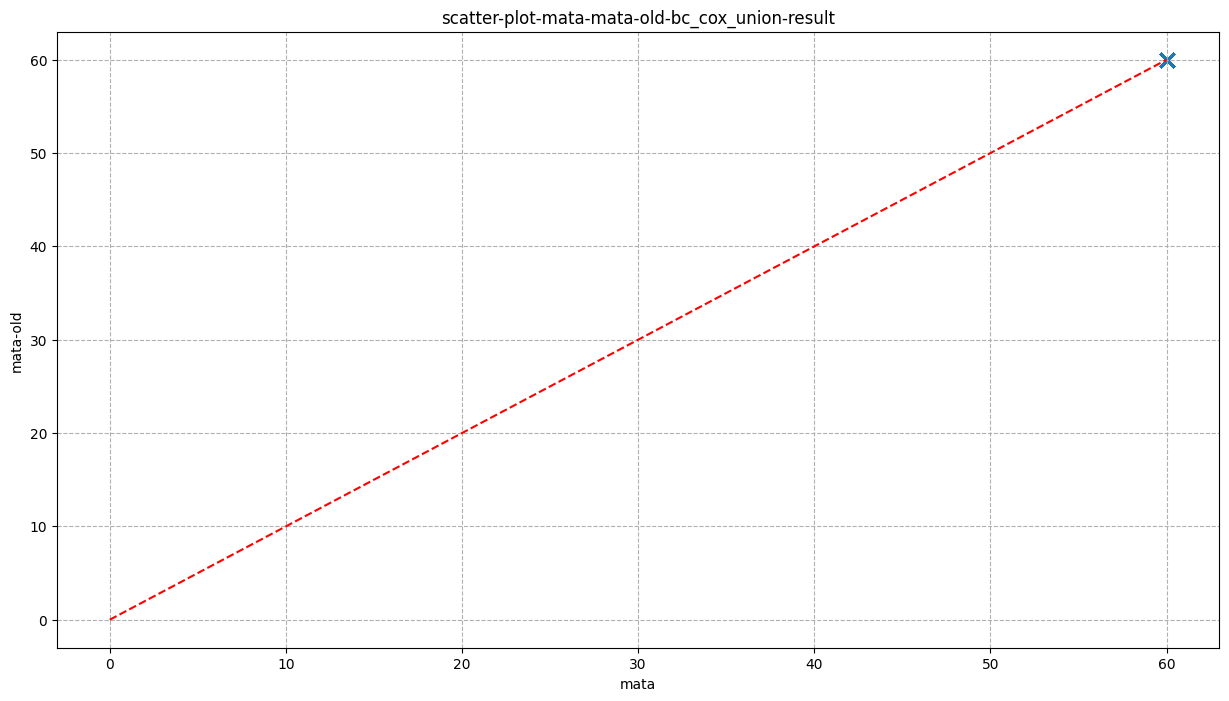

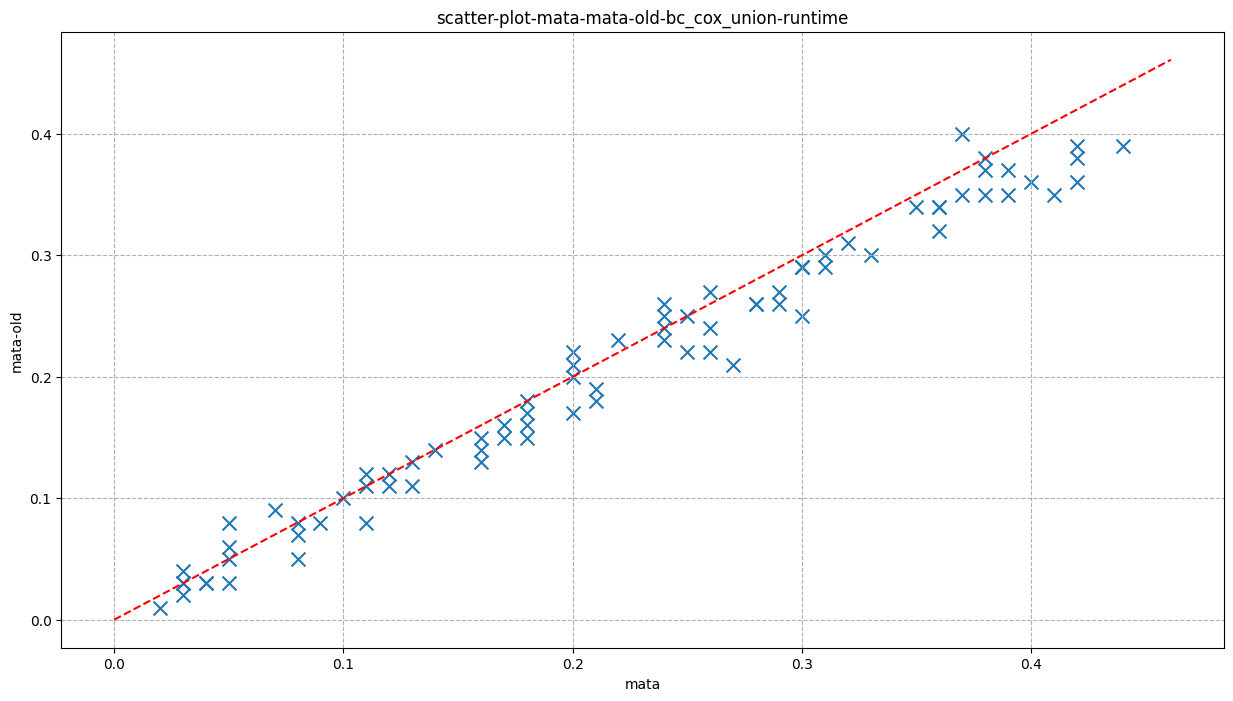

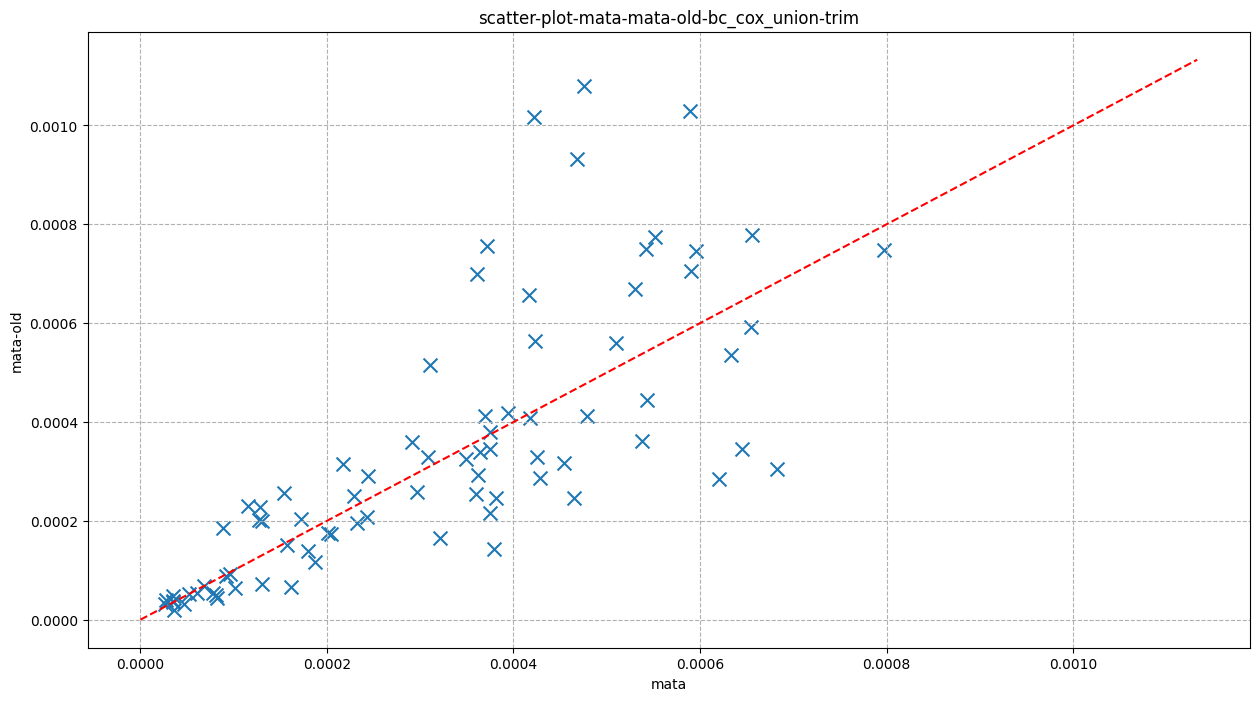

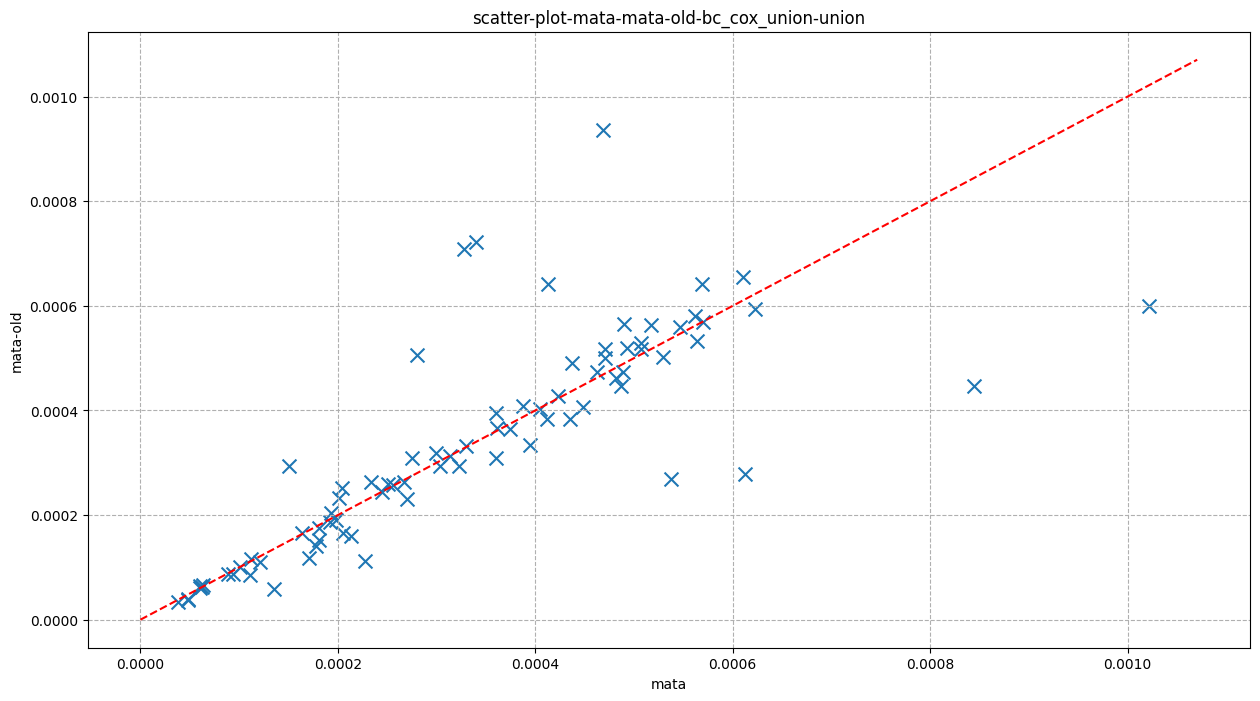

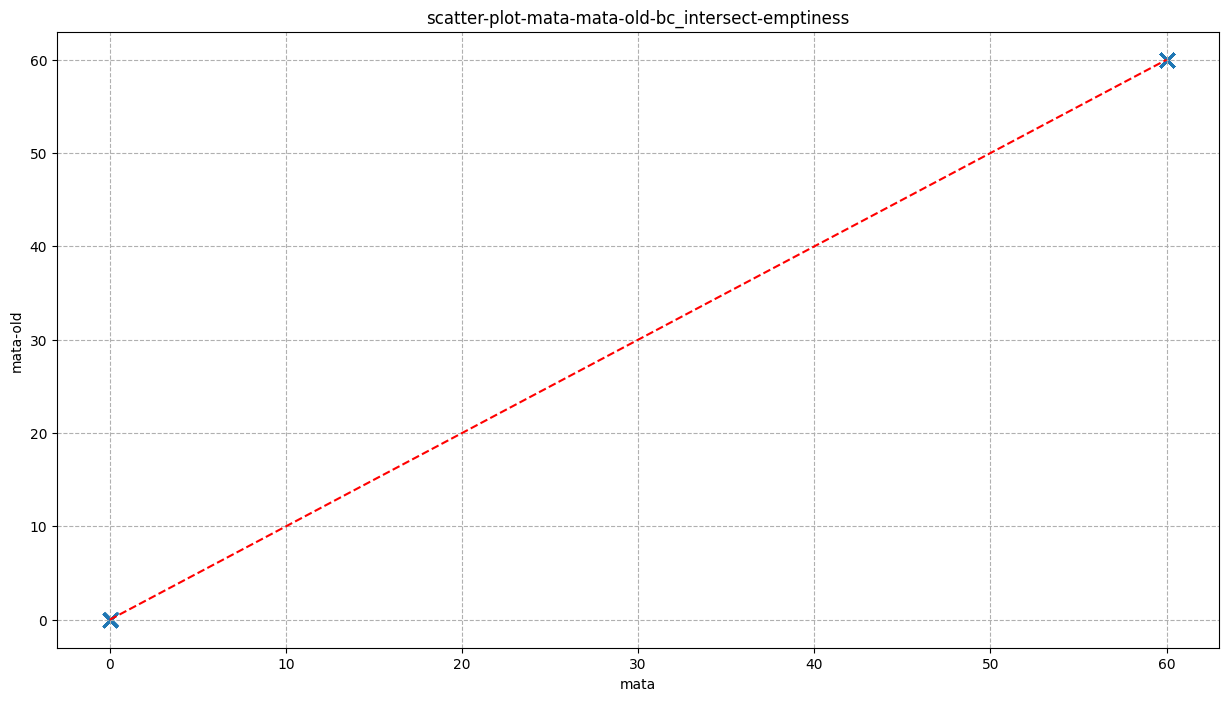

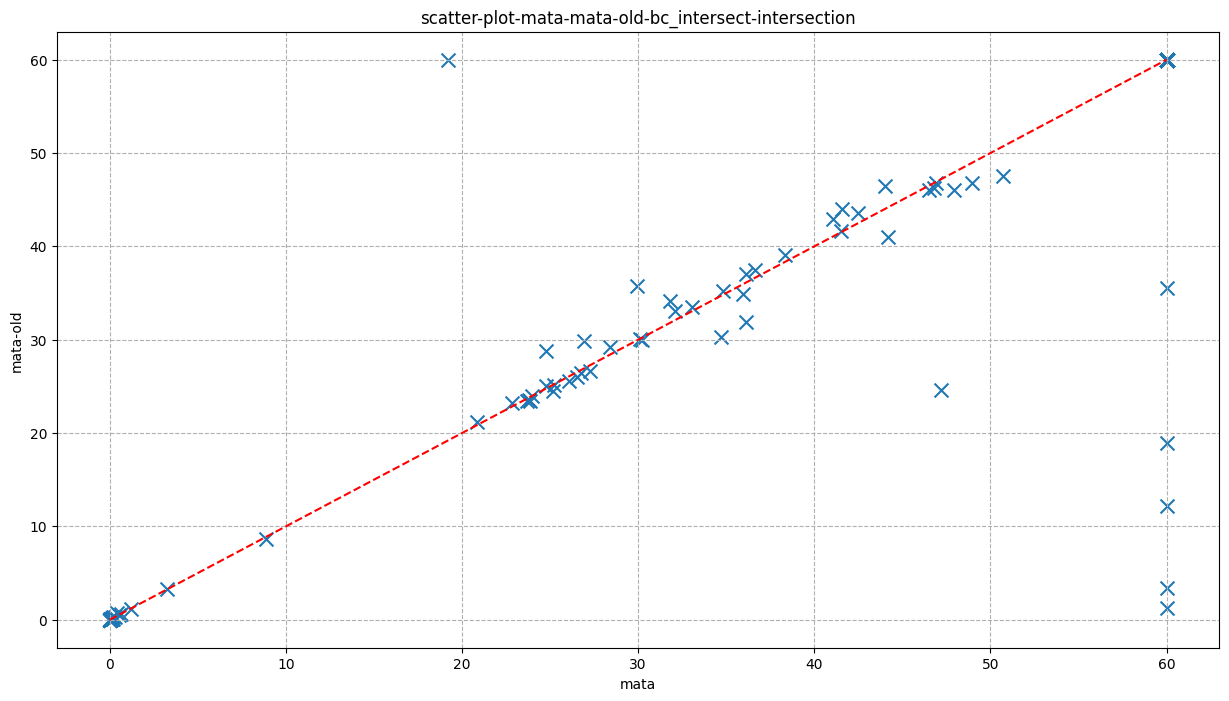

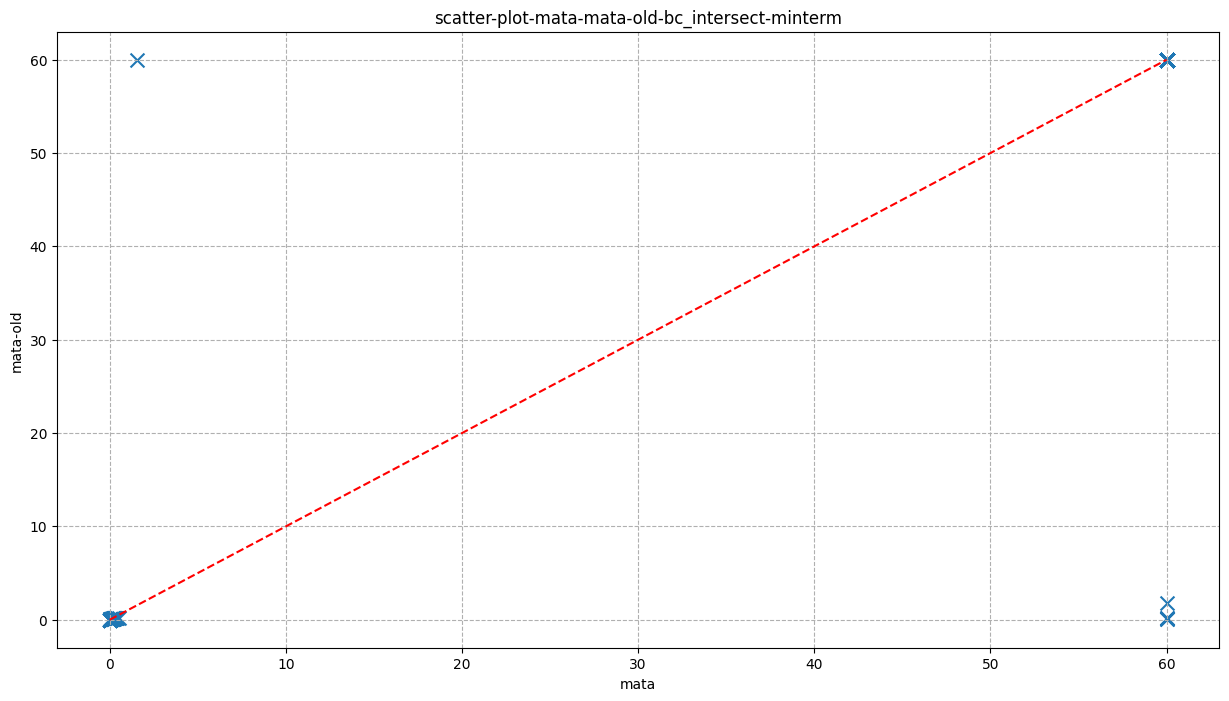

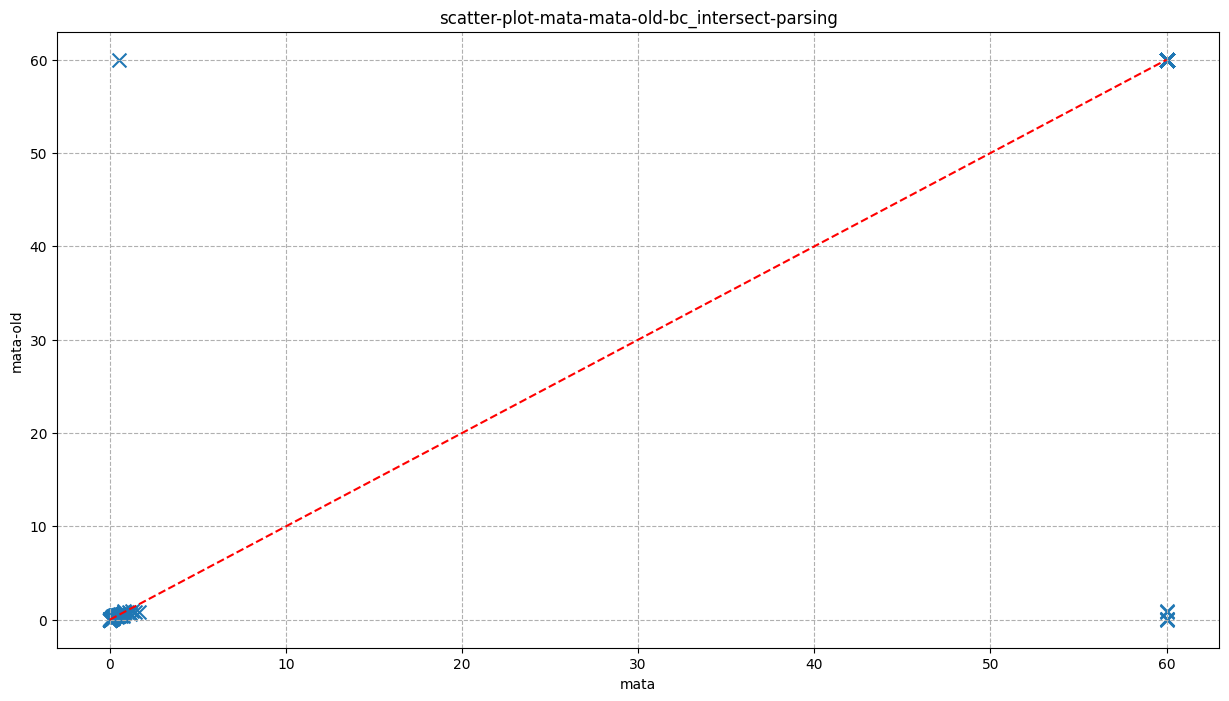

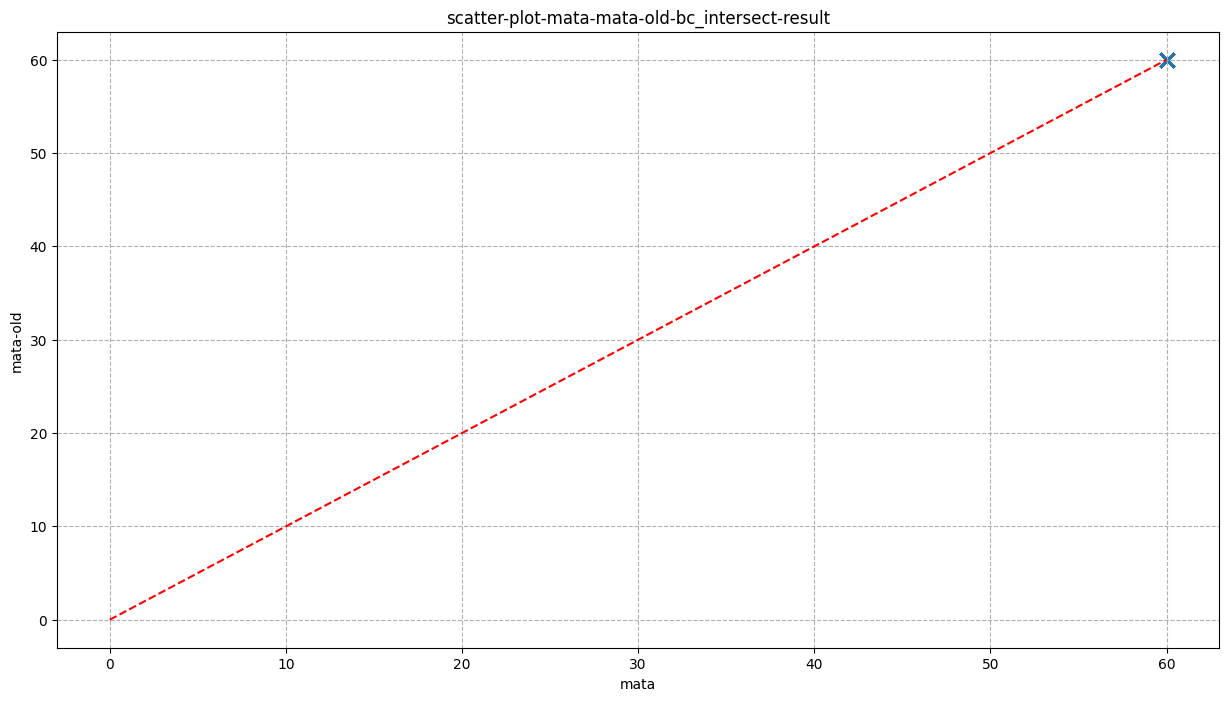

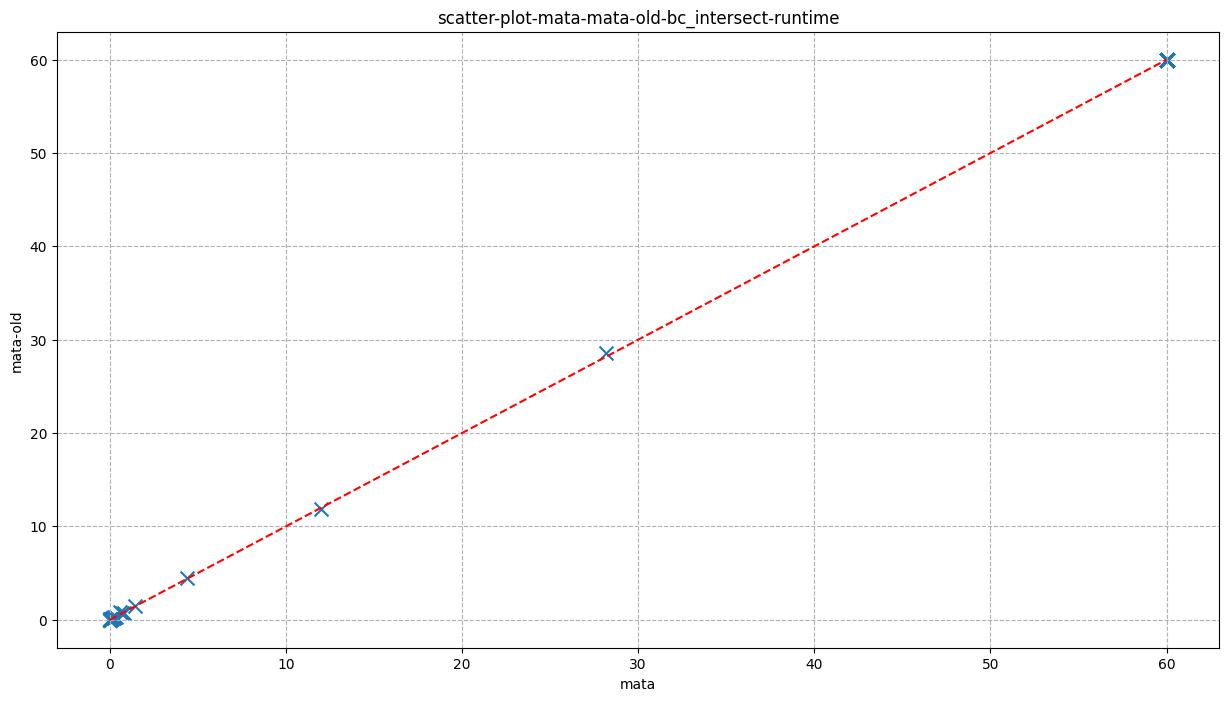

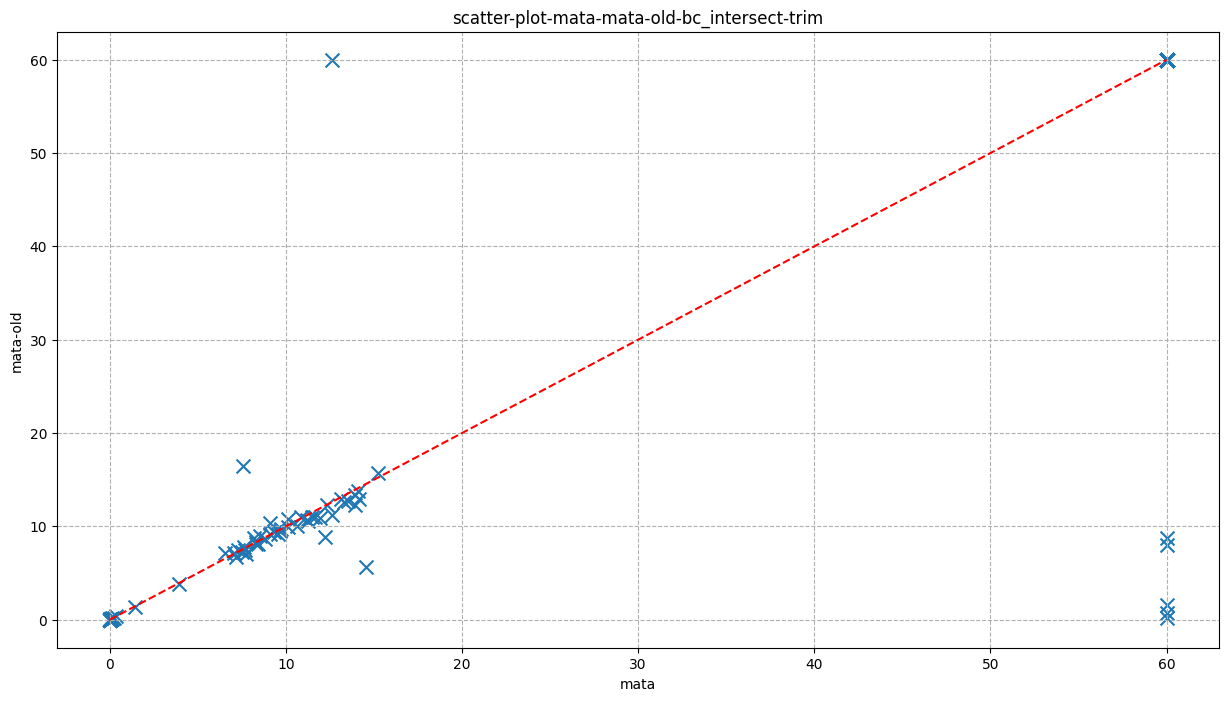

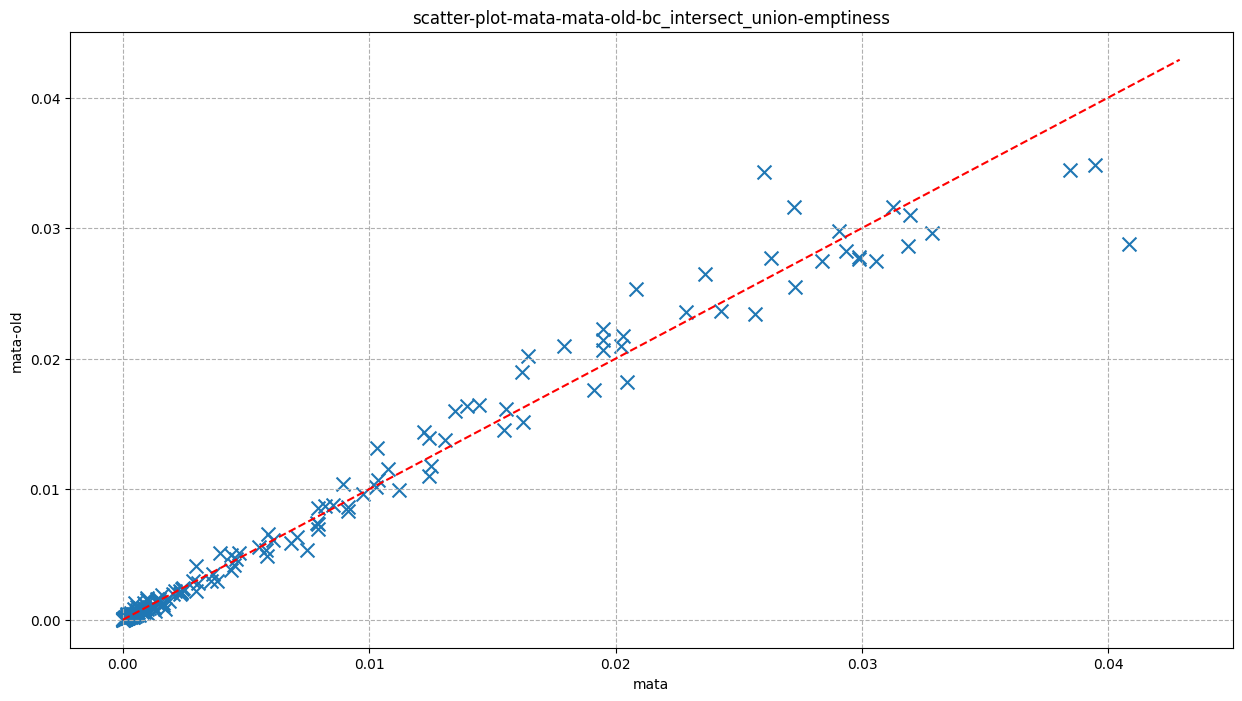

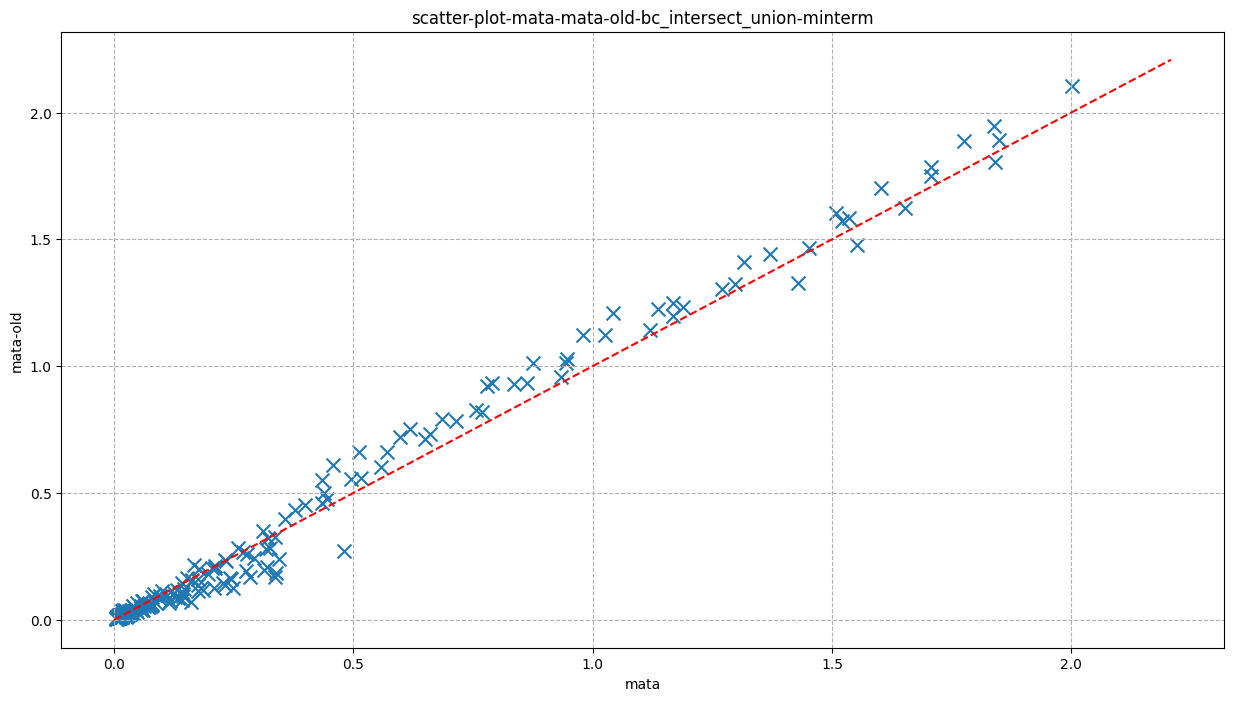

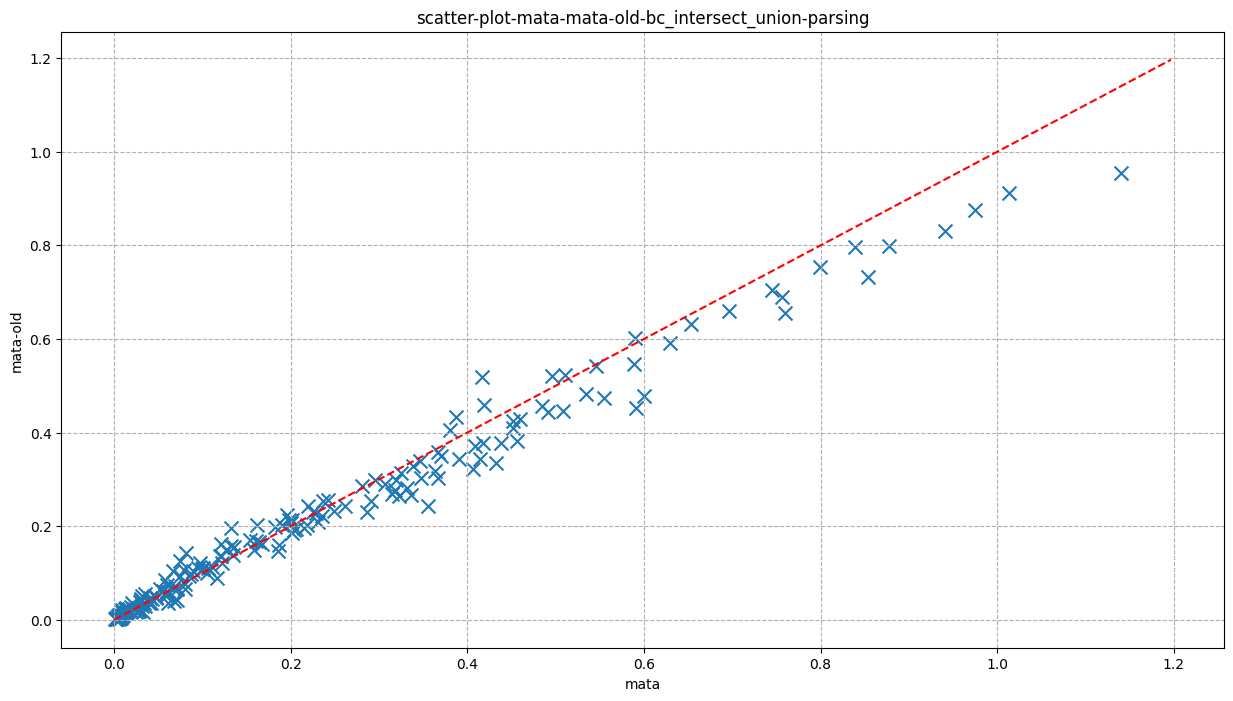

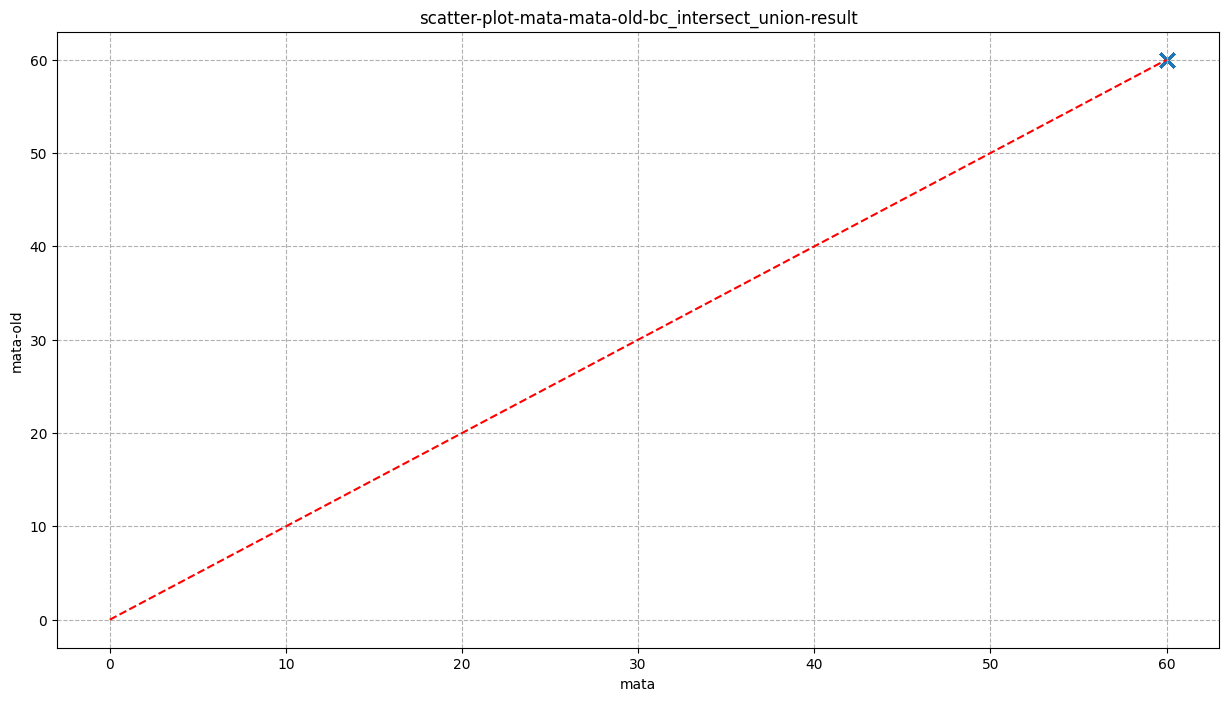

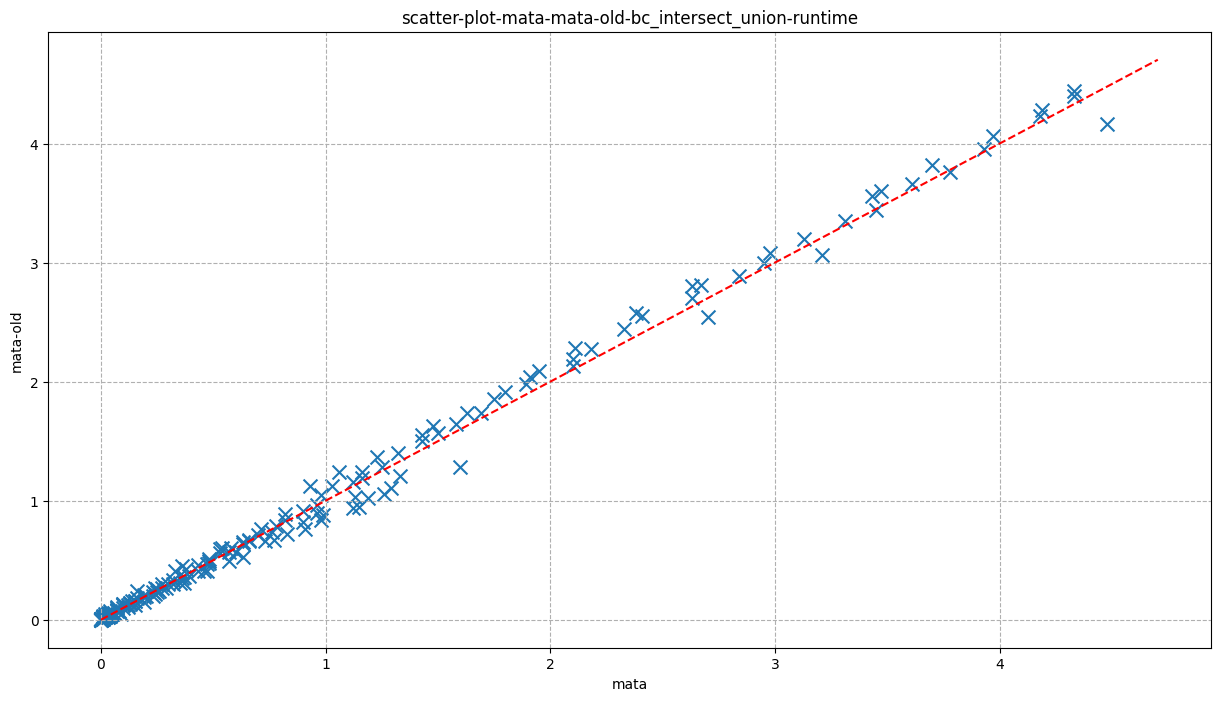

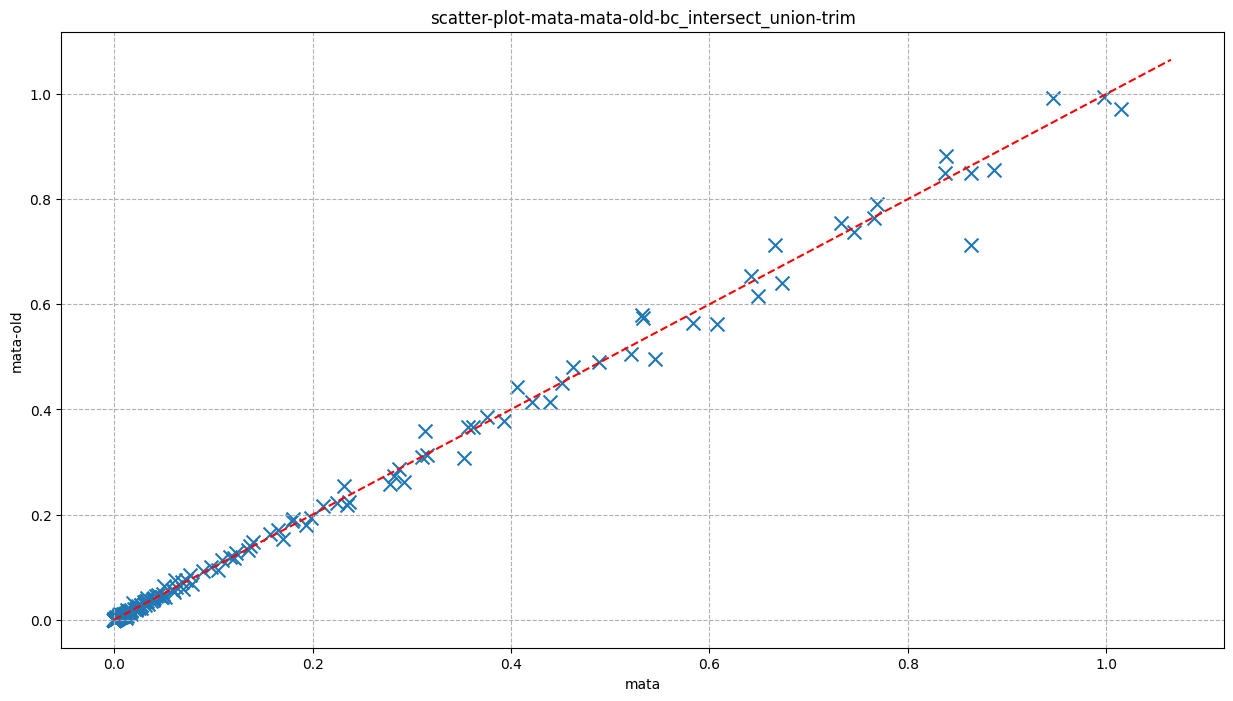

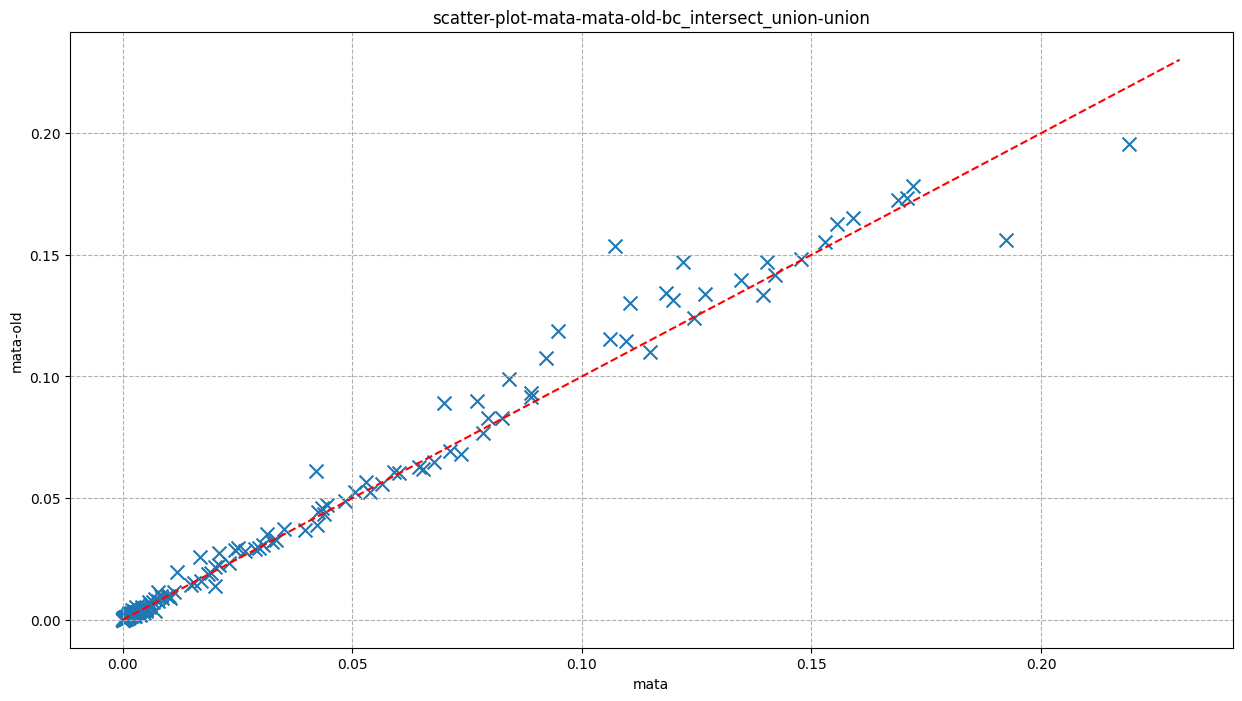

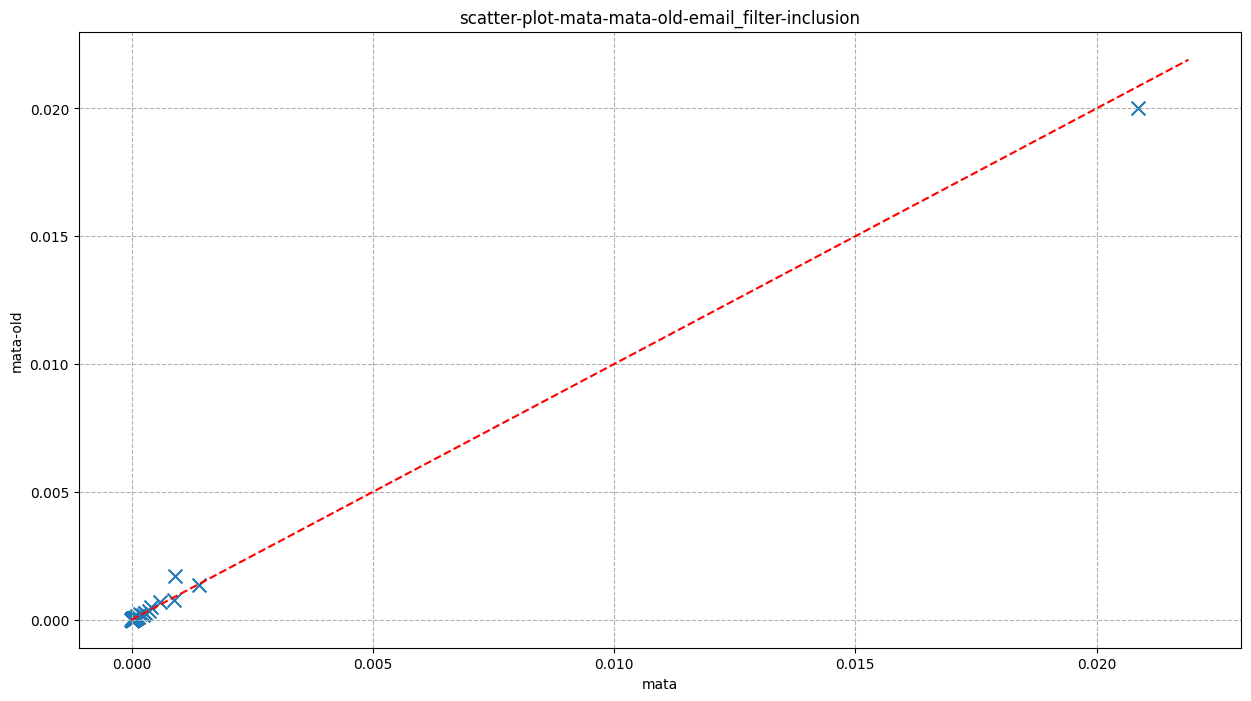

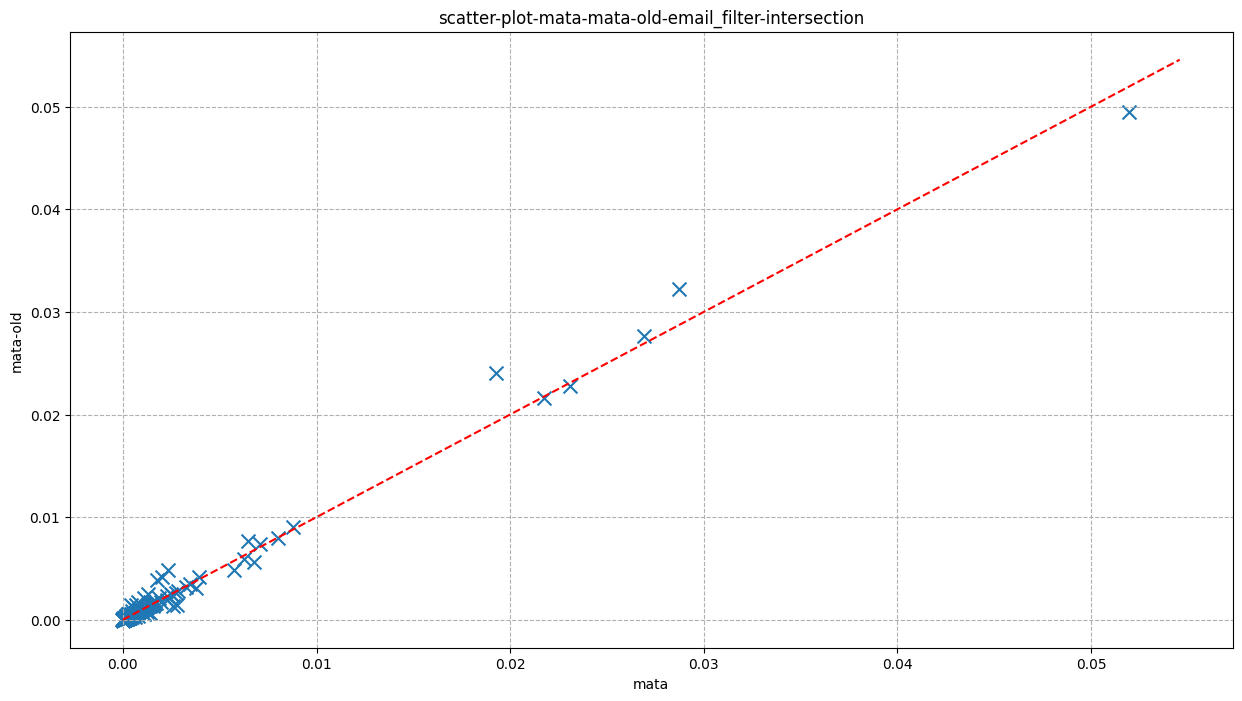

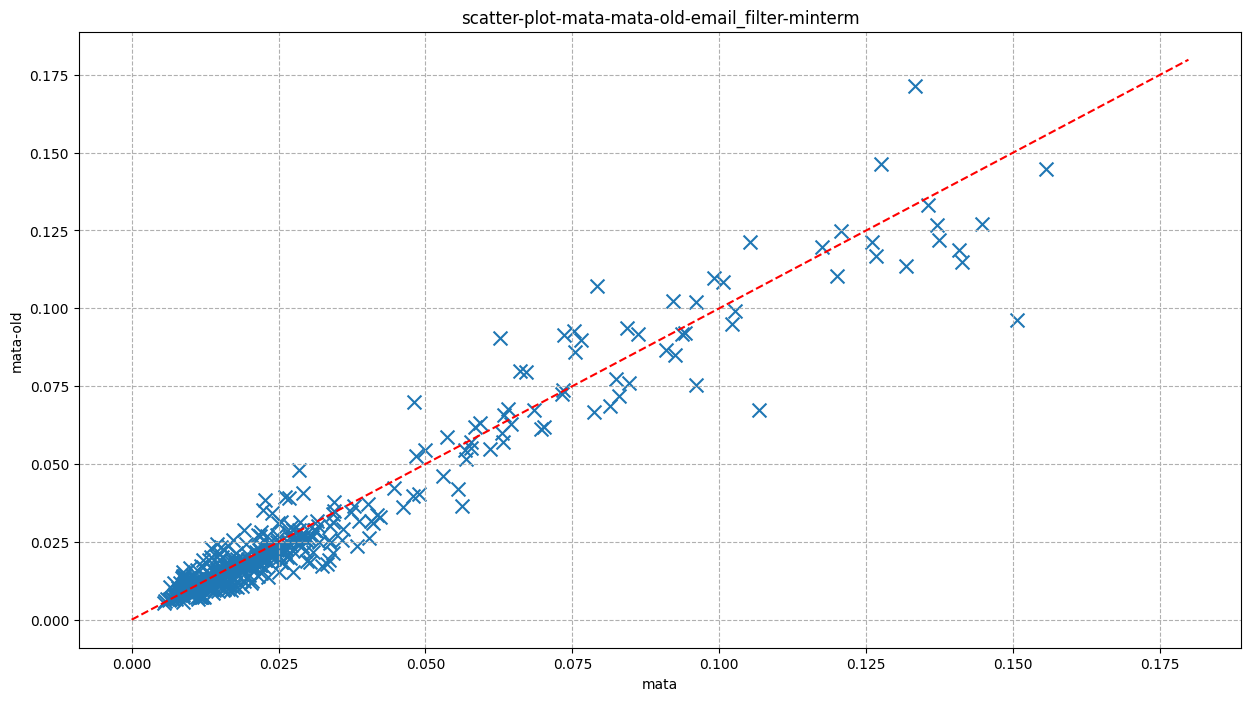

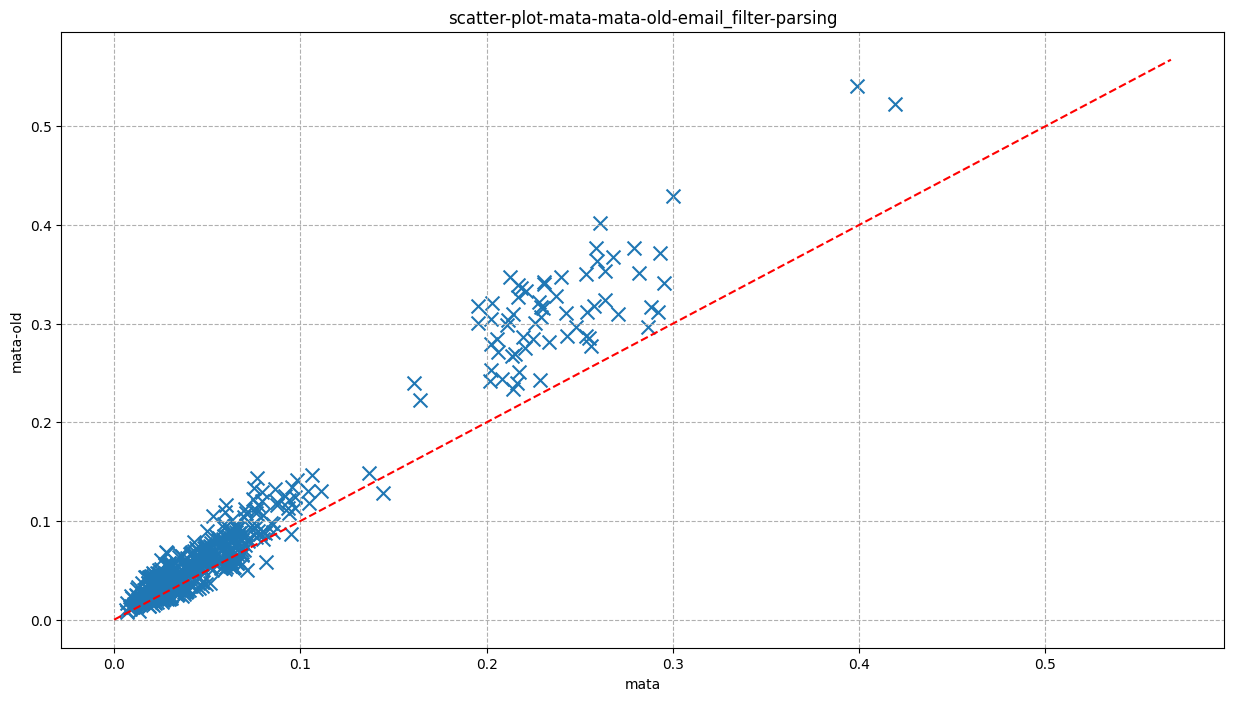

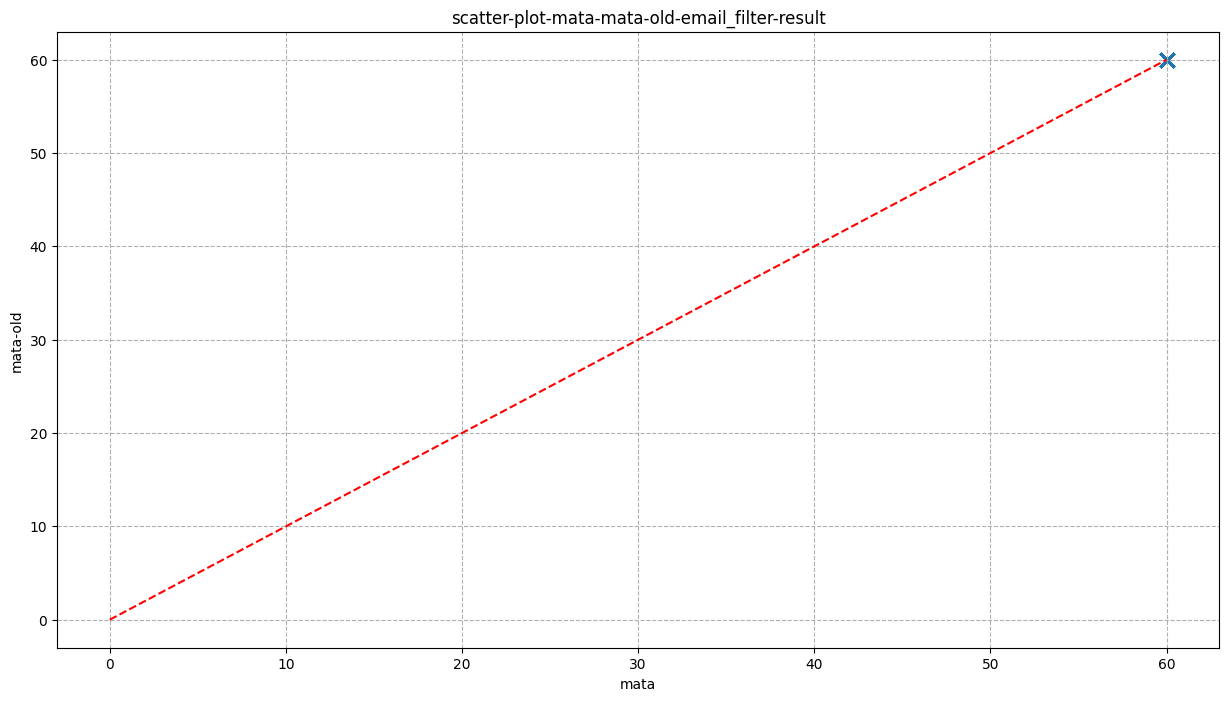

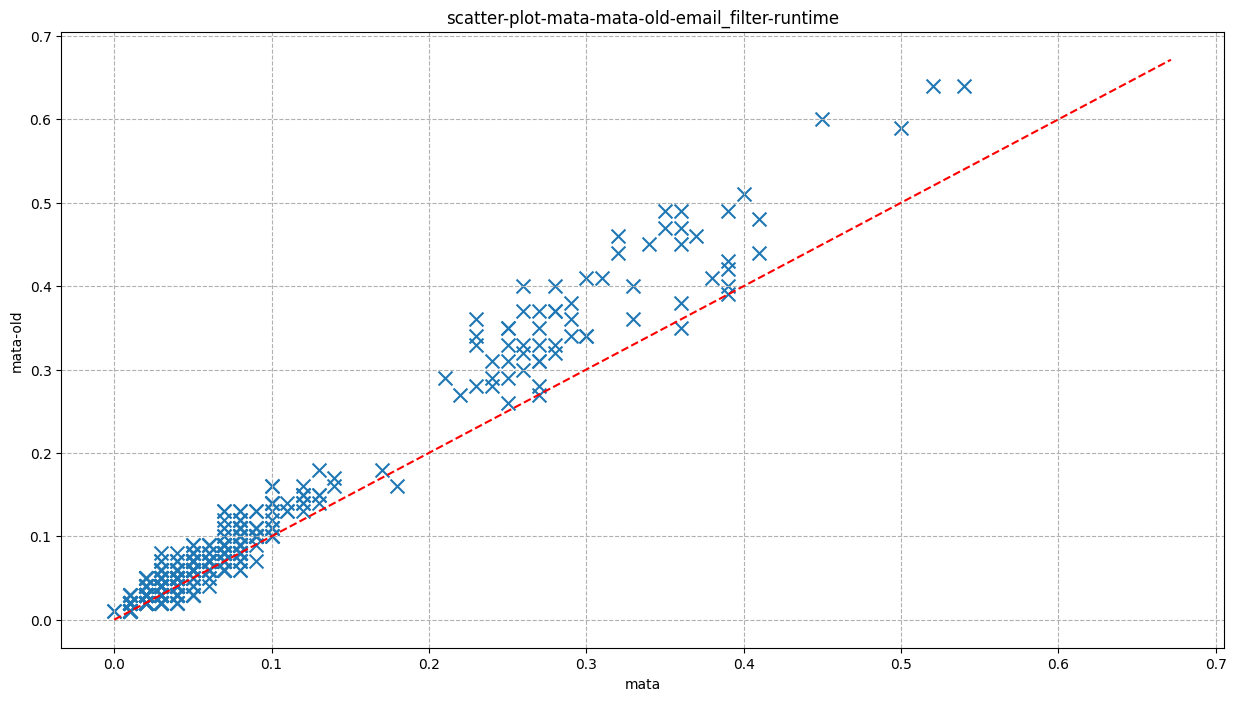

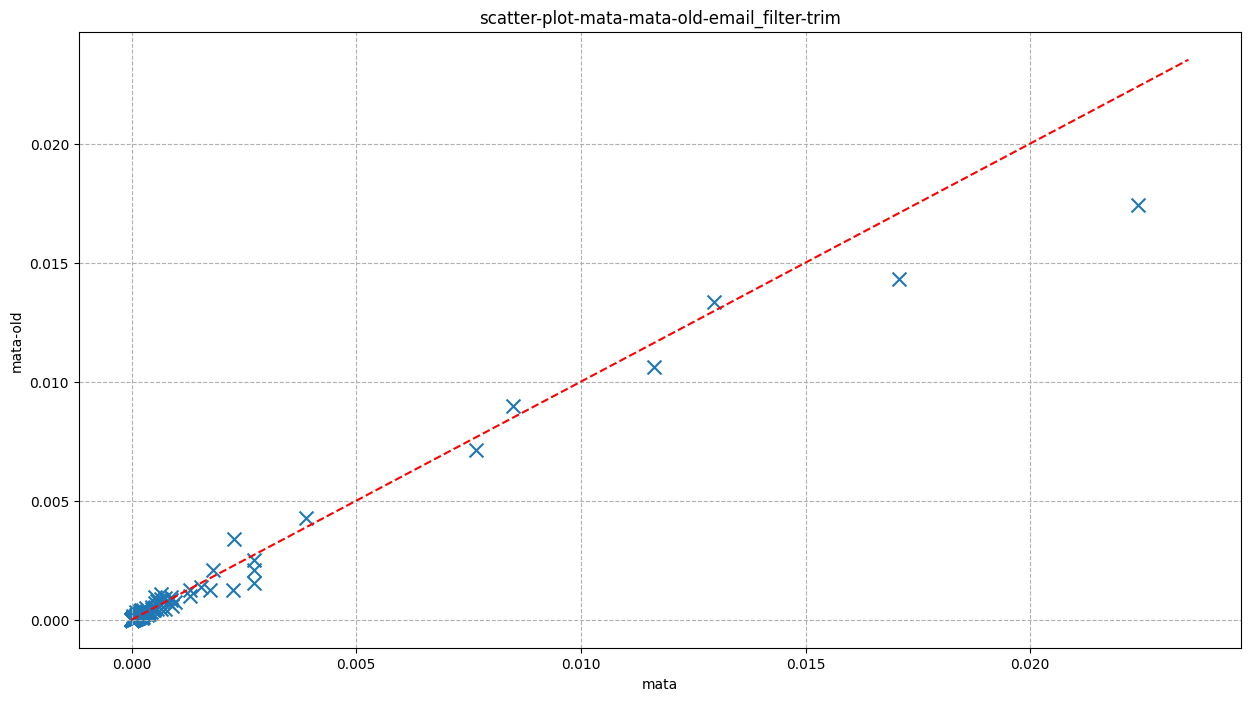

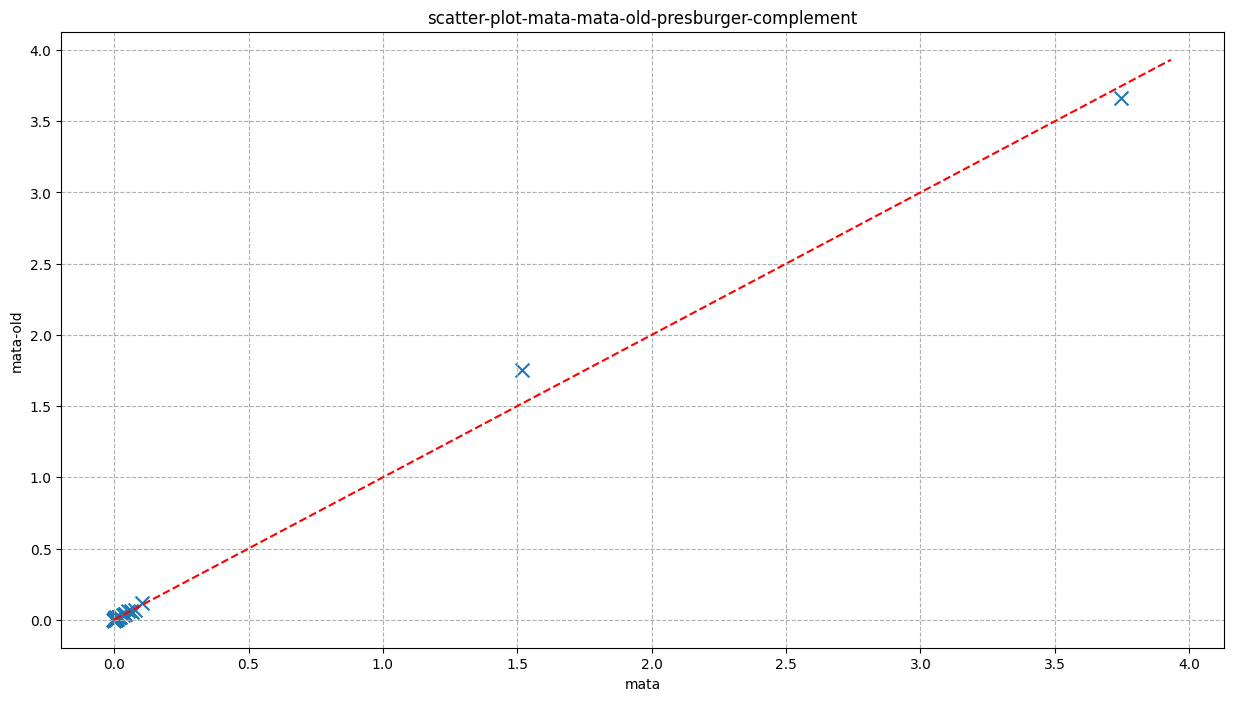

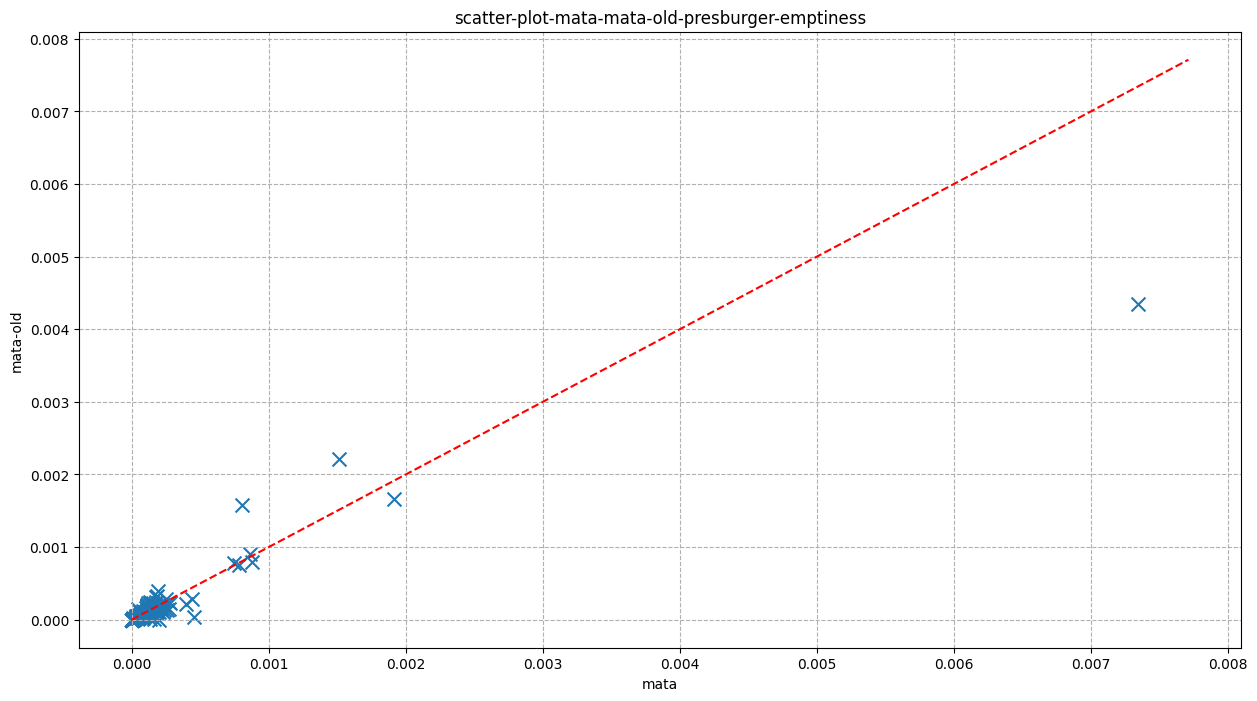

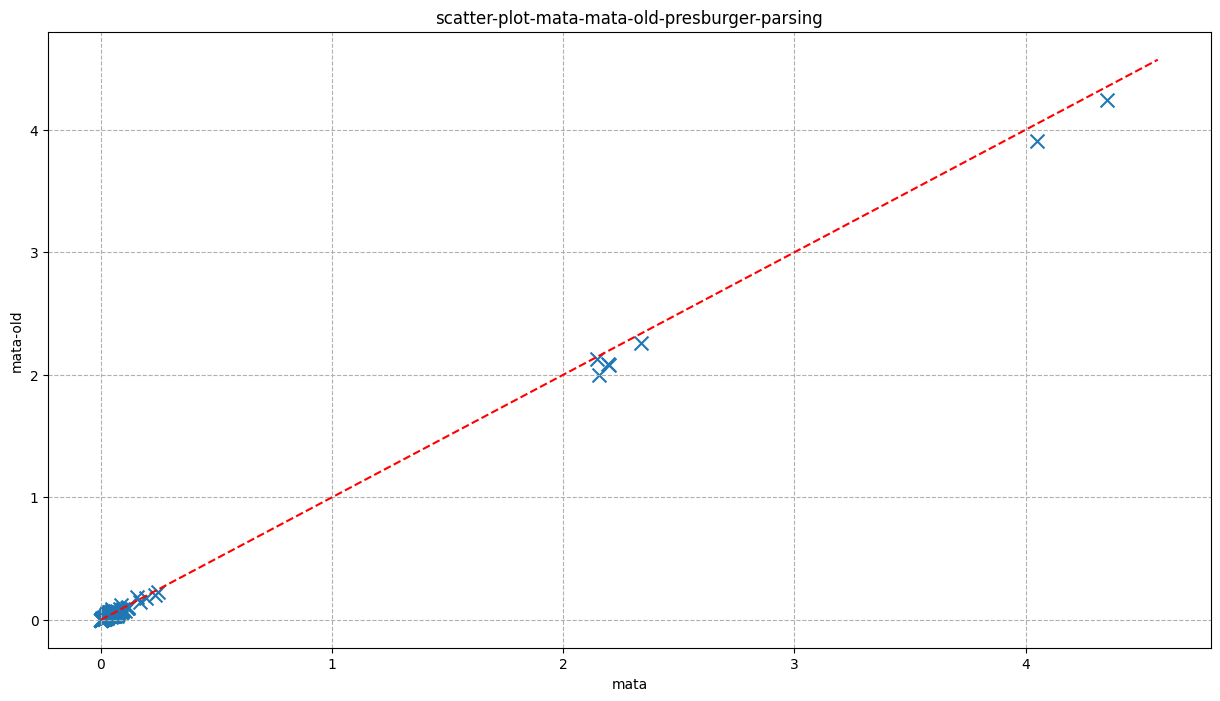

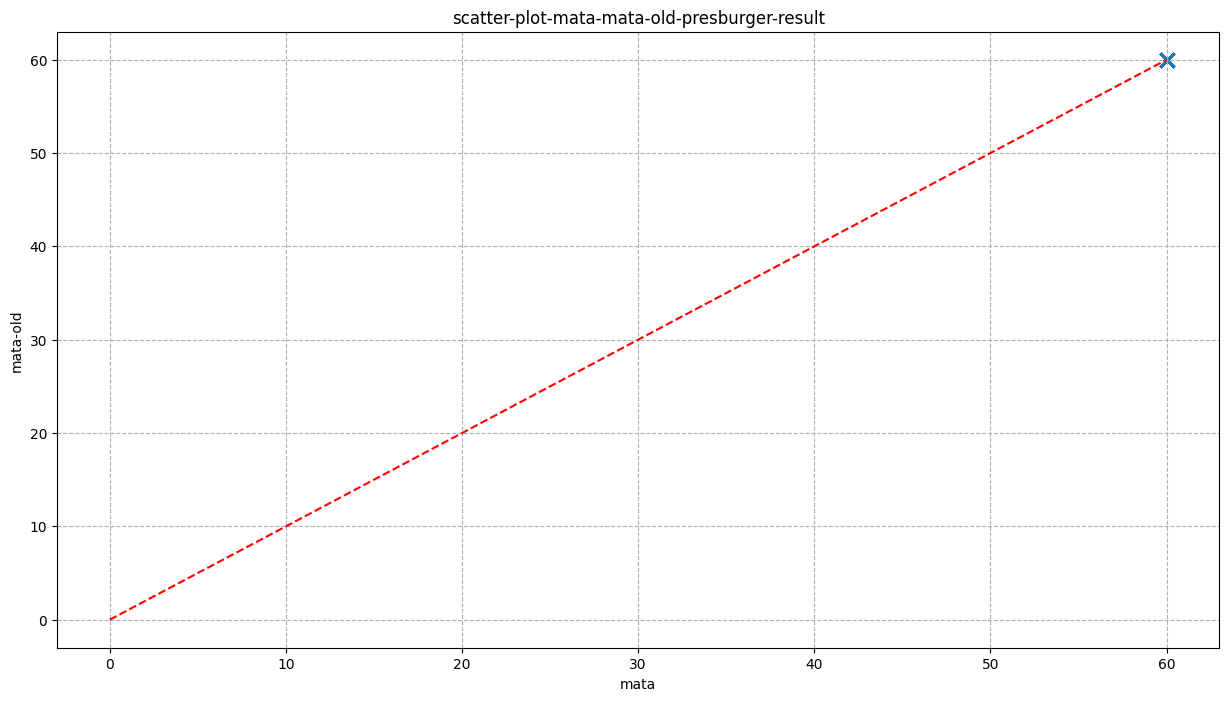

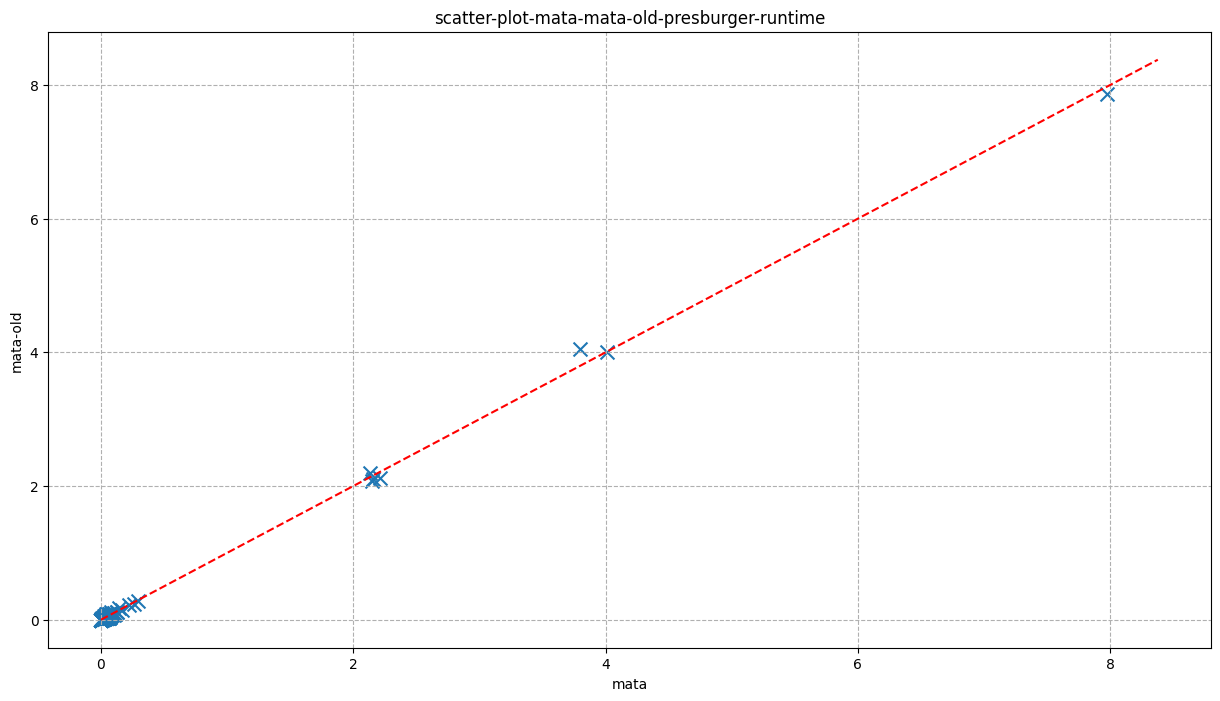

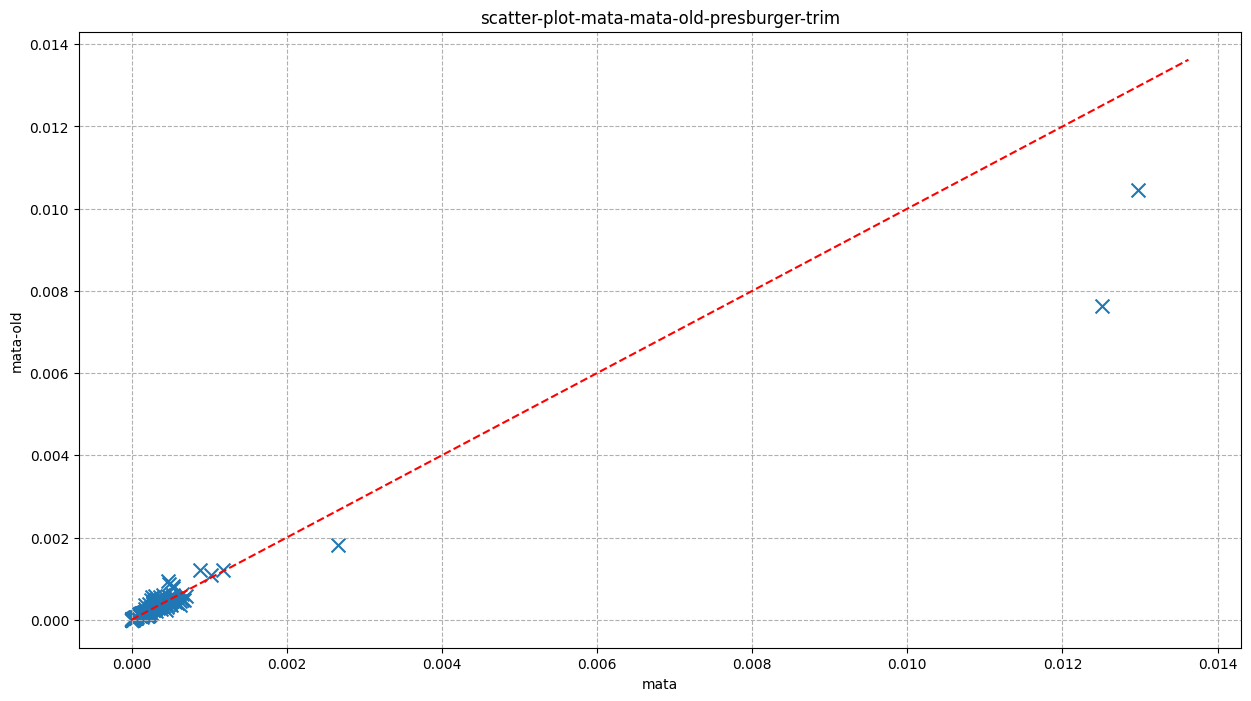

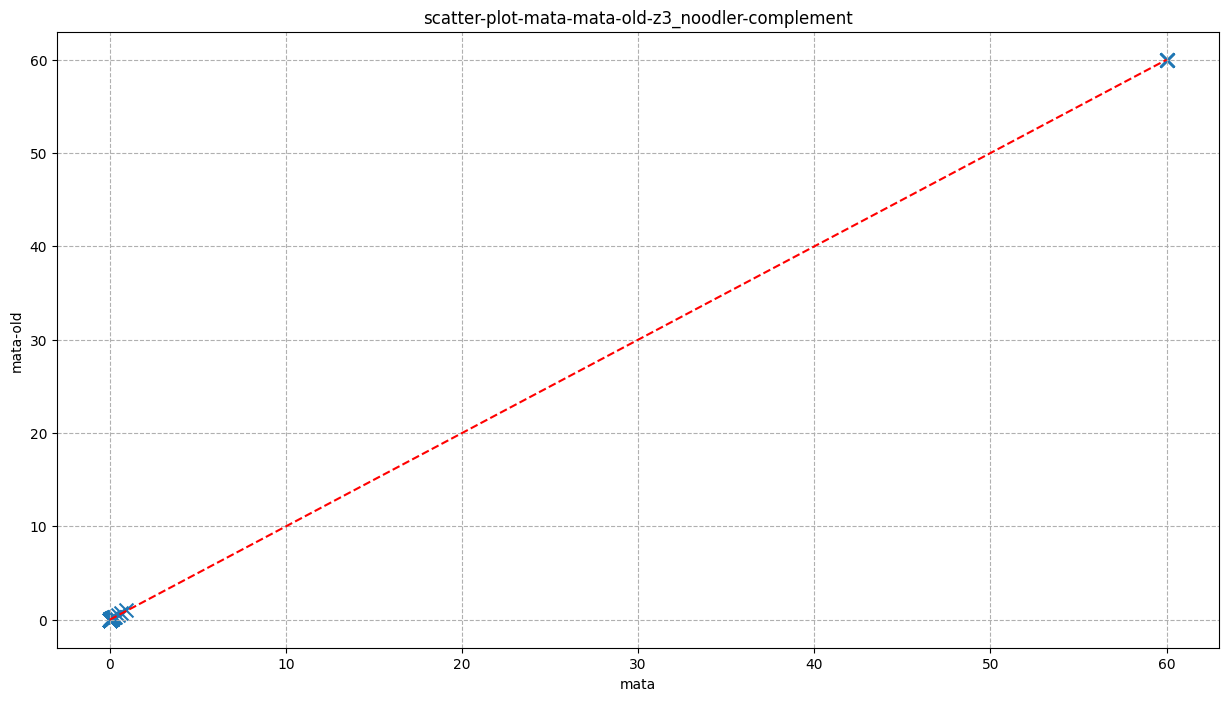

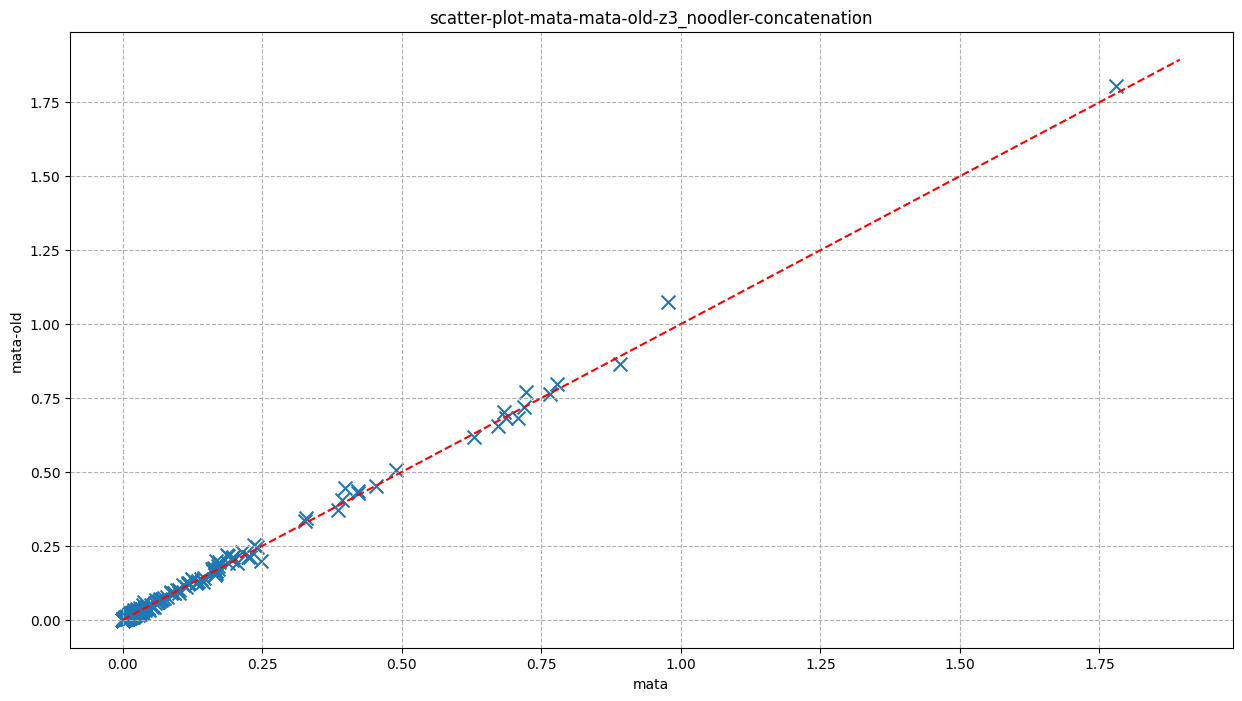

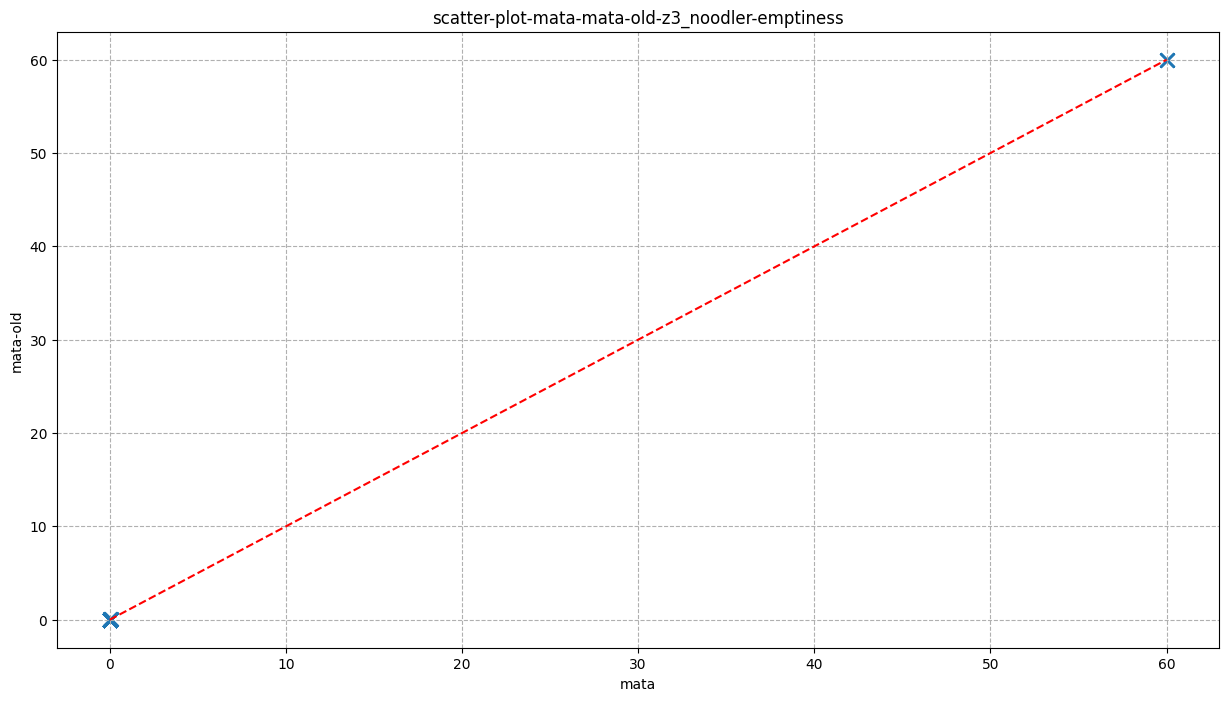

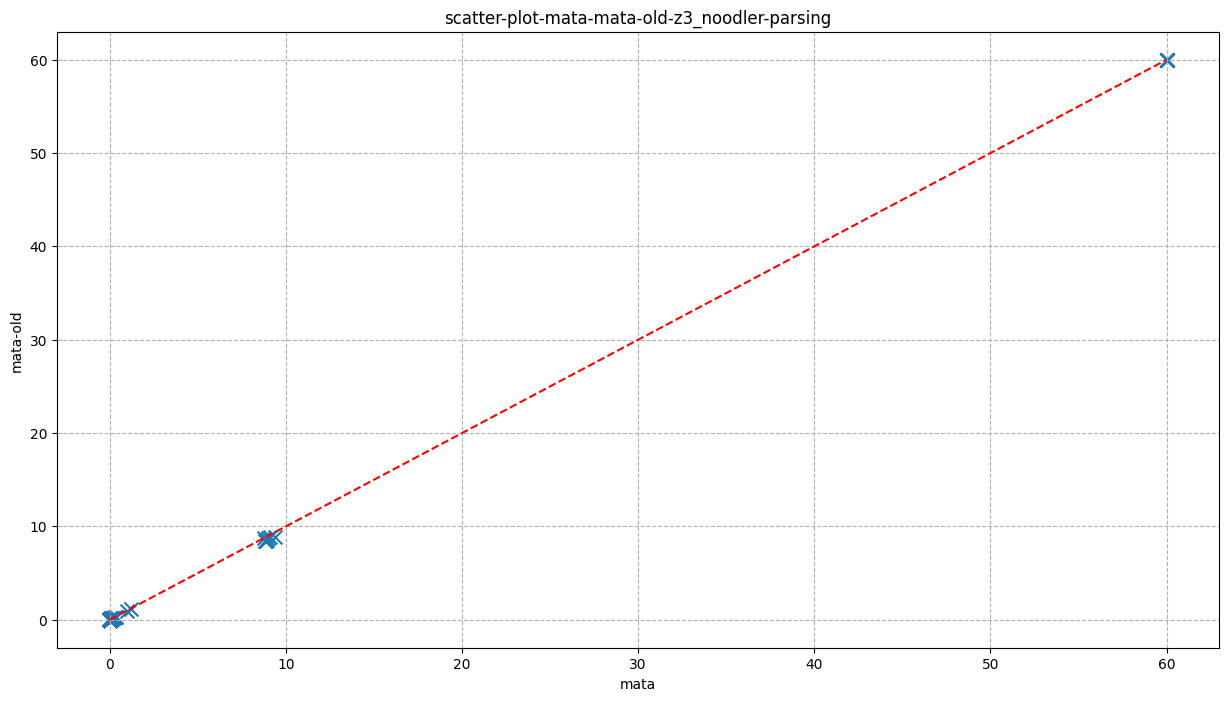

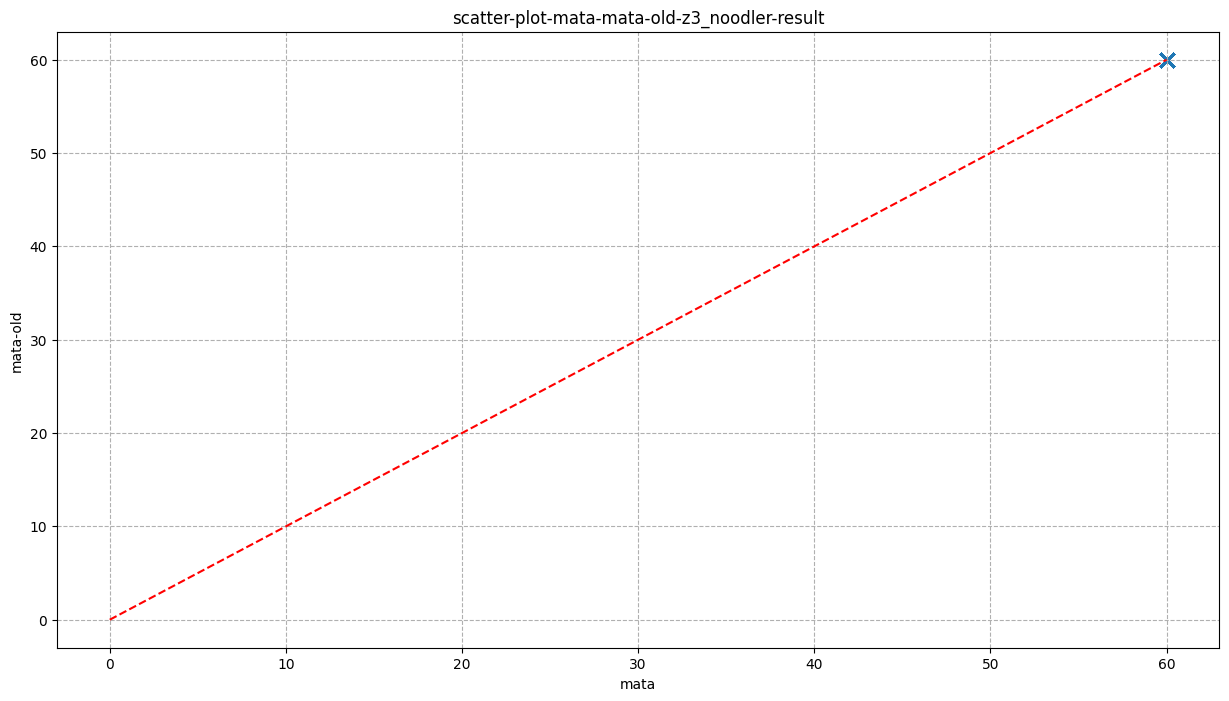

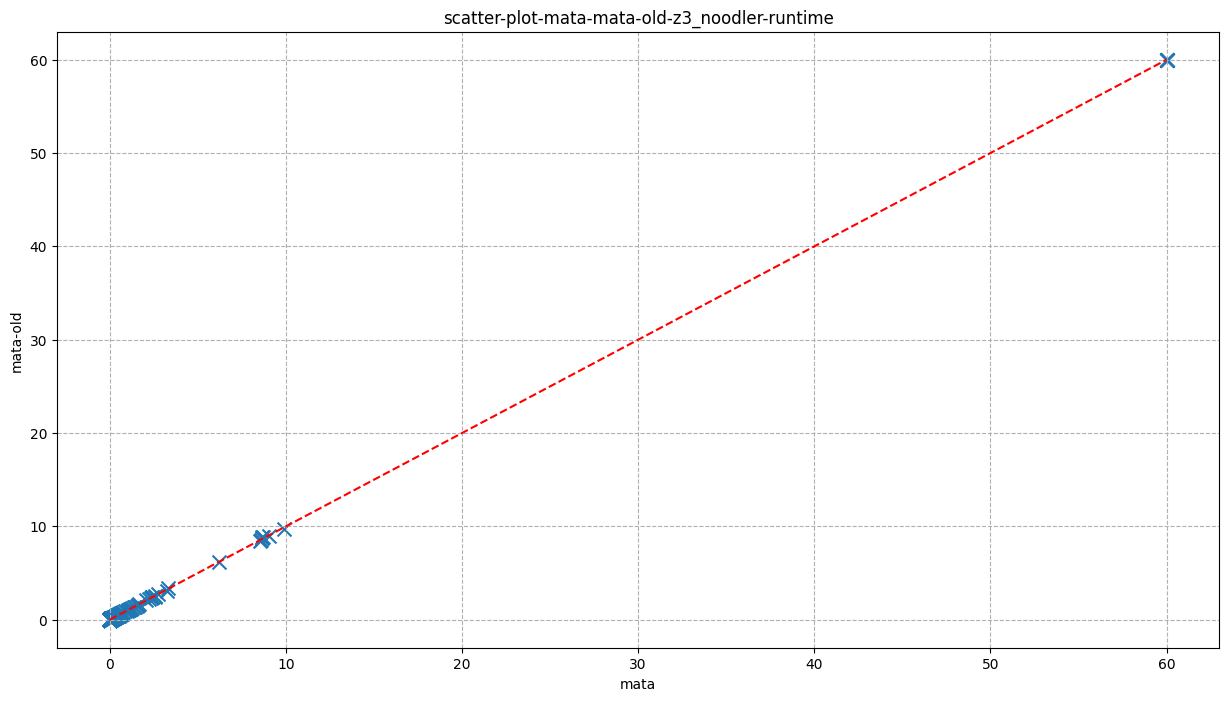

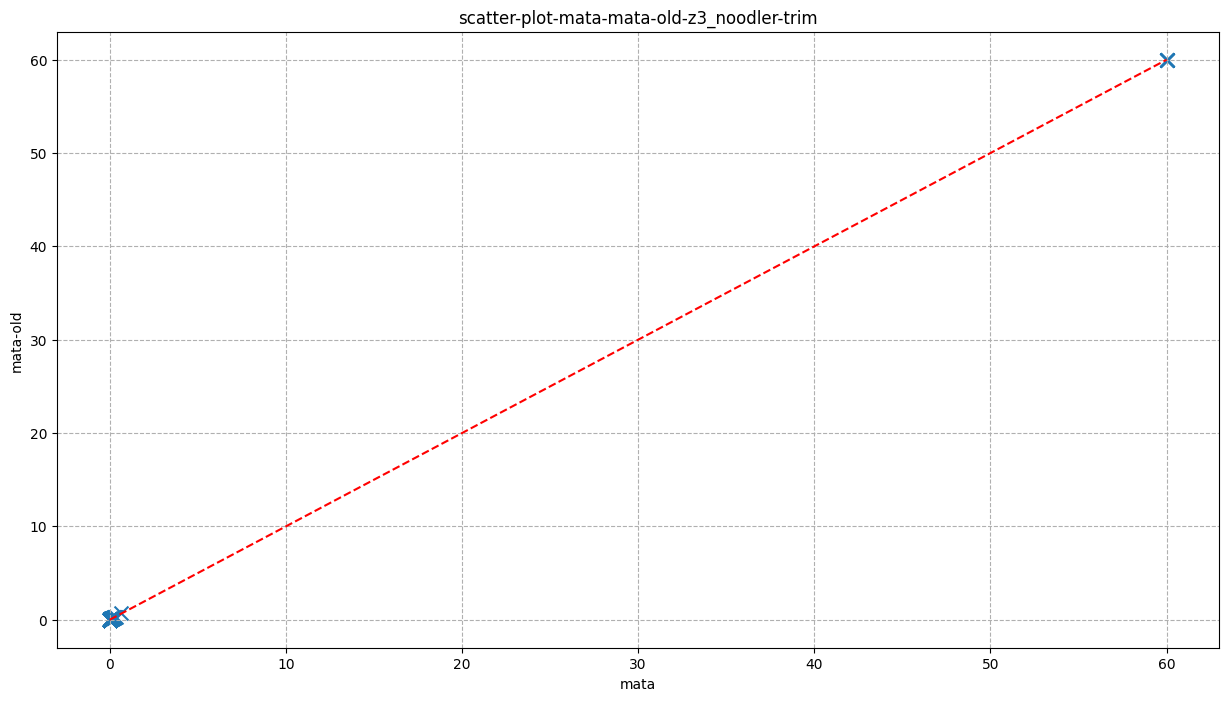

In [55]:
tools = [tool for tool in set(df['tool']) if tool != 'mata']

data = defaultdict(list)

def to_values(series):
    return [
        abs(a) if isinstance(a, int) or (isinstance(a, float) and not numpy.isnan(a)) else TIMEOUT for a in series
    ]

for grp, series in df.groupby(['bench', 'op']):
    for tool in tools:
        s = list(series[series['tool'] == 'mata']['time'])
        ss = list(series[series['tool'] == tool]['time'])
        print(len(s), len(ss))
        for i, d in enumerate(zip(s, ss)):
            data[str(i)].append(d)
        if len(s) == 0 or len(ss) == 0 or len(s) != len(ss):
            continue
        plt.figure(figsize=(15, 8))
        plt.scatter(
            to_values(s), to_values(ss), marker='x', s=100,
        )
        plt.grid(True, which='both', linestyle='--')
        pt = min(max(plt.xlim()[1], plt.ylim()[1]), 60)
        plt.plot([0, pt], [0, pt], linestyle='--', color='red')
        ax = plt.gca()
        ax.set_xlabel(f"mata")
        ax.set_ylabel(f"{tool}")
        title = f"scatter-plot-mata-{tool}-{grp[0]}-{grp[1]}"
        plt.title(title)
        save_figure(title)
        #plt.show()
        
        

Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-complement.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-concatenation.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-emptiness.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-inclusion.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-intersection.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-minterm.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-parsing.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-result.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-runtime.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-trim.png
Saving to ./data/experiments-10-02-parsing/figs/cactus-plot-union.png


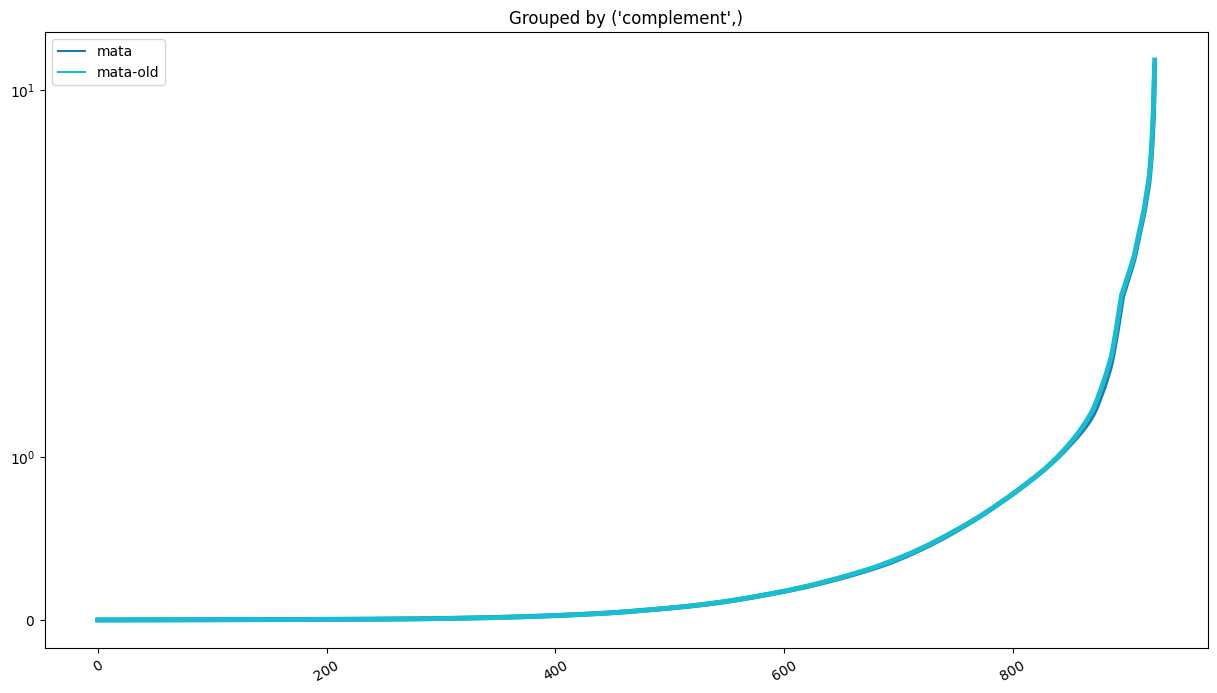

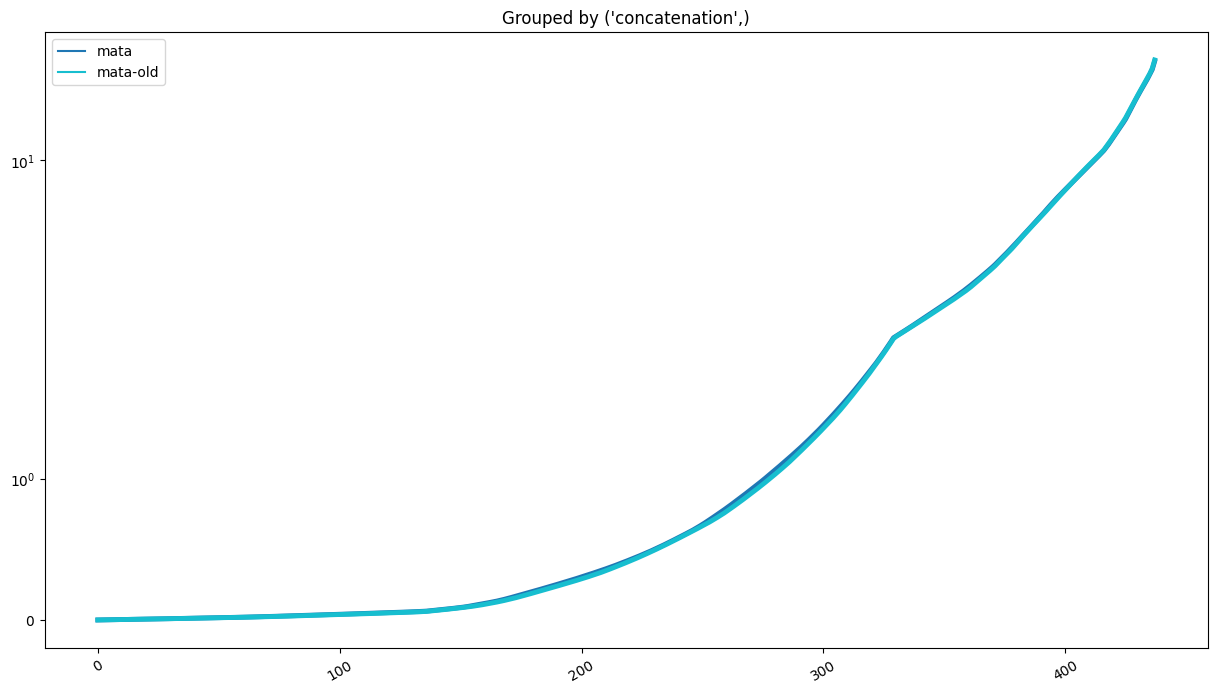

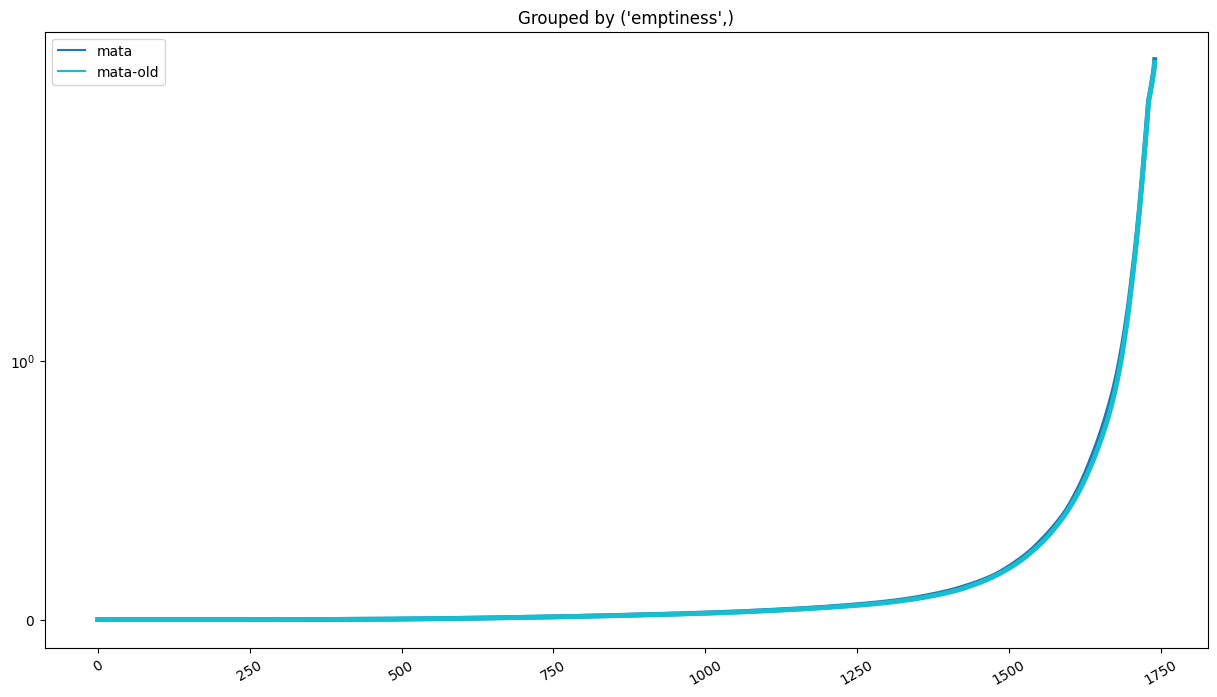

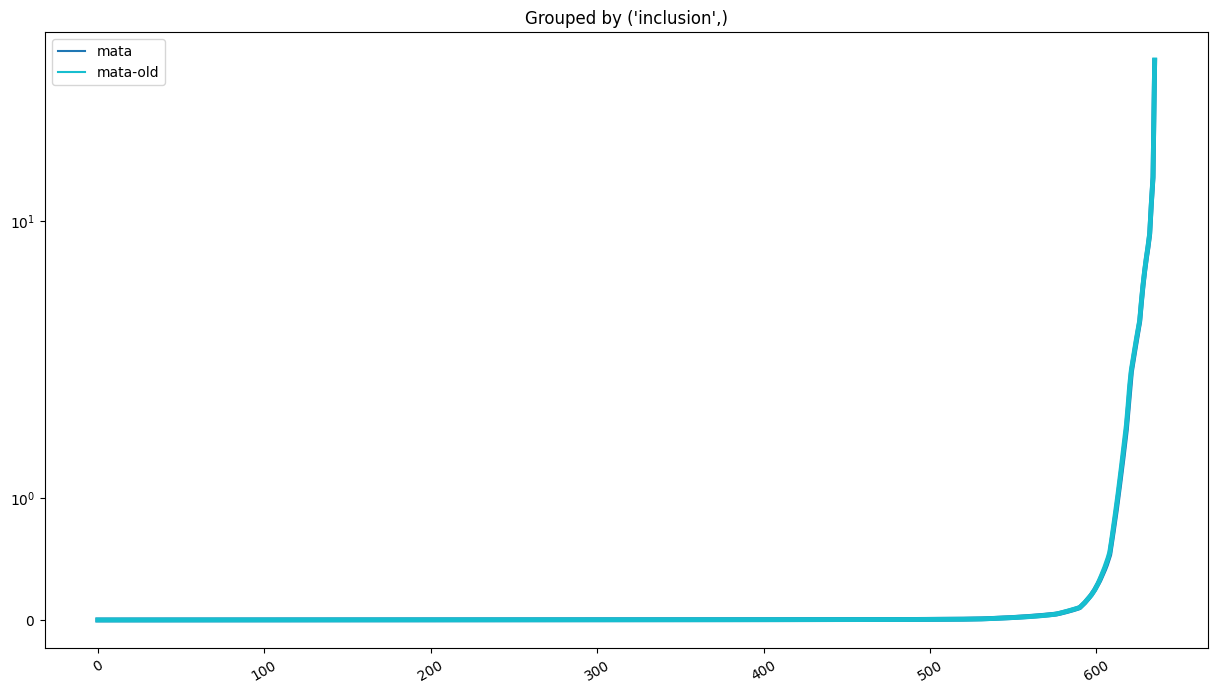

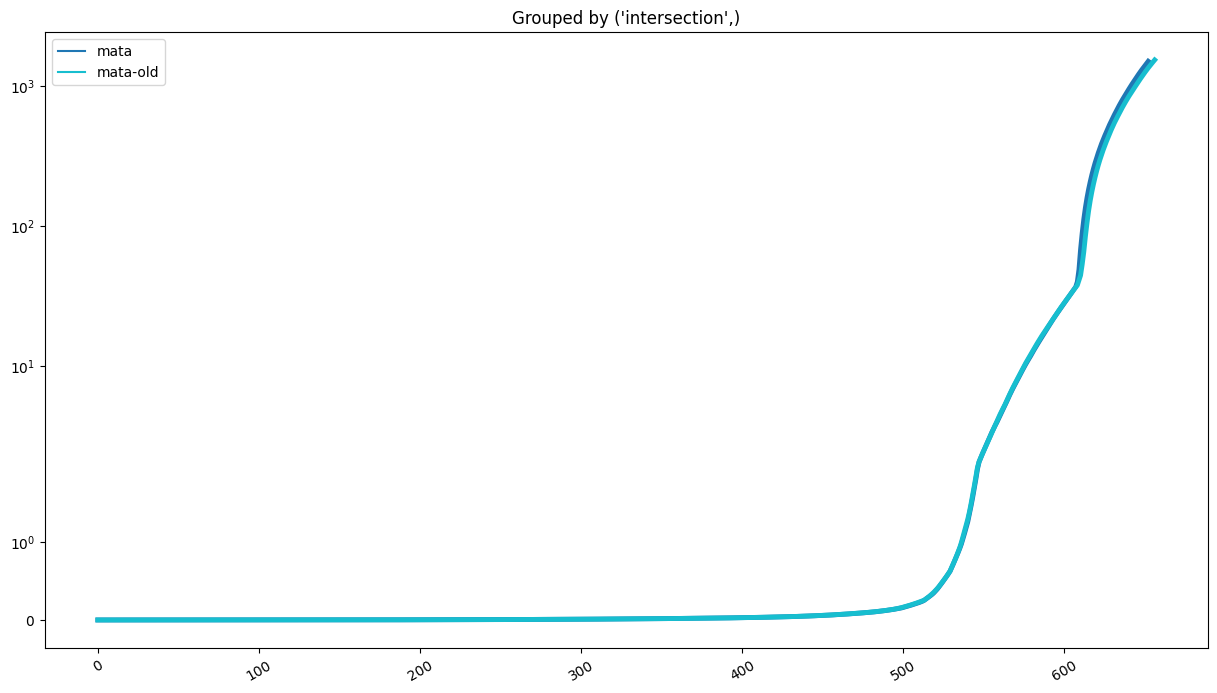

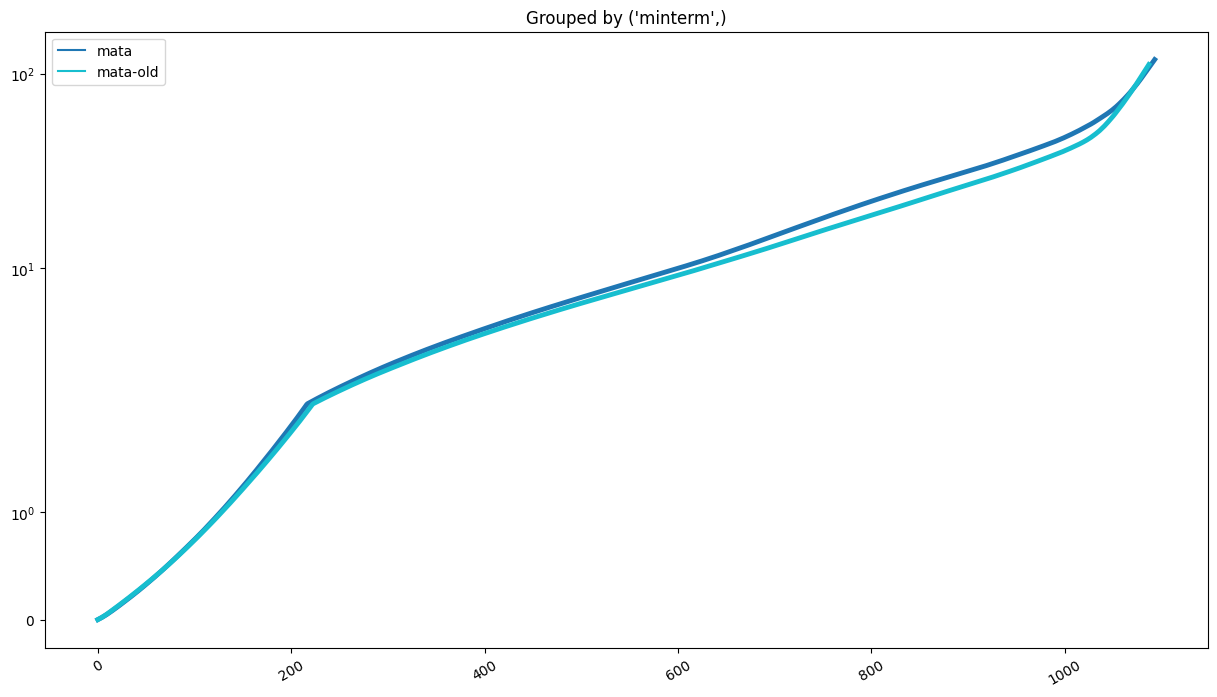

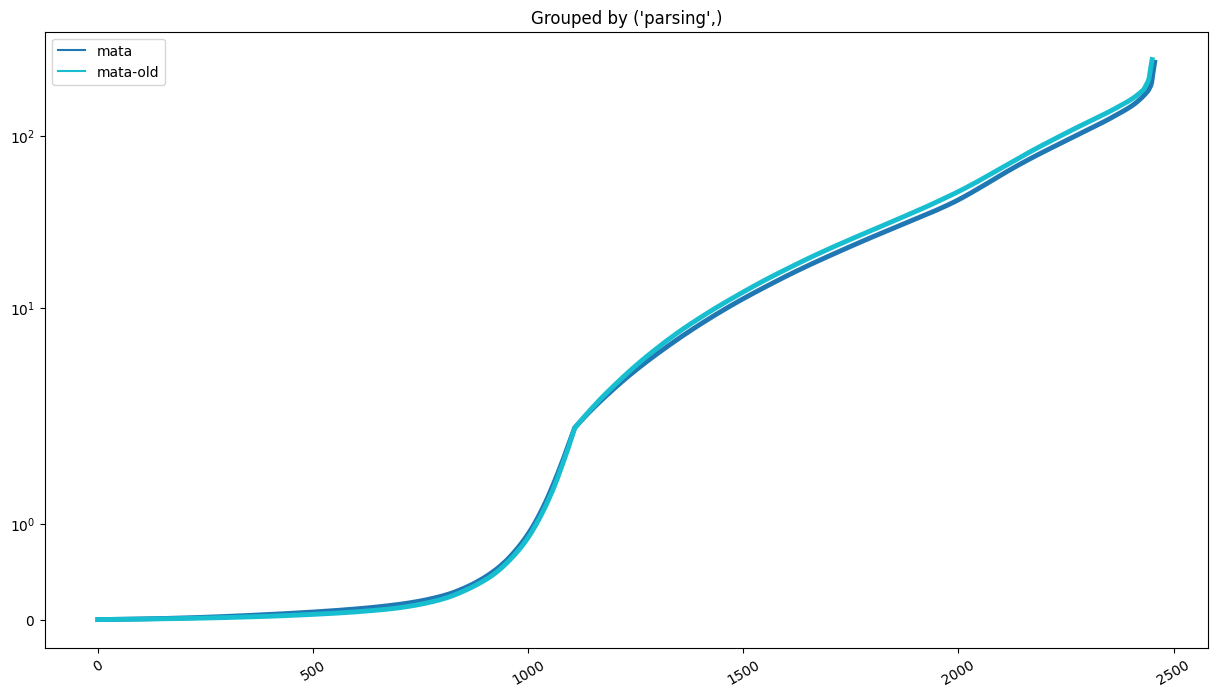

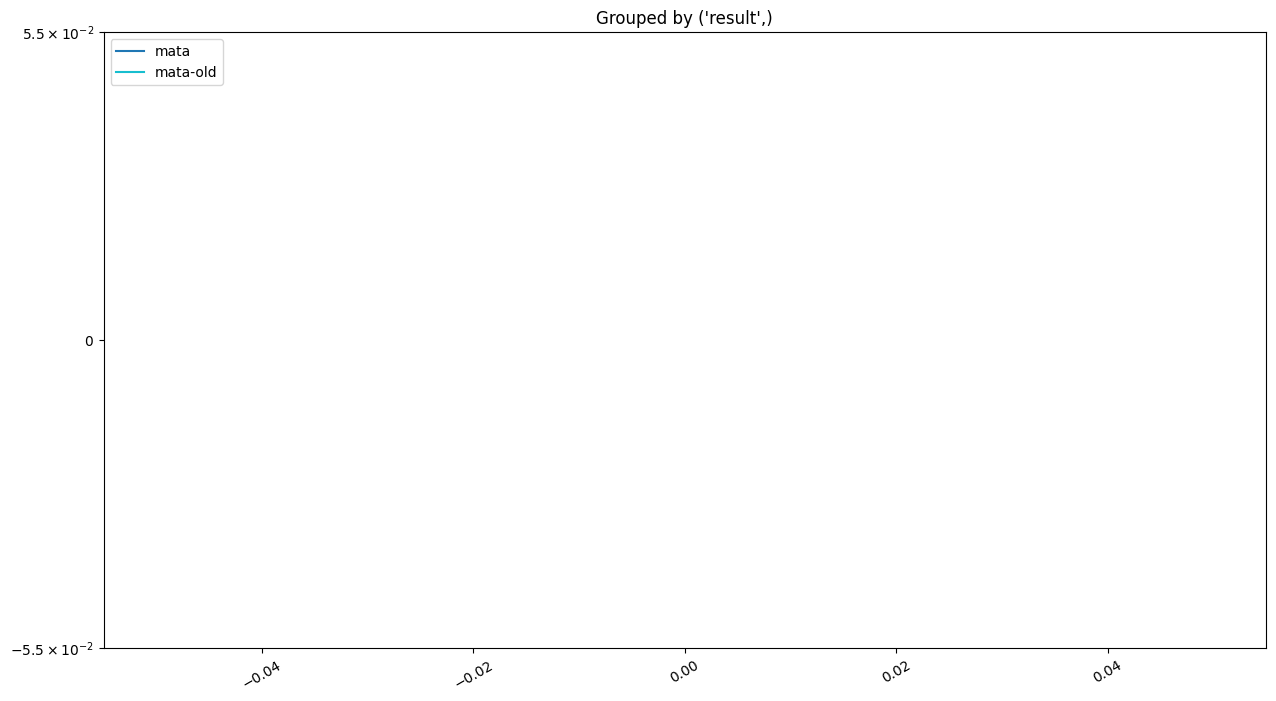

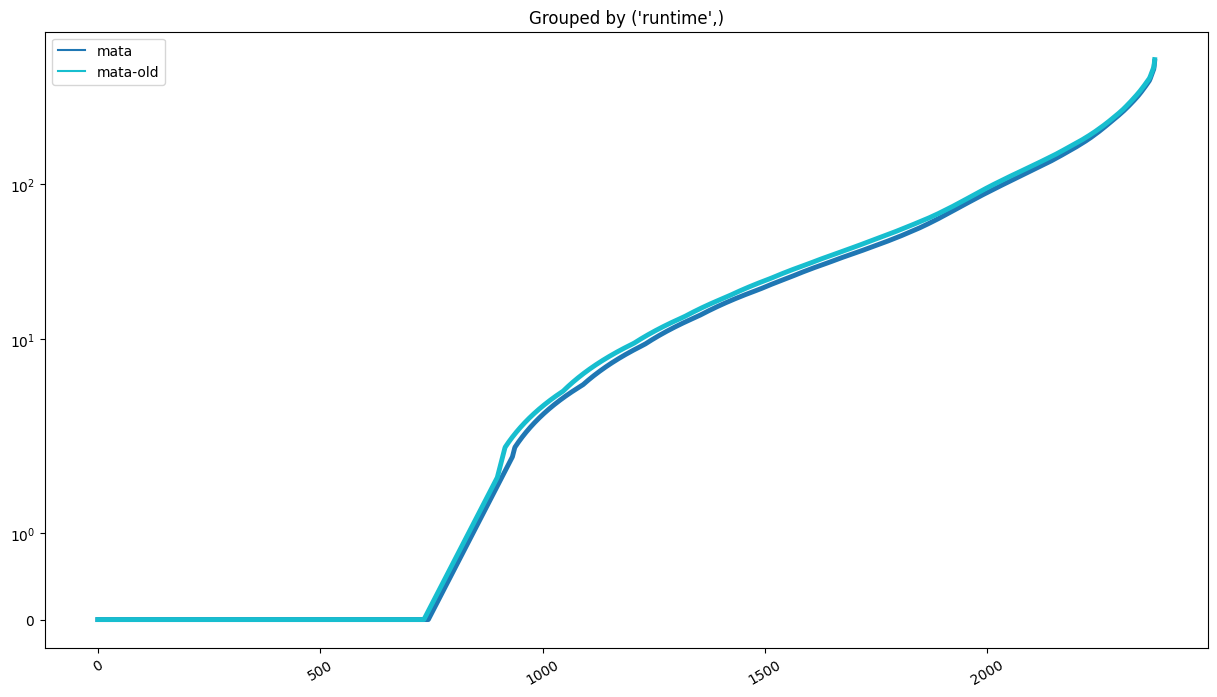

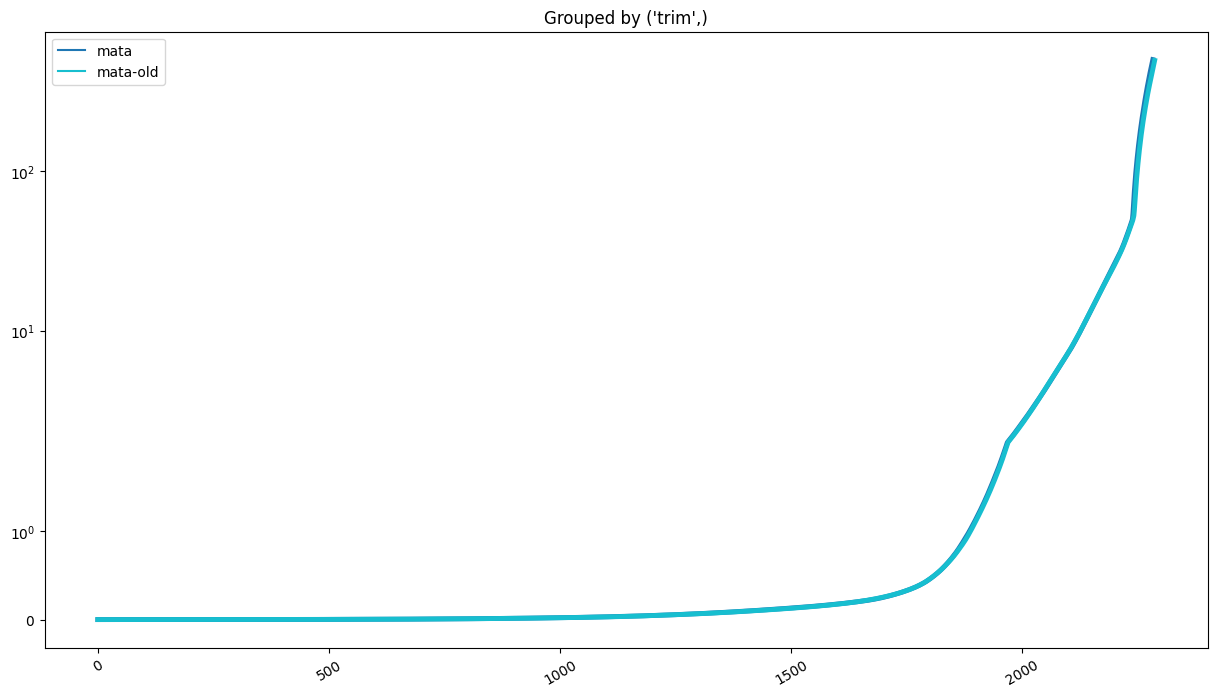

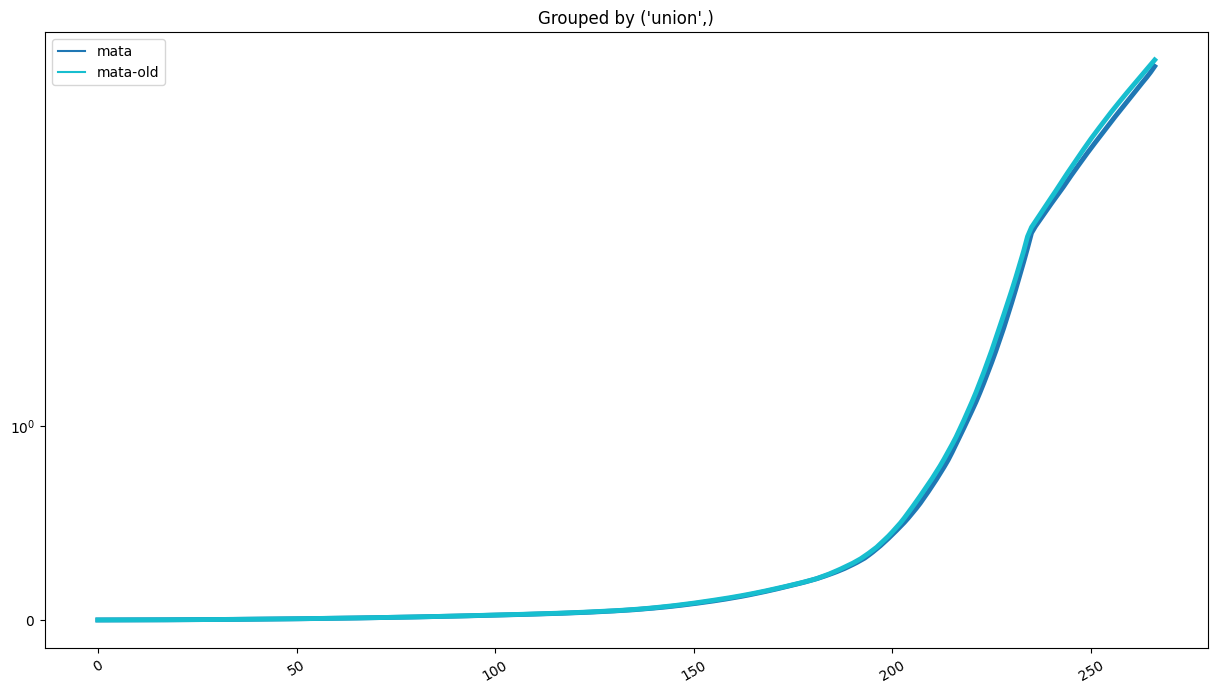

In [56]:
for grp, series in df.groupby(['op']):
    plt.figure(figsize=(15, 8))
    data = {}
    for tool, values in series.groupby('tool'):
        data[tool] = list(sum_generator(values))
        
    g = seaborn.lineplot(
        data, linewidth=3.5, dashes='', palette=color_map
    )
    g.set(yscale="symlog")
    g.set_xticklabels(g.get_xticklabels(), rotation=30)
    g.set_title(f"Grouped by {grp}")
    seaborn.move_legend(g, "upper left", bbox_to_anchor=(0., 1), frameon=True)
    save_figure(f"cactus-plot-{grp[0]}")

In [18]:
results_set = set()
res_count = defaultdict(int)

data = []
tools = list(set(df['tool']))
tool_len = len(tools)

for grp, series in df.groupby('input'):
    results = series[series['op'] == 'result']

    output = ['-' for i in range(tool_len)]
    for a, v in results.iterrows():
        ind = tools.index(v['tool'])
        output[ind] = v['time']
    output_as_str = ";".join(str(a) for a in output)
    val_set = set(a for a in output if (not isinstance(a, float) or not numpy.isnan(a)) and a != 'ERR' and a != '-')
    if output_as_str not in results_set and len(val_set) > 1:
        data.append([grp] + output)
    results_set.add(output_as_str)
    if len(val_set) > 1:
        res_count[output_as_str] += 1

In [19]:
output = tabulate.tabulate([d + [res_count[';'.join(str(a) for a in d[1:])]] for d in data], headers=['input'] + tools + ['number'], tablefmt='tsv')
with open(os.path.join(DATA_SOURCE, FIGS_DIR, 'inconsistent-results.txt'), 'w') as ih:
    ih.write(output)
print(output)

input  	fado  	brics  	mata-old  	(py)mata  	automata  	(j)alib  	mata  	vata  	(py)alib  	awali  	number


In [20]:
print(tools)
for key, val in res_count.items():
    print(key, val)

['fado', 'brics', 'mata-old', '(py)mata', 'automata', '(j)alib', 'mata', 'vata', '(py)alib', 'awali']


In [21]:
print("DONE")

DONE


In [208]:
op_to_problem = defaultdict(set)
for op in operations:
    if op in ('result', 'trim', 'parsing', 'transform'):
        continue
    for grp, data in df[df['op'] == op].groupby('input'):
        mata_time = None
        pymata_time = None
        other_times = []
        for tool in tools:
            time = list(data[data['tool'] == tool]['time'])
            if len(time) == 1:
                if time[0] == 'ERR':
                    continue
                elif tool == 'mata':
                    mata_time = int(time[0]) if not numpy.isnan(time[0]) else abs(TIMEOUT)
                elif tool == '(py)mata':
                    pymata_time = int(time[0]) if not numpy.isnan(time[0]) else abs(TIMEOUT)
                else:
                    other_times.append(abs(int(time[0])) if not numpy.isnan(time[0]) else abs(TIMEOUT))
        if set(other_times) == {TIMEOUT} or set(other_times) == {TIMEOUT, 0} or len(set(other_times + [mata_time])) == 1:
            continue
        if pymata_time is not None and mata_time is not None and pymata_time < mata_time:
            op_to_problem['pymata_faster_than_mata'].add(op + ";" + grp + ";" + str(pymata_time) + ";" + str(mata_time))
        if pymata_time is not None and mata_time is not None and (pymata_time - mata_time) > 1:
            op_to_problem['mata_faster_than_pymata'].add(op + ";" + grp + ";" + str(mata_time) + ";" + str(pymata_time))
        if mata_time is not None and all(mata_time > tool_time for tool_time in other_times):
            op_to_problem['mata_is_slowest'].add(op + ";" + grp+ ";" + str(mata_time) + ";" + ", ".join(str(a) for a in other_times))
        if mata_time is not None and not all(mata_time < tool_time or mata_time == tool_time == TIMEOUT for tool_time in other_times) and not mata_time == 0 and op != 'trim':
            op_to_problem['mata_is_not_fastest'].add(op + ";" + grp+ ";"+ str(mata_time) + ";" + ", ".join(str(a) for a in other_times))

In [209]:
output = ""
for key in op_to_problem.keys():
    output += key + "\n"
    output += "--------------------------" + "\n"
    for problem in sorted(op_to_problem[key]):
        output += problem + "\n"
    output += "\n"
print(len(output.split('\n')))

134


In [211]:
print(output)
with open('weird-shit-experiments-09-21.txt', 'w') as shit_handle:
    shit_handle.write(output)

mata_is_not_fastest
--------------------------
complement;/home/experiments/nfa-bench/benchmarks/presburger/complement/UltimateAutomizer/Primes_true-unreach-call.c_1657.0.mata;2;0, 0, 8, 60, 0
complement;/home/experiments/nfa-bench/benchmarks/presburger/complement/UltimateAutomizer/Primes_true-unreach-call.c_798.0.mata;3;0, 0, 14, 60, 60
inclusion;/home/experiments/nfa-bench/benchmarks/automata_inclusion/true-IBakery4pBinEnc-FbOneOne-Nondet-Partial-A-2-lhs.mata,/home/experiments/nfa-bench/benchmarks/automata_inclusion/true-IBakery4pBinEnc-FbOneOne-Nondet-Partial-A-2-rhs.mata;1;0, 0, 10, 0, 0, 60
inclusion;/home/experiments/nfa-bench/benchmarks/automata_inclusion/true-IBakery4pBinEnc-FbOneOne-Nondet-Partial-A-3-lhs.mata,/home/experiments/nfa-bench/benchmarks/automata_inclusion/true-IBakery4pBinEnc-FbOneOne-Nondet-Partial-A-3-rhs.mata;1;0, 0, 17, 0, 0, 60
inclusion;/home/experiments/nfa-bench/benchmarks/automata_inclusion/true-IBakery4pBinEnc-FbOneOne-Nondet-Partiali-B-0-lhs.mata,/home/e

In [234]:
q = df.query("tool == 'mata' & op == 'intersection' & time != 'ERR'")
intersects = [list(a) for a in q[['input', 'time']].values]
with open('costly-intersect', 'w') as ch:
    for a, b in sorted(intersects, key=lambda x: x[1], reverse=True):
        ch.write(f"{a};{b}\n")

In [60]:
for op, val in op_map.items():
    print(op, set(val))

runtime {'java-brics-runtime', 'vata-runtime', 'pymata-runtime', 'java-automatalib-runtime', 'pyautomata-lib-runtime', 'mata-runtime', 'automata-runtime', 'awali-runtime', 'pyfado-runtime'}
parsing {'vata-mataparsing', 'mata-mataparsing', 'awali-mataparsing'}
minterm {'vata-mataminterm', 'awali-mataminterm', 'mata-mataminterm'}
transform {'pyfado-construction', 'awali-construction', 'pyautomata-lib-conversion', 'pymata-construction', 'pymata-conversion', 'automata-construction', 'vata-construction', 'java-brics-construction', 'java-automatalib-construction', 'pyfado-conversion', 'pyautomata-lib-construction'}
intersection {'pymata-intersection', 'pyfado-intersection', 'pyautomata-lib-intersection', 'awali-intersection', 'vata-intersection', 'java-automatalib-interall', 'java-brics-intersection', 'mata-intersection', 'java-brics-interall', 'automata-intersection'}
trim {'mata-trim', 'vata-trim', 'pymata-trimming', 'automata-trim', 'pyautomata-lib-trimming', 'awali-trim', 'pyfado-trimmin